## Confirmation Bias Project
#### Behavioural analyses
##### Experiment 1

##### Import important functions and libraries

In [1]:
import os, glob #pip install 
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
#import scikit_posthocs as sp
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

C:\Users\Angel\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


##### Important functions

In [2]:
def RT_filter(x, sd): 
    # this function is used to filter those trials with a RT that it are below/above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x
def sdt_comp(x): # sdt is used to compute d' and c (even though, it is not used in these analyses)
    phit = x.loc[x.cond == 1,:].deci.mean()
    pfa  = x.loc[x.cond == 0,:].deci.mean() #correct condition to be 0 instead of -1
    # avoiding 0 or 1 probs that lead to infinite values
    if phit == 1: phit = phit - 0.0001
    if phit == 0: phit = phit + 0.0001
    if pfa == 1:  pfa = pfa - 0.0001
    if pfa == 0:  pfa = pfa + 0.0001
    # z transform the scores
    zhit = scipy.stats.norm.ppf(phit, loc=0, scale = 1) 
    zfa  = scipy.stats.norm.ppf(pfa, loc =0, scale = 1)
    dprime = zhit - zfa
    c = -(zhit + zfa)/2
    out = pd.concat([pd.Series(phit, name = "phit"), pd.Series(pfa, name = "pfa"), pd.Series(dprime, name = "dprime"), pd.Series(c, name = "c")], axis = 1)
    #out = out.reset_index()
    return out #dprime, c #
def log_reg_fit(x, f): # this function is used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out

def z_RT(x):
    # this function is used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function is used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

def confii(x):
    if x['nrep'] == 0:
        return x['RTz']
    if x['nrep'] == 1:
        return x['pre_RTz']
    if x['nrep'] == 2:
        return x['2pre_RTz']
    return NaN 

### Data & variables

In [3]:
results_path = 'C:/Users/Angel/Dropbox/ConfBiasProject/Analyses/results' #windows             
#results_path = '/Users/alex/Dropbox/Projects/Condcision/Behav_data/FirstExperiment/' # mac

os.chdir(results_path) # change the current working directory to the results path 
rdata = pd.DataFrame([]) # concatenate general behav subject data
odata = pd.DataFrame([]) # concatenate here orientation stimuli (the matrix containing the 8 orientations x trial)
ddata = pd.DataFrame([]) # concatenate here orientation stimuli transformed to decision variable subject data (the matrix containing the 8 decisionvariables x trial)
ndata = pd.DataFrame([]) # useful when you named wrongly two datasets with the same name
coudf = pd.DataFrame([]) # concatenate files (alternative way to get the number of participants)
n_trials = 40*3 #trials * number of presentations
count = np.zeros(shape=(n_trials, 1)) #count = np.zeros(shape=(1, 1))
for file in glob.glob("*.psydat"): #si estuviera en un working directory por encima puedo hacer "./subject/*.psydat"
    pfile =  open(os.path.join(results_path, file),"rb")
    count = count + 1
    dat = pickle.load(pfile)
    coudf = pd.DataFrame(count, columns = ['npar'])
    for block in dat['main_exp']['Exp_blocks']:
        rdata = pd.concat([rdata,block['data']], axis = 0) #esta función es la que llena el dataframe con los valores de data
        odata = pd.concat([odata,block['trial_orientations']], axis = 0)
        ddata = pd.concat([ddata,pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])], axis = 0)
        ndata = pd.concat([ndata, coudf], axis = 0) #it provides the real number of participants (one file = one participant)
all_df = pd.concat([ndata, rdata, ddata, odata], axis = 1) #otro data frame con todos los data frames que interesan
all_df.tail()

npar subj  nblock  ntrial  nrep  cond   DV resp  r_map  correct     RT  \
115  30.0  s01       5      38     1     1  0.1    m      0        1  0.908   
116  30.0  s01       5      38     2     1  0.1    m     45       -1  0.712   
117  30.0  s01       5      39     0    -1 -0.0    z      0       -1  0.605   
118  30.0  s01       5      39     1    -1 -0.0    m     45       -1  0.556   
119  30.0  s01       5      39     2    -1 -0.0    z      0       -1  0.745   

           d1        d2        d3        d4        d5        d6     o1     o2  \
115 -0.037950 -0.752473  0.371515 -0.689848  0.688834  0.917499  1.193  1.668   
116 -0.037950 -0.752473  0.371515 -0.689848  0.688834  0.917499  1.193  1.668   
117 -0.407708  0.912406 -0.505464 -0.202952  0.473893 -0.274253  2.909  0.751   
118 -0.407708  0.912406 -0.505464 -0.202952  0.473893 -0.274253  2.909  0.751   
119 -0.407708  0.912406 -0.505464 -0.202952  0.473893 -0.274253  2.909  0.751   

        o3     o4     o5     o6  
115  2.603  1.449  2.234  0.753  
116  2.603  1.449  2.234  0.753  
117  1.765  0.313  0.992  0.285  
118  1.765  0.313  0.992  0.285  
119  1.765  0.313  0.992  0.285

### Dataframe experiment 1

In [4]:
df = all_df
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df['pre_cond'] = df['cond']
df['pre_cond'] = df['pre_cond'].shift(1, fill_value  = 0)

# Inserting the new necessary columns coding trials properly

df.insert(8, 'deci', 0)

# Criteria to code response type
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
all_df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(10, 'pre_deci', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'pre_correct', 0) # O = incorrect / 1 = correct
df.insert(10, 'rDV', 0)

# Insert the previous decision of each trial

df['pre_deci']  = df['deci'] #la variable pre_deci es igual al valor de deci
df['pre_deci'] = df['pre_deci'].shift(1, fill_value  = 0) # al hacer shift, se llena el primer valor con 0 

# Inserting mean DV per trial

df['rDV'] = np.mean(ddata, axis = 1)

# Insert the previous respose, if correct or not

df['pre_correct'] = df['correct']
df['pre_correct'] = df['pre_correct'].shift(1, fill_value  = 0)

df.insert(12, 'first_deci', 0)

df['first_deci']  = df['pre_deci'] #la variable pre_deci es igual al valor de deci
df['first_deci']  = df['first_deci'].shift(1, fill_value  = 0) # decision took 2 presentations earlier

df.insert(13, 'consistent', 0) #0 = none consistent / 1 = consistent

df.loc[(df.pre_deci == 0) & (df.first_deci == 0) | (df.pre_deci == 1) & (df.first_deci == 1), 'consistent'] = 1

df.insert(15, 'first_correct', 0)
df['first_correct']  = df['pre_correct']
df['first_correct'] = df['first_correct'].shift(1, fill_value  = 0) # result 2 presentations earlier

df.insert(16, 'both_correct', 0)
df.loc[(df.pre_correct == 1) & (df.first_correct == 1), 'both_correct'] = 1 # 0 = some errors at 2 previous

df.insert(17, 'both_incorrect', 0)
df.loc[(df.pre_correct == 0) & (df.first_correct == 0), 'both_incorrect'] = 1 # 1 = all errors at 2 previous

df.insert(18, 'first_error', 0)
df.loc[(df.first_correct == 0) & (df.pre_correct == 1), 'first_error'] = 1

df.insert(19, 'second_error', 0)
df.loc[(df.first_correct == 1) & (df.pre_correct == 0), 'second_error'] = 1

df.insert(21, 'repeat', 0)
df.loc[(df.deci == df.pre_deci), 'repeat'] = 1

df.insert(22, 'pre_repeat', 0)
df['pre_repeat']  = df['repeat'] 
df['repeat']  = df['repeat'].shift(1, fill_value  = 0) # al hacer shift, se llena el primer valor con 0

df.insert(23, 'repeat_all', 0)
df.loc[(df.deci == 0) & (df.pre_deci == 0) & (df.first_deci == 0) | (df.deci == 1) & (df.pre_deci == 1) & (df.first_deci == 1), 'repeat_all'] = 1

df.insert(13, 'Expectancy', 'U')
df.loc[(df.pre_deci == 0) & (df.cond==0) | (df.pre_deci == 1) & (df.cond==1), 'Expectancy'] = 'E'

df = df.groupby(['npar'], group_keys = False).apply(z_RT) 
df.head()

df.insert(40, 'pre_RTz', 0)
df['pre_RTz'] = df['RTz']
df['pre_RTz'] = df['pre_RTz'].shift(1, fill_value  = 0)

df.insert(41, '2pre_RTz', 0)
df['2pre_RTz'] = df['pre_RTz']
df['2pre_RTz'] = df['2pre_RTz'].shift(1, fill_value  = 0)

df.insert(42, 'p1_RTz', 0)
df['p1_RTz'] = df.apply(confii, axis = 1)

df['disconfirmatory'] = '-'
df.loc[(df.npar == 20) | (df.npar == 3) | (df.npar == 9) | (df.npar == 19) | (df.npar == 7) | (df.npar == 16) | (df.npar == 1) | (df.npar == 27) | (df.npar == 6) , 'disconfirmatory'] = 'No'
df.loc[(df.npar == 18) | (df.npar == 2) | (df.npar == 14) | (df.npar == 21) | (df.npar == 23) | (df.npar == 4) | (df.npar == 26) | (df.npar == 22) | (df.npar == 28) , 'disconfirmatory'] = 'Yes'

#df["pre_cond"].replace({0: "C", 1: "D"}, inplace=True)

df.head(10) #da los 15 primeros outputs

npar subj  nblock  ntrial  nrep  cond    DV resp  deci  r_map       rDV  \
0   1.0  p02       0       0     0     0 -0.38    m     1      0 -0.391061   
1   1.0  p02       0       0     1     0 -0.38    m     1      0 -0.391061   
2   1.0  p02       0       0     2     0 -0.38    z     1     45 -0.391061   
3   1.0  p02       0       1     0     0 -0.48    m     0     45 -0.468642   
4   1.0  p02       0       1     1     0 -0.48    z     0      0 -0.468642   
5   1.0  p02       0       1     2     0 -0.48    m     0     45 -0.468642   
6   1.0  p02       0       2     0     1  0.38    z     1     45  0.396563   
7   1.0  p02       0       2     1     1  0.38    z     1     45  0.396563   
8   1.0  p02       0       2     2     1  0.38    z     1     45  0.396563   
9   1.0  p02       0       3     0     1  0.38    z     0      0  0.387996   

   pre_deci  first_deci Expectancy  consistent  pre_correct  first_correct  \
0         0           0          E           1            0              0   
1         1           0          U           0            0              0   
2         1           1          U           1            0              0   
3         1           1          U           1            0              0   
4         0           1          E           0            1              0   
5         0           0          E           1            1              1   
6         0           0          U           1            1              1   
7         1           0          E           0            1              1   
8         1           1          E           1            1              1   
9         1           1          E           1            1              1   

   both_correct  both_incorrect  first_error  second_error  correct  repeat  \
0             0               1            0             0        0       0   
1             0               1            0             0        0       0   
2             0               1            0             0        0       1   
3             0               1            0             0        1       1   
4             0               0            1             0        1       0   
5             1               0            0             0        1       1   
6             1               0            0             0        1       1   
7             1               0            0             0        1       0   
8             1               0            0             0        1       1   
9             1               0            0             0        0       1   

   pre_repeat  repeat_all     RT        d1        d2        d3        d4  \
0           0           0  2.836 -0.443358 -0.174941 -0.977600 -0.653679   
1           1           0  0.888 -0.443358 -0.174941 -0.977600 -0.653679   
2           1           1  1.236 -0.443358 -0.174941 -0.977600 -0.653679   
3           0           0  0.834 -0.929736  0.255933 -0.458119 -0.886446   
4           1           0  1.042 -0.929736  0.255933 -0.458119 -0.886446   
5           1           1  0.701 -0.929736  0.255933 -0.458119 -0.886446   
6           0           0  0.713  0.086828  0.189206  0.501385  0.483560   
7           1           0  1.103  0.086828  0.189206  0.501385  0.483560   
8           1           1  0.624  0.086828  0.189206  0.501385  0.483560   
9           0           0  0.655  0.789138 -0.088360 -0.037950  0.500395   

         d5        d6     o1     o2     o3     o4     o5     o6  pre_cond  \
0  0.748394 -0.845183  2.923  0.324  1.562  0.136  2.455  1.510         0   
1  0.748394 -0.845183  2.923  0.324  1.562  0.136  2.455  1.510         0   
2  0.748394 -0.845183  2.923  0.324  1.562  0.136  2.455  1.510         0   
3 -0.203989 -0.589498  3.114  2.064  1.358  3.097  2.829  1.732         0   
4 -0.203989 -0.589498  3.114  2.064  1.358  3.097  2.829  1.732         0   
5 -0.203989 -0.589498  3.114  2.064  1.358  3.097  2.829  1.732         0   
6  0.626681  0.491718  1.144  0.467  2.

### All participants are good or it is better to remove some??

In [5]:
print(np.unique(df.npar))
print( )
print("n subjects = " + str(len(np.unique(df.npar))))
print( )
print(list(df.columns))

formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)

good_weight = log_par.loc[log_par.weight > 0.05, : ].npar #it computes weight. Participants with a negative weight were removed


print( )
print("n good participants = " + str(len(good_weight)))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]

n subjects = 30

['npar', 'subj', 'nblock', 'ntrial', 'nrep', 'cond', 'DV', 'resp', 'deci', 'r_map', 'rDV', 'pre_deci', 'first_deci', 'Expectancy', 'consistent', 'pre_correct', 'first_correct', 'both_correct', 'both_incorrect', 'first_error', 'second_error', 'correct', 'repeat', 'pre_repeat', 'repeat_all', 'RT', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'pre_cond', 'RTz', 'pre_RTz', '2pre_RTz', 'p1_RTz', '1/RTz', 'disconfirmatory']

n good participants = 29


In [6]:
formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)

good_weight = log_par.loc[log_par.weight > 0.05, : ].npar

df = df[df['npar'].isin(good_weight)]
print(pd.unique(df.npar))
df.reset_index(drop=True, inplace=True)
print()
print("n good participants = " + str(len(good_weight)))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]

n good participants = 29


In [7]:
formula = "deci ~ rDV"
log_par = df.groupby(['npar']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)

mean = np.mean(log_par.weight, axis=0)
print('mean weight by all participants is ' + str(mean))
sd = np.std(log_par.weight, axis=0)
print('std for weight by all participants is ' + str(sd))

good_weight_sd = [x for x in log_par.weight if (x > mean - 2 * sd)]
print(good_weight_sd) #participant 12 was removed because her weight was longer than -2 sd
print("n subjects = " + str(len(np.unique(good_weight_sd))))

mean weight by all participants is 3.8618235174640008
std for weight by all participants is 1.5911195931501247
[3.912655521150673, 5.4433642235394135, 3.7720467953186576, 4.283098103066256, 6.055857722729134, 5.446206287533084, 3.1414904865145084, 1.0681850282780183, 4.53742222878204, 4.479159993203536, 4.253345759077565, 5.369221461173904, 2.0779247680461754, 5.019859192215749, 5.0055321471203875, 5.128140308028621, 1.1471460735066508, 3.3420569412351284, 2.1832078063078555, 4.037082807899718, 4.472721019517413, 5.920905961453402, 1.6090926920504112, 3.5546274591404674, 2.50267351985128, 2.740623922239333, 4.543593231597686, 6.654116308398795]
n subjects = 28


In [8]:
log_par.head()

npar  level_1  intercept    weight       PSE
0   1.0        0   0.763633  3.912656 -0.195170
1   2.0        0   0.745806  5.443364 -0.137012
2   3.0        0   0.763803  3.772047 -0.202490
3   4.0        0   0.393212  4.283098 -0.091806
4   5.0        0   0.260695  6.055858 -0.043048

In [9]:
df = df.loc[df.subj != 'p13',:] #removed because sd lower than 2 sd from mean
df = df.loc[df.npar != 8,:]# removed because not followed the instructions: counted
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

In [10]:
print("n subjects = " + str(len(np.unique(df.npar))))
print(np.unique(df.npar))

n subjects = 27
[ 1.  2.  3.  4.  5.  6.  7.  9. 10. 11. 13. 14. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30.]


In [11]:
estimations = (np.max(np.unique(df.ntrial)) + 1)* (np.max(np.unique(df.nblock)) + 1)
estimations

240

#### Let's remove bad participants

##### dflong

In [12]:
# new dataframe, it measures the particular effect by each stimuli position.
# it allows to measure the effect of each particular stimuli position in the final choice
# and to estimate if previous stimuli affect the final decision
dflong = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci', 'pre_cond', 'disconfirmatory', 'RT', 'RTz', 'pre_RTz', 'p1_RTz'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci', 'pre_correct', 'correct', 'first_deci', 'pre_cond', 'disconfirmatory', 'RT', 'RTz', 'pre_RTz', 'p1_RTz'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
del out

dflong.insert(6, 'expected', "U") 
# an stimuli is expected when the previous deci variable and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong.pre_deci == 0) & (dflong.dv < 0) | (dflong.pre_deci == 1) & (dflong.dv > 0), "expected"]  = "E"

dflong.insert(4, 'cond', "D")
dflong.loc[(dflong.dv < 0), "cond"]  = "C"

dflong["pre_cond"].replace({0: "C", 1: "D"}, inplace=True)
dflong.insert(7, 'cong_stim', 'I')
dflong.loc[(dflong.pre_cond == 'C') & (dflong.cond == 'C') | (dflong.pre_cond == 'D') & (dflong.cond == 'D'), 'cong_stim'] = 'C'

dflong.insert(7, 'cong_deci', 'I')
dflong.loc[(dflong.pre_deci == 0) & (dflong.cond == 'C') | (dflong.pre_deci == 1) & (dflong.cond == 'D'), 'cong_deci'] = 'C'

dflong['confiRT'] = pd.cut(x=dflong['RTz'], bins=[-99, 0, 99], labels=['RTfast', 'RTslow'])

dflong['confiRTp1'] = pd.cut(x=dflong['p1_RTz'], bins=[-99, 0, 99], labels=['RTfast', 'RTslow'])

dflong['confiRTpre'] = pd.cut(x=dflong['pre_RTz'], bins=[-99, 0, 99], labels=['RTfast', 'RTslow'])


dflong.insert(8, 'pre_expected', "U")
dflong['pre_expected'] = dflong['expected']
dflong['pre_expected'] = dflong['pre_expected'].shift(1, fill_value = "U")

dflong.insert(9, 'cong_long', 0)
# one participant is congruent when the 2 last pre decis and deci variable were the same 
dflong.loc[(dflong.expected == 'U') & (dflong.pre_expected == 'U') | (dflong.expected == 'E') & (dflong.pre_expected == 'E'), 'cong_long'] = 1
#bins <- divids the orientation of the stimuli in small categories. it groups similar oriented stimuli together
dflong['bins'] = pd.cut(x=dflong['dv'], bins=[-0.99, -0.33, 0.33, 0.99], labels=[-0.60, 0, 0.60])

dflong.insert(17, '1/RT', 0)
dflong['1/RT'] = 1/dflong['RT']

print(dflong.head())

formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

   npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     1         0         C            U   
1   1.0       0       0     1    C     1         1         I            E   
2   1.0       0       0     2    C     1         1         I            U   
3   1.0       0       1     0    C     0         1         I            U   
4   1.0       0       1     1    C     0         0         C            U   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         C        E            0        0           0        C   
1          0         C        U            0        0           0        C   
2          1         C        U            0        0           1        C   
3          1         C        U            0        1           1        C   
4          0         C        E            1        1           1        C   

  disconfirmatory      1/RT     RT       RTz   pre_RTz    p1_RTz sti

In [13]:
dflong.loc[(dflong.ntrial == 3) & (dflong.nblock == 1) & (dflong.npar == 1)]

npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
129     1.0       1       3     0    C     1         1         I            E   
130     1.0       1       3     1    C     0         1         I            U   
131     1.0       1       3     2    C     0         0         C            U   
19569   1.0       1       3     0    C     1         1         I            E   
19570   1.0       1       3     1    C     0         1         I            U   
19571   1.0       1       3     2    C     0         0         C            U   
39009   1.0       1       3     0    C     1         1         I            E   
39010   1.0       1       3     1    C     0         1         I            U   
39011   1.0       1       3     2    C     0         0         C            U   
58449   1.0       1       3     0    D     1         1         C            E   
58450   1.0       1       3     1    D     0         1         C            E   
58451   1.0       1       3     2    D     0         0         I            E   
77889   1.0       1       3     0    C     1         1         I            E   
77890   1.0       1       3     1    C     0         1         I            U   
77891   1.0       1       3     2    C     0         0         C            U   
97329   1.0       1       3     0    C     1         1         I            E   
97330   1.0       1       3     1    C     0         1         I            U   
97331   1.0       1       3     2    C     0         0         C            U   

       cong_long cong_stim expected  pre_correct  correct  first_deci  \
129            0         I        U            1        0           1   
130            1         C        U            0        1           1   
131            0         C        E            1        1           1   
19569          0         I        U            1        0           1   
19570          1         C        U            0        1           1   
19571          0         C        E            1        1           1   
39009          0         I        U            1        0           1   
39010          1         C        U            0        1           1   
39011          0         C        E            1        1           1   
58449          1         C        E            1        0           1   
58450          1         I        E            0        1           1   
58451          0         I        U            1        1           1   
77889          0         I        U            1        0           1   
77890          1         C        U            0        1           1   
77891          0         C        E            1        1           1   
97329          0         I        U            1        0           1   
97330          1         C        U            0        1           1   
97331          0         C        E            1        1           1   

      pre_cond disconfirmatory      1/RT     RT       RTz   pre_RTz    p1_RTz  \
129          D              No  0.605694  1.651  0.768952 -0.515558  0.768952   
130          C              No  1.481481  0.675 -0.461354  0.768952  0.768952   
131          C              No  1.416431  0.706 -0.422277 -0.461354  0.768952   
19569        D              No  0.605694  1.651  0.768952 -0.515558  0.768952   
19570        C              No  1.481481  0.675 -0.461354  0.768952  0.768952   
19571        C              No  1.416431  0.706 -0.422277 -0.461354  0.768952   
39009        D              No  0.605694  1.651  0.768952 -0.515558  0.768952   
39010        C              No  1.481481  0.675 -0.461354  0.768952  0.768952   
39011        C              No  1.416431  0.706 -0.422277 -0.461354  0.768952   
58449        D              No  0.605694  1.651  0.768952 -0.515558  0.768952   
58450        C              No  1.481481  0.675 -0.461354  0.768952  0.768952   
58451        C              No  1.416431  0.706 -0.422277 -0.461354  0.768952   
77889        D            

In [14]:
dflong.head(15)

npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0    1.0       0       0     0    C     1         0         C            U   
1    1.0       0       0     1    C     1         1         I            E   
2    1.0       0       0     2    C     1         1         I            U   
3    1.0       0       1     0    C     0         1         I            U   
4    1.0       0       1     1    C     0         0         C            U   
5    1.0       0       1     2    C     0         0         C            E   
6    1.0       0       2     0    D     1         0         I            E   
7    1.0       0       2     1    D     1         1         C            U   
8    1.0       0       2     2    D     1         1         C            E   
9    1.0       0       3     0    D     0         1         C            E   
10   1.0       0       3     1    D     0         0         I            E   
11   1.0       0       3     2    D     1         0         I            U   
12   1.0       0       4     0    D     1         1         C            U   
13   1.0       0       4     1    D     1         1         C            E   
14   1.0       0       4     2    D     1         1         C            E   

    cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0           0         C        E            0        0           0        C   
1           0         C        U            0        0           0        C   
2           1         C        U            0        0           1        C   
3           1         C        U            0        1           1        C   
4           0         C        E            1        1           1        C   
5           1         C        E            1        1           0        C   
6           0         I        U            1        1           0        C   
7           0         C        E            1        1           0        D   
8           1         C        E            1        1           1        D   
9           1         C        E            1        0           1        D   
10          0         C        U            0        0           1        D   
11          1         C        U            0        1           0        D   
12          0         C        E            1        1           0        D   
13          1         C        E            1        1           1        D   
14          1         C        E            1        1           1        D   

   disconfirmatory      1/RT     RT       RTz   pre_RTz    p1_RTz stim  \
0               No  0.352609  2.836  2.262715  0.000000  2.262715   d1   
1               No  1.126126  0.888 -0.192855  2.262715  2.262715   d1   
2               No  0.809061  1.236  0.245820 -0.192855  2.262715   d1   
3               No  1.199041  0.834 -0.260925  0.245820 -0.260925   d1   
4               No  0.959693  1.042  0.001271 -0.260925 -0.260925   d1   
5               No  1.426534  0.701 -0.428580  0.001271 -0.260925   d1   
6               No  1.402525  0.713 -0.413453 -0.428580 -0.413453   d1   
7               No  0.906618  1.103  0.078165 -0.413453 -0.413453   d1   
8               No  1.602564  0.624 -0.525643  0.078165 -0.413453   d1   
9               No  1.526718  0.655 -0.486565 -0.525643 -0.486565   d1   
10              No  1.727116  0.579 -0.582368 -0.486565 -0.486565   d1   
11              No  2.398082  0.417 -0.786579 -0.582368 -0.486565   d1   
12              No  1.398601  0.715 -0.410932 -0.786579 -0.410932   d1   
13              No  1.453488  0.688 -0.444967 -0.410932 -0.410932   d1   
14              No  1.373626  0.728 -0.394545 -0.444967 -0.410932   d1   

          dv  orient confiRT confiRTp1 confiRTpre bins  
0  -0.443358   2.923  RTslow    RTslow     RTfast -0.6  
1  -0.443358   2.923  RTfast    RTslow     RTslow -0.6  
2  -0.443358   2.923  RTslow    RTslow     RTfast -0.6  
3  -0.929736   3.114  RTfast    RTfast     RTslow -0.6  
4  -0.929736   3.114

In [15]:
formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)

### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [16]:
# In this chunk, we will compute two important things. We will group stimuli depending on their similar orientation
# compared with the orientation of the previous stimuli and also, we will group stimuli depending on the previous
# category. Two stimuli would be grouped together if they were preceded by a stimuli from the same category (Diag follwd Diag)

# selecting the stimuli Dv
stim_dec = df[['d1','d2','d3','d4','d5','d6']]
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0

diff_stim_dec = np.diff(stim_dec, axis  = 1)
out = abs(pd.DataFrame(diff_stim_dec, index = df.index, columns = ["cd2","cd3","cd4","cd5","cd6"]))

# resetting indexes in order to be able to concatenate the dataframes 
out.reset_index(drop=True, inplace=True)

# concatenating vertically (over columns)
df.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=['cd2', 'cd3', 'cd4', 'cd5', 'cd6'])
out.head()
# dataset removing first stimulus of the sequence in order to append whether the previous stim is congruent or incongruent
dflong_sd = dflong.loc[dflong.stim != "d1", : ]
dflong_sd.reset_index(drop=True, inplace=True)
out.reset_index(drop=True, inplace=True)
dflong_sd = pd.concat([dflong_sd, out.value], axis = 1)

dflong_sd.rename(columns = {'value' : 'pre_stim'}, inplace = True)
#print(dflong_sd.loc[ (dflong_sd.nblock == 1) & (dflong_sd.ntrial == 0) & (dflong_sd.subj == "p01"),:])

#Appending information about the physical difference between the pre-stimulus and current orientation (classifyin in similar & different physically)

stim_ori = df[['o1','o2','o3','o4','o5','o6']]

diff_stim_ori = abs(np.diff(np.rad2deg(stim_ori), axis  = 1))
diff_stim_ori[diff_stim_ori < 67.5] = 0
diff_stim_ori[diff_stim_ori > 67.5] = 1
diff_stim_ori
out = abs(pd.DataFrame(diff_stim_ori, columns = ["co2","co3","co4","co5","co6"]))
#out.head(200)
# concatenating vertically (over columns)
out = pd.concat([df, out], axis = 1)
# transforming data to long format
out = pd.melt(out, id_vars=['npar','nblock','ntrial','nrep','deci','pre_deci'], value_vars=["co2","co3","co4","co5","co6"])
out.rename(columns = {'value' : 'pre_orient'}, inplace = True) # if the difference is smaller than 67.5 degrees the stimuli are assumed to be similar

dflong_sd = pd.concat([dflong_sd, out.pre_orient], axis = 1)
dflong_sd.head()

C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Angel\Anaconda3\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
C:\Users\Angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     1         0         C            U   
1   1.0       0       0     1    C     1         1         I            E   
2   1.0       0       0     2    C     1         1         I            U   
3   1.0       0       1     0    D     0         1         C            U   
4   1.0       0       1     1    D     0         0         I            E   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         C        E            0        0           0        C   
1          0         C        U            0        0           0        C   
2          1         C        U            0        0           1        C   
3          0         I        E            0        1           1        C   
4          0         I        U            1        1           1        C   

  disconfirmatory      1/RT     RT       RTz   pre_RTz    p1_RTz stim  \
0              No  0.352609  2.836  2.262715  0.000000  2.262715   d2   
1              No  1.126126  0.888 -0.192855  2.262715  2.262715   d2   
2              No  0.809061  1.236  0.245820 -0.192855  2.262715   d2   
3              No  1.199041  0.834 -0.260925  0.245820 -0.260925   d2   
4              No  0.959693  1.042  0.001271 -0.260925 -0.260925   d2   

         dv  orient confiRT confiRTp1 confiRTpre bins  pre_stim  pre_orient  
0 -0.174941   0.324  RTslow    RTslow     RTfast  0.0       0.0         1.0  
1 -0.174941   0.324  RTfast    RTslow     RTslow  0.0       0.0         1.0  
2 -0.174941   0.324  RTslow    RTslow     RTfast  0.0       0.0         1.0  
3  0.255933   2.064  RTfast    RTfast     RTslow  0.0       1.0         0.0  
4  0.255933   2.064  RTslow    RTfast     RTfast  0.0       1.0         0.0

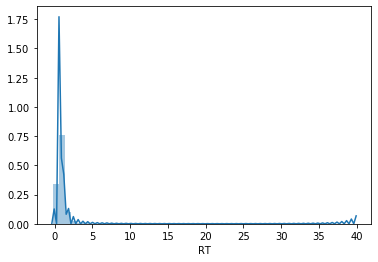

In [17]:
sns.axes_style('white') #RTs
sns.distplot(df.RT)

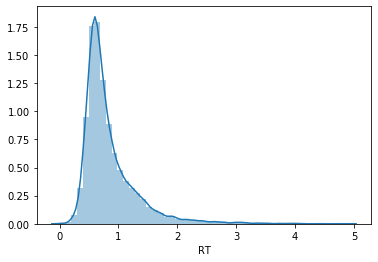

In [18]:
# RT after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 3) #1.5 responses larger 1.5 were removed
sns.distplot(df.RT)

#### Plots experiment 1

<font size="4"> _Porcentaje de respuesta a un estímulo en función de la decision variable y el número de repeticiones._

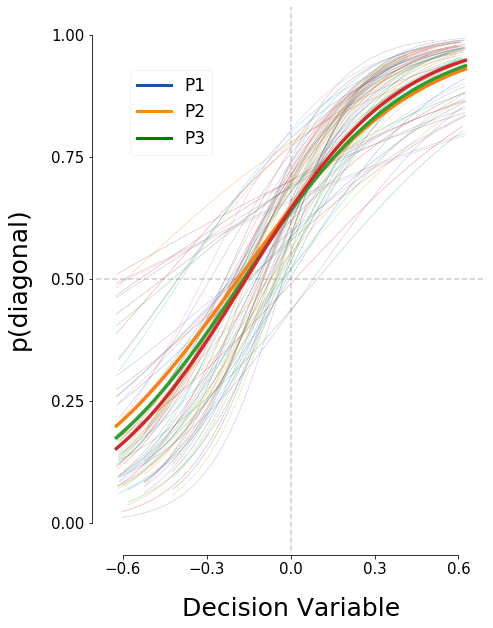

In [19]:
# Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?
# Puede que le tengas que dar a run dos veces para que te haga bien el plot, los colores a lo mejor te salen mal
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
plt.savefig('deci_x_nrep.png',bbox_inches='tight')

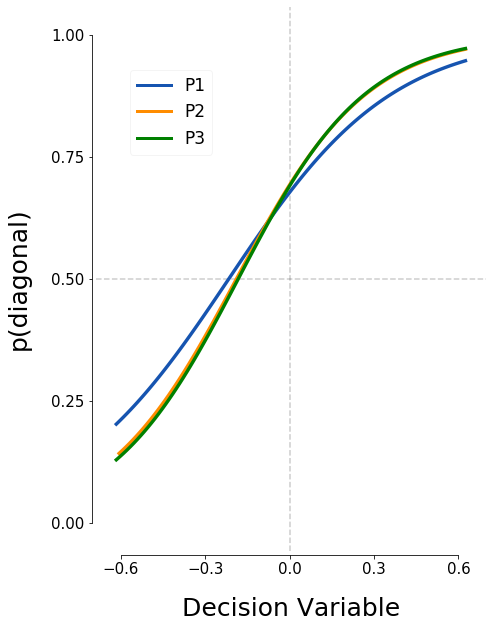

In [20]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
cosa=df.loc[df.npar == 1,:]
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=cosa.loc[cosa.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)

In [21]:
formula = "deci ~ rDV"
probando_df = cosa.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
probando_df.reset_index(inplace = True)
probando_df.head(14)

npar  nrep  level_2  intercept    weight       PSE
0   1.0     0        0   0.742215  3.427240 -0.216564
1   1.0     1        0   0.814154  4.301049 -0.189292
2   1.0     2        0   0.803716  4.395120 -0.182865

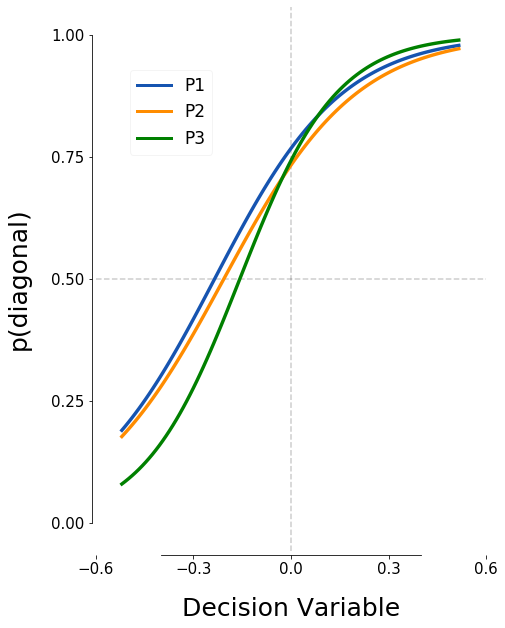

In [22]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
cosa2=df.loc[df.npar == 6,:]
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=cosa2.loc[cosa2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)

In [23]:
formula = "deci ~ rDV"
probando_df2 = cosa2.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
probando_df2.reset_index(inplace = True)
probando_df2.head(14)

npar  nrep  level_2  intercept    weight       PSE
0   6.0     0        0   1.192944  5.088686 -0.234431
1   6.0     1        0   1.009535  4.899038 -0.206068
2   6.0     2        0   1.057039  6.736313 -0.156916

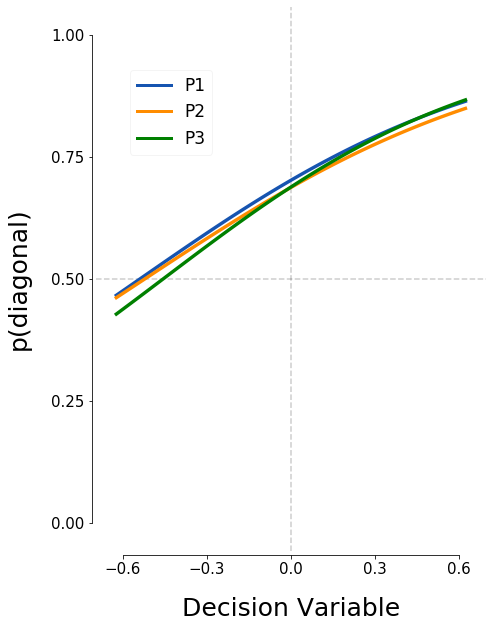

In [24]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
cosa3=df.loc[df.npar == 25,:]
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=cosa3.loc[cosa3.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)

In [25]:
formula = "deci ~ rDV"
probando_df3 = cosa3.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
probando_df3.reset_index(inplace = True)
probando_df3.head(14)

npar  nrep  level_2  intercept    weight       PSE
0  25.0     0        0   0.857949  1.590178 -0.539530
1  25.0     1        0   0.788566  1.510238 -0.522147
2  25.0     2        0   0.792347  1.734818 -0.456732

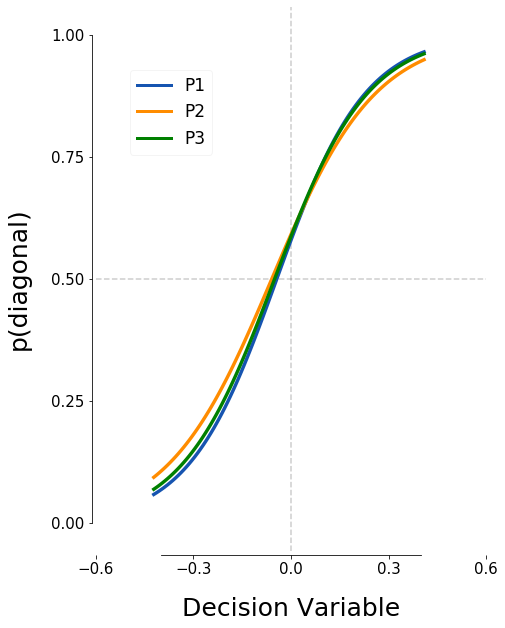

In [26]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
cosa4=df.loc[df.npar == 30,:]
for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=cosa4.loc[cosa4.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'lw':3.4}); #mean by participant
sns.despine(offset=4, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)

In [27]:
formula = "deci ~ rDV"
probando_df4 = cosa4.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
probando_df4.reset_index(inplace = True)
probando_df4.head(14)

npar  nrep  level_2  intercept    weight       PSE
0  30.0     0        0   0.317779  7.344525 -0.043268
1  30.0     1        0   0.367414  6.257693 -0.058714
2  30.0     2        0   0.350044  6.996045 -0.050035

In [28]:
# make the model to estimate if there are statistical differences at the slope (weight) or the intercept of the last plot
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula)
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

npar  nrep  level_2  intercept    weight       PSE
76  29.0     1        0   0.547466  4.787329 -0.114357
77  29.0     2        0   0.918974  4.749942 -0.193471
78  30.0     0        0   0.317779  7.344525 -0.043268
79  30.0     1        0   0.367414  6.257693 -0.058714
80  30.0     2        0   0.350044  6.996045 -0.050035

In [29]:
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 0,:] # without pre_deci as a factor
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 1,:] # without pre_deci as a factor
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 2,:] # without pre_deci as a factor
print(np.mean(dat.weight))

3.880611273782244
4.145094651690497
4.577347174968952


In [30]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)
#Alexis, el W-spher es el p-value de sphericity? Porque si es así, no hay que hacer la corrección

Source         SS  DF        MS          F     p-unc  p-GG-corr       np2  \
0   nrep   6.680112   2  3.340056  12.212524  0.000045   0.000103  0.319595   
1  Error  14.221704  52  0.273494        NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.885455       True  0.870636  0.176995  
1       NaN        NaN       NaN       NaN

__AQUI FALTA:__

Plotear los parametros bias y weight en diferentes figuras, media del grupo y de cada sujeto para condicion. Adenás faltarían los post-hoc t-tests porque sabemos que hay un main efecto de repeticion para weights, pero no sabemos que lo esta causando. El pinguin creo que te lo hace todo al correr el anova. Además también te da valores como el tamaño del efecto, bayes factor, etc.

In [31]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 
#he ajustado los p-value con bonferroni y he puesto one-sided porque en nuestras hipótesis a más repes, más efecto, el effect size con eta^2

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.671619  26.0  two-sided  0.106594   
1     nrep  0  2    True        True -4.630703  26.0  two-sided  0.000089   
2     nrep  1  2    True        True -3.775923  26.0  two-sided  0.000836   

     p-corr p-adjust     BF10     cohen  
0  0.319782     bonf    0.694 -0.182036  
1  0.000267     bonf  294.011 -0.465816  
2  0.002509     bonf   39.864 -0.272053

In [32]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.015701   2  0.007850  0.449761  0.640238   0.639228  0.017004   
1  Error  0.907647  52  0.017455       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.994771       True  0.994744  0.936246  
1       NaN        NaN       NaN       NaN

In [33]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'PSE', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc  p-GG-corr       np2  \
0   nrep  0.009026   2  0.004513  4.299747  0.018702   0.021581  0.141907   
1  Error  0.054580  52  0.001050       NaN       NaN        NaN       NaN   

        eps sphericity      W-spher  p-spher  
0  0.924295       True  2962.962187      1.0  
1       NaN        NaN          NaN      NaN

In [34]:
pg.pairwise_ttests(dv='PSE', within='nrep', subject='npar', padjust='bonf', tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.785834  26.0  two-sided  0.085796   
1     nrep  0  2    True        True -2.708191  26.0  two-sided  0.011803   
2     nrep  1  2    True        True -1.136442  26.0  two-sided  0.266138   

     p-corr p-adjust   BF10     cohen  
0  0.257388     bonf  0.818 -0.105258  
1  0.035408     bonf  4.056 -0.153605  
2  0.798415     bonf  0.365 -0.056382

__Cosas que faltan y ahora están__
Plotear los parametros bias y weight en diferentes figuras

<font size="3"> _Weight y bias ploteados en diferentes figuras_

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

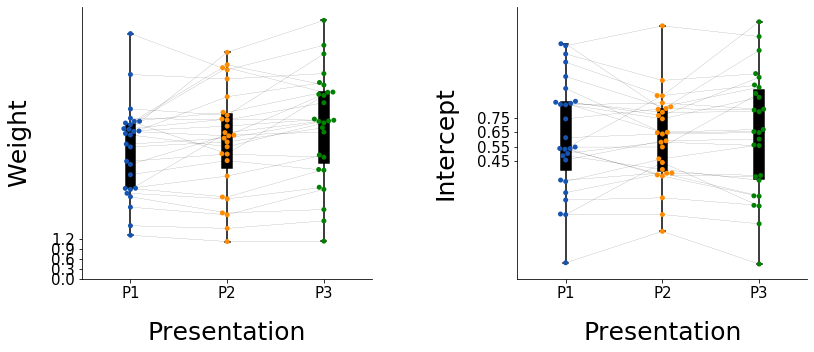

In [35]:
plt.subplots(ncols=2, figsize=(13, 5))
plt.subplots_adjust(wspace = 0.5)
mycol = ['#1654B0', "darkorange", "g"]
sns.set_palette(mycol)

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
ax1 = sns.swarmplot(x="nrep", y="weight", data=log_reg_nrep)
ax1 = sns.boxplot(x="nrep", y="weight", data=log_reg_nrep, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax1 = sns.lineplot(x="nrep", y="weight", data=log_reg_nrep, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax1, top=True);
plt.ylabel('Weight', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.3, step=0.3), fontsize = 15) 
plt.xlabel('Presentation', fontdict={'size':25}, labelpad=20); plt.xticks(fontsize = 15); ax1.set_xticklabels(['P1', 'P2', 'P3']);
plt.subplot(1, 2, 2) 
ax = sns.swarmplot(x="nrep", y="intercept", data=log_reg_nrep)
ax = sns.boxplot(x="nrep", y="intercept", data=log_reg_nrep, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax = sns.lineplot(x="nrep", y="intercept", data=log_reg_nrep, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax, top=True);
plt.ylabel('Intercept', fontsize = 25, labelpad=20); plt.yticks(np.arange(0.45, 0.81, step=0.1), fontsize = 15) 
plt.xlabel('Presentation', fontdict={'size':25}, labelpad=20); ax.set_xticklabels(['P1', 'P2', 'P3']); plt.xticks(fontsize = 15)

In [36]:
# previous plot with plotly (weight)

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['weight'],
    x=dat['nrep'],
    line=dict(
        color='#C6C2C2',
        width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [0,2,4,6,8], ticktext=['0', '2', '4', '6', '8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
fig.update_traces(showlegend=False)


fig['layout']['yaxis'].update(range=[-0.01, 8.02]);

fig.show()

In [37]:
# previous plot with plotly (intercept)

fig = go.Figure()

dat = log_reg_nrep
fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['intercept'],
    x=dat['nrep'],
    line=dict(
        color='#C6C2C2',
        width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    yaxis_title="Intercept",
    showlegend= False,
    font=dict(
        family="verdana",
        size=14,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [38]:
# previous plot with plotly (intercept)

fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep
fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['PSE'],
    x=dat['nrep'],
    line=dict(
        color='#C6C2C2',
        width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))




fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [-0.75,-.60, -.45,-.30,-.15, 0, .15], ticktext=['-0.75','-0.60', '-0.45','-0.30','-0.15', '0', '0.15'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
fig.update_traces(showlegend=False)


fig['layout']['yaxis'].update(range=[-0.752, 0.152]);

fig.show()

In [39]:
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 2,:]
pg.ttest(dat['PSE'], 0)

T  dof       tail     p-val           CI95%   cohen-d  \
T-test -5.711945   26  two-sided  0.000005  [-0.23, -0.11]  1.099264   

            BF10     power  
T-test  3904.371  0.999793

<font size="4"> _Porcentaje de respuesta a un estímulo en función de la decision variable y la decisión previa_

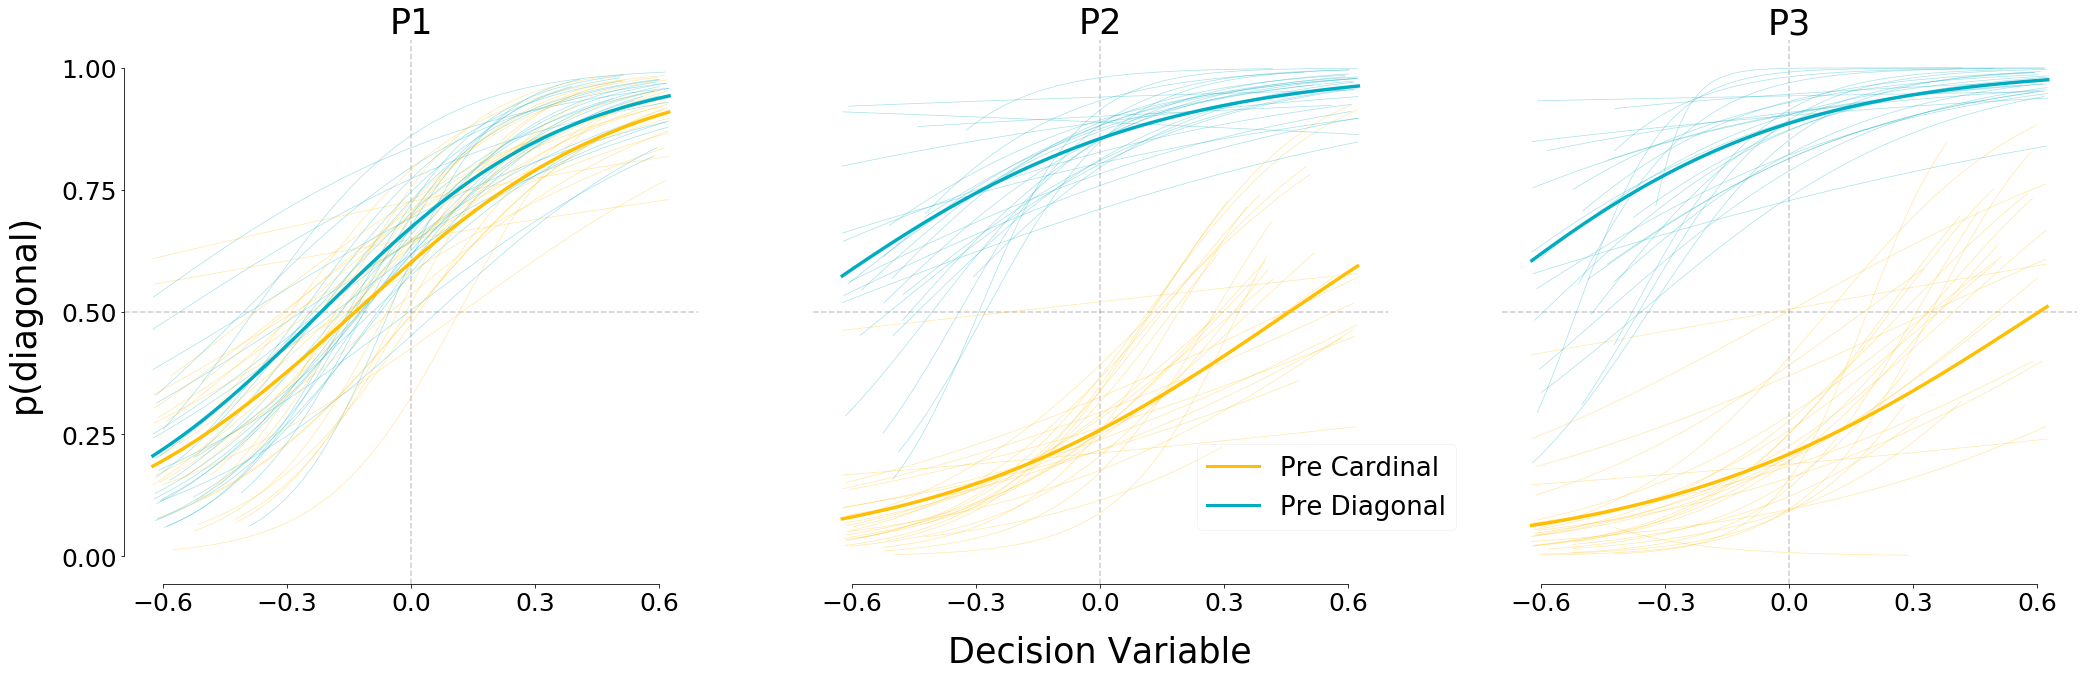

In [40]:
# Previous decisions biases the next response? Previous decision might bias how we estimate the next presentation
# of the trial. Let's find out if previous cardinal decision generates different probabilities to answer diagonal 
# compared with when they previously responded diagonal to equivalent sequences

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
plt.subplots(ncols=2, figsize=(35, 10))

#mycol = ["#ffbf00", '#70C1B3'] #cardinal #diagonal
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal

sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
plt.subplot(1, 3, 1)
ax0 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax0 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P1
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax0 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 0),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average for P1
    ax0 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 0),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = at lest 1 incorrect answers in this trial ; 1 = both previous answers correct
sns.despine(ax= ax0, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 35, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); plt.title('P1', fontsize= 35); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)

plt.subplot(1, 3, 2)
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P2
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 1),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #this for loop makes the plot for each participant for P2
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 1),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax1, offset=0, trim=True);
sns.despine(ax=ax1, left=True)
plt.xlabel('Decision Variable', fontdict={'size':35}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); plt.title('P2', fontsize= 35); plt.yticks([], []); plt.ylabel('', fontsize = 0)
plt.legend(lines, labels, bbox_to_anchor=(0.645,0.075), fontsize=26, framealpha= 0.2)


plt.subplot(1, 3, 3)
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average for P3
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #this for loop makes the plot for each participant for P3
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
#sns.despine(left=True);
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True)
plt.title('P3', fontsize=35); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); plt.yticks([], []); plt.xlabel(' ', fontsize = 0); plt.ylabel('', fontsize = 0)
#sns.despine(ax=ax, right=True, left=True)
plt.savefig('predeci.png')

Text(0, 0.5, '')

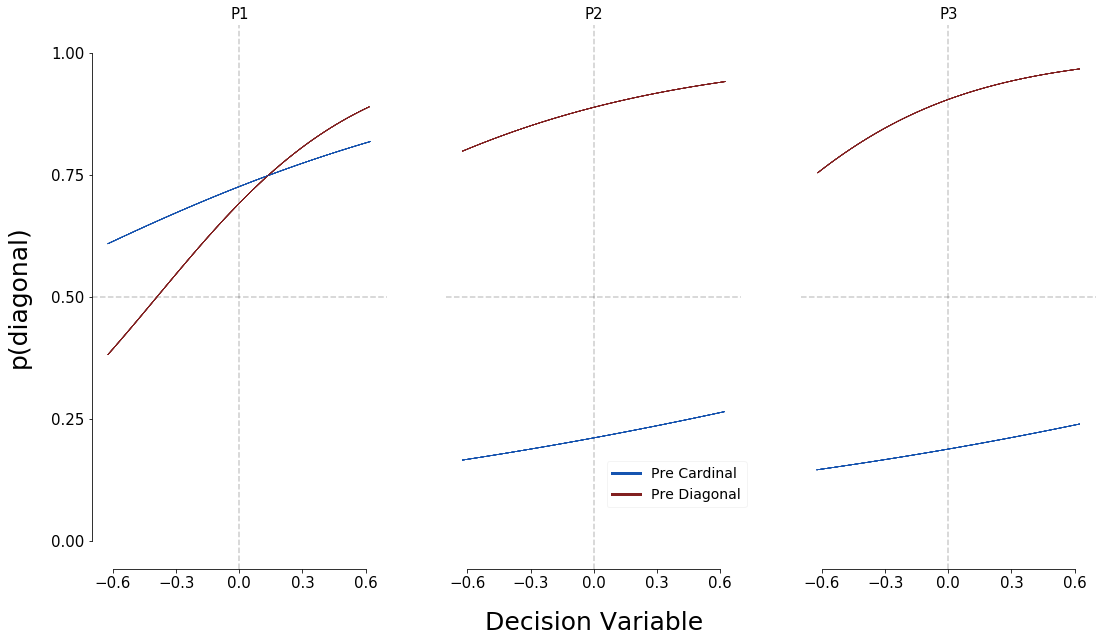

In [41]:
pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
plt.subplots(ncols=2, figsize=(18, 10))
mycol = ["#1654B0", "#822020"]
sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
plt.subplot(1, 3, 1)
ax0 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax0 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P1
    df2=df.loc[df.npar == 25,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax0 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 0),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax0, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15); plt.title('P1', fontsize= 15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)

plt.subplot(1, 3, 2)
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P2
    df2=df.loc[df.npar == 25,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 1),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax1, offset=0, trim=True);
sns.despine(ax=ax1, left=True)
plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.title('P2', fontsize= 15); plt.yticks([], []); plt.ylabel('', fontsize = 0)
plt.legend(lines, labels, bbox_to_anchor=(0.52,0.1), fontsize=14, framealpha= 0.2)


plt.subplot(1, 3, 3)
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #this for loop makes the plot for each participant for P3
    df2=df.loc[df.npar == 25,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
#sns.despine(left=True);
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True)
plt.title('P3', fontsize=15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.yticks([], []); plt.xlabel(' ', fontsize = 0); plt.ylabel('', fontsize = 0)
#sns.despine(ax=ax, right=True, left=True)
#plt.savefig('predeci.png')

In [42]:
# The differences in the previous plot are significant?
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(6)

npar  nrep  pre_deci  level_3  intercept    weight       PSE
0   1.0     0         0        0   0.558344  3.154904 -0.176977
1   1.0     0         1        0   0.855172  3.635940 -0.235200
2   1.0     1         0        0  -0.556693  3.870418  0.143833
3   1.0     1         1        0   1.782901  3.266181 -0.545867
4   1.0     2         0        0  -0.902185  2.658734  0.339329
5   1.0     2         1        0   1.919323  3.223525 -0.595411

In [43]:
#print(log_reg_preDeci.to_string())
#npar 8 had an unusual PSE, we removed him for this analysis

In [44]:
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 0,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()
#print(np.amax(dat.PSE))
#print(np.amin(dat.PSE))
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 1,:] # with pre_deci as a factor
print()
print(np.mean(dat.weight))
print()
#print(np.amax(dat.PSE))
#print(np.amin(dat.PSE))
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 2,:] # with pre_deci as a factor
print()
print(np.mean(dat.weight))
print()
#print(np.amax(dat.PSE))
#print(np.amin(dat.PSE))

3.943590431053826


3.130119484938805


3.4843211765648467



<font size="3"> ANOVAs y post-hoc t-test

In [45]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)
#Alexis, el W-spher es el p-value de sphericity? Porque si es así, no hay que hacer la corrección. Cogería el valor de 'p-unc', no?

Source         SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  17.966197      2     52  8.983099  6.503004  0.003015   
1         pre_deci   2.459921      1     26  2.459921  0.337826  0.566092   
2  nrep * pre_deci   6.446002      2     52  3.223001  0.649701  0.526388   

   p-GG-corr       np2       eps  
0   0.006809  0.200074  0.763511  
1   0.566092  0.012827  1.000000  
2   0.466070  0.024379  0.656333

In [46]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition

pg.pairwise_ttests(dv='weight', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast nrep  A  B Paired  Parametric         T   dof       Tail  \
0             nrep    -  0  1   True        True  3.804053  26.0  two-sided   
1             nrep    -  0  2   True        True  2.666178  26.0  two-sided   
2             nrep    -  1  2   True        True -1.267557  26.0  two-sided   
3         pre_deci    -  0  1   True        True -0.581228  26.0  two-sided   
4  nrep * pre_deci    0  0  1   True        True -0.951462  26.0  two-sided   
5  nrep * pre_deci    1  0  1   True        True  0.611889  26.0  two-sided   
6  nrep * pre_deci    2  0  1   True        True -0.715940  26.0  two-sided   

      p-unc    p-corr p-adjust    BF10     cohen  
0  0.000778  0.002333     bonf  42.505  0.565897  
1  0.013017  0.039051     bonf   3.736  0.305095  
2  0.216191  0.648574     bonf   0.419 -0.228770  
3  0.566092       NaN      NaN   0.238 -0.142376  
4  0.350132  1.000000     bonf   0.307 -0.166633  
5  0.545925  1.000000     bonf   0.242  0.136732  
6  0.480409  1.000000     bonf   0.258 -0.235252

In [47]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
#dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 0] #cardinal
#dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1] #diagonal
#pg.pairwise_ttests(dv='weight', within= ['nrep'], subject='npar', padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

In [48]:
#Checking statistical differences in Intercept between the number of repetitions & previous decision
pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0             nrep    0.987272      2     52    0.493636    2.672178   
1         pre_deci  221.193906      1     26  221.193906  154.586434   
2  nrep * pre_deci   95.241706      2     52   47.620853   85.068851   

          p-unc     p-GG-corr       np2       eps  
0  7.858311e-02  8.221079e-02  0.093198  0.942175  
1  1.901992e-12  1.901992e-12  0.856025  1.000000  
2  4.017055e-17  2.248536e-11  0.765911  0.613415

In [49]:
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe
pg.rm_anova(dv = 'PSE', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS          F     p-unc  \
0             nrep   1.423181      2     52   0.711590   0.802917  0.453496   
1         pre_deci  35.723772      1     26  35.723772  21.888779  0.000079   
2  nrep * pre_deci  19.139836      2     52   9.569918   9.349854  0.000340   

   p-GG-corr       np2       eps  
0   0.453466  0.029956  0.999717  
1   0.000079  0.457075  1.000000  
2   0.000372  0.264495  0.982958

In [50]:
pg.rm_anova(dv = 'PSE', within = ['nrep', 'pre_deci'], subject = 'npar', data=log_reg_preDeci, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS          F     p-unc  \
0             nrep   1.423181      2     52   0.711590   0.802917  0.453496   
1         pre_deci  35.723772      1     26  35.723772  21.888779  0.000079   
2  nrep * pre_deci  19.139836      2     52   9.569918   9.349854  0.000340   

   p-GG-corr       np2       eps  
0   0.453466  0.029956  0.999717  
1   0.000079  0.457075  1.000000  
2   0.000372  0.264495  0.982958

In [51]:
pg.pairwise_ttests(dv='PSE', within= ['pre_deci', 'nrep'], subject='npar', padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

Contrast pre_deci  A  B Paired  Parametric         T   dof  \
0         pre_deci        -  0  1   True        True  4.678544  26.0   
1             nrep        -  0  1   True        True -0.282102  26.0   
2             nrep        -  0  2   True        True  0.931011  26.0   
3             nrep        -  1  2   True        True  1.201172  26.0   
4  pre_deci * nrep        0  0  1   True        True -4.937436  26.0   
5  pre_deci * nrep        0  0  2   True        True -4.193148  26.0   
6  pre_deci * nrep        0  1  2   True        True  0.152242  26.0   
7  pre_deci * nrep        1  0  1   True        True  1.640282  26.0   
8  pre_deci * nrep        1  0  2   True        True  2.819131  26.0   
9  pre_deci * nrep        1  1  2   True        True  1.126972  26.0   

        Tail     p-unc    p-corr p-adjust     BF10     cohen  
0  two-sided  0.000079       NaN      NaN  329.486  1.235830  
1  two-sided  0.780099  1.000000     bonf    0.211 -0.075189  
2  two-sided  0.360413  1.000000     bonf    0.302  0.246956  
3  two-sided  0.240513  0.721539     bonf     0.39  0.233577  
4  two-sided  0.000040  0.000238     bonf  611.452 -1.547917  
5  two-sided  0.000282  0.001692     bonf  104.576 -1.327330  
6  two-sided  0.880172  1.000000     bonf    0.206  0.020806  
7  two-sided  0.112991  0.677947     bonf    0.665  0.440853  
8  two-sided  0.009087  0.054524     bonf    5.055  0.747797  
9  two-sided  0.270048  1.000000     bonf    0.361  0.236383

In [52]:
dat =log_reg_preDeci.loc[log_reg_preDeci.nrep == 0]
pg.pairwise_ttests(dv='PSE', within= ['pre_deci'], subject='npar', padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0  pre_deci  0  1    True        True -0.071054  26.0  two-sided  0.943898   

    BF10     cohen  
0  0.204 -0.013457

In [53]:
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1]
pg.ttest(dat['PSE'], 0)

T  dof       tail     p-val           CI95%   cohen-d    BF10  \
T-test -4.242337   80  two-sided  0.000059  [-1.05, -0.38]  0.471371  322.25   

           power  
T-test  0.987157

In [54]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
#dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 0] #cardinal
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1] #diagonal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True  1.640282  26.0  two-sided  0.112991   
1     nrep  0  2    True        True  2.819131  26.0  two-sided  0.009087   
2     nrep  1  2    True        True  1.126972  26.0  two-sided  0.270048   

     p-corr p-adjust   BF10     cohen  
0  0.338973     bonf  0.665  0.440853  
1  0.027262     bonf  5.055  0.747797  
2  0.810145     bonf  0.361  0.236383

In [55]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=log_reg_preDeci) 

Contrast  A  B  Paired  Parametric          T   dof       Tail  \
0      nrep  0  1    True        True   2.467831  26.0  two-sided   
1      nrep  0  2    True        True   1.640593  26.0  two-sided   
2      nrep  1  2    True        True  -0.604757  26.0  two-sided   
3  pre_deci  0  1    True        True -12.433279  26.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  2.049246e-02  0.061477     bonf      2.563  0.571394  
1  1.129260e-01  0.338778     bonf      0.665  0.290545  
2  5.505821e-01  1.000000     bonf      0.241 -0.136975  
3  1.901992e-12       NaN      NaN  4.217e+09 -4.038774

In [56]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
#dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 0] #cardinal
dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci == 1] #diagonal
pg.pairwise_ttests(dv='intercept', within= ['nrep'], subject='npar', padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail         p-unc  \
0     nrep  0  1    True        True -8.402908  26.0  two-sided  6.954134e-09   
1     nrep  0  2    True        True -7.240986  26.0  two-sided  1.087870e-07   
2     nrep  1  2    True        True -3.220693  26.0  two-sided  3.422441e-03   

         p-corr p-adjust       BF10     cohen  
0  2.086240e-08     bonf  1.819e+06 -2.203732  
1  3.263610e-07     bonf  1.392e+05 -1.778385  
2  1.026732e-02     bonf     11.648 -0.525786

<font size="4"> _Porcentaje de bias generado por la primera y la seguna presentación en la úlitma presentación del estímulo_

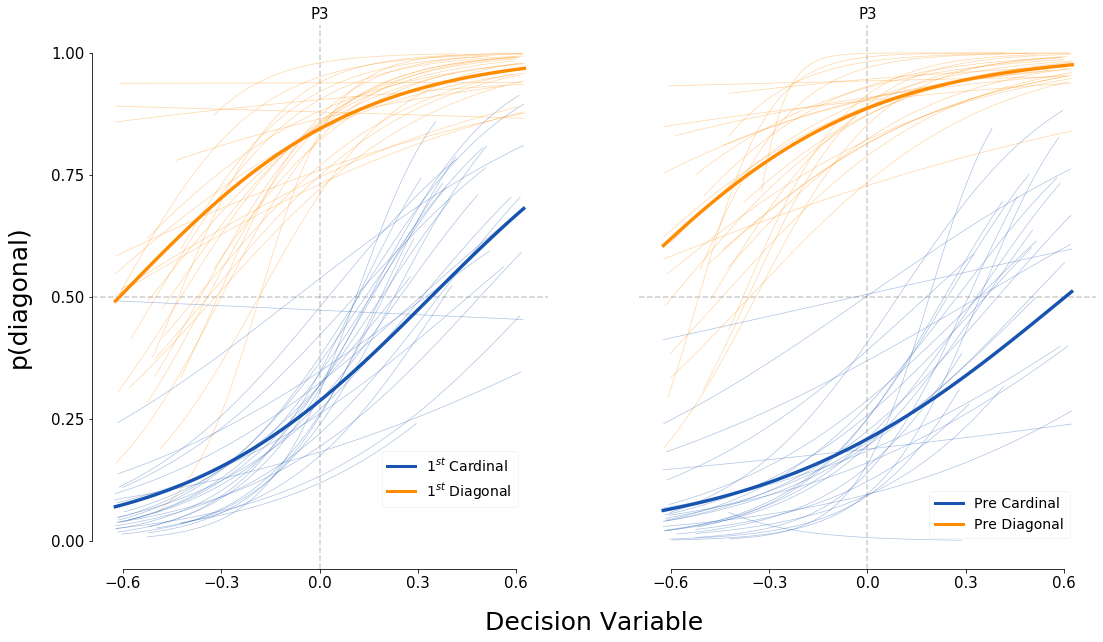

In [57]:
# First decisions biases the response at the 3rd presentation? If participants respond diagonal in the first presentation,
# they would be also biased to answer diagonal in the last presentation? 

pre_deci_labels = np.unique(df.pre_deci)     #pre_deci
fig = plt.subplots(ncols=2, figsize=(18, 10))
mycol = ["#1654B0", "darkorange"]
#mycol = ['rgba(162, 222, 208, 1)', 'rgba(27, 163, 156, 1)']
sns.set_palette(mycol)
#plt.suptitle("DV for previous decision for the different repetitions", fontsize=20)
fig = plt.subplot(1, 2, 1) #if participants decision at P1 biases the response at P3
ax1 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax1 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for i in npar_labels: #to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax1 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.first_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
for cell in pre_deci_labels: #to compute the average by all the sample
    ax1 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.first_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = at lest 1 incorrect answers in this trial ; 1 = both previous answers correct
sns.despine(ax= ax1, offset=0, trim=True);
plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15); plt.title('P3', fontsize= 15); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.xlabel(' ', fontsize = 0)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['$1^{st}$ Cardinal', '$1^{st}$ Diagonal']; #plt.legend(lines, labels, bbox_to_anchor=(0.49,0.15), fontsize=14, framealpha= 0.2)
plt.legend(lines, labels, bbox_to_anchor=(0.62,0.1), fontsize=14, framealpha= 0.2); plt.xlabel('Decision Variable', x=1.1, fontdict={'size':25}, labelpad=20); 

fig = plt.subplot(1, 2, 2) #if participants decision at P1 biases the response at P3
ax2 = plt.axvline(0, ls='--', color= 'black', alpha = 0.2)
ax2 = plt.axhline(0.5, ls='--', color= 'black', alpha = 0.2)
for cell in pre_deci_labels: #to compute the average by all the sample
    ax2 = sns.regplot(x="rDV", y="deci",  data=df.loc[(df.pre_deci == cell) & (df.nrep == 2),:],
           logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell, truncate=True, line_kws={'lw':3.4}); # O = changes in the previous decision ; 1 = consistent in both decisions  
for i in npar_labels: #to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in pre_deci_labels:
        sns.set_palette(mycol)
        ax2 = sns.regplot(x="rDV", y="deci",  data=df2.loc[(df2.pre_deci == cell) & (df2.nrep == 2),:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7});
sns.despine(ax= ax2, offset=0, trim=True);
sns.despine(ax=ax2, left=True);
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Pre Cardinal', 'Pre Diagonal']; plt.title('P3', fontsize= 15);
plt.legend(lines, labels, bbox_to_anchor=(0.62,0.1), fontsize=14, framealpha= 0.2); plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15); plt.yticks([], []); plt.ylabel('', fontsize = 0); plt.xlabel('', x=1.1, fontdict={'size':1}, labelpad=1); 

#plt.savefig('first_deci_pre_deci_afect_3rdpresenation.png')

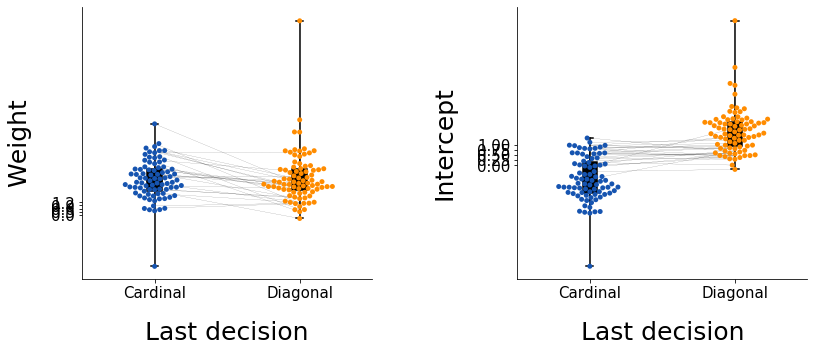

In [58]:
plt.subplots(ncols=2, figsize=(13, 5))
plt.subplots_adjust(wspace = 0.5)

mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
#plt.subplot(figsize=(2,5))
ax1 = sns.swarmplot(x="pre_deci", y="weight", data=log_reg_preDeci)
ax1 = sns.boxplot(x="pre_deci", y="weight", data=log_reg_preDeci, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax1 = sns.lineplot(x="pre_deci", y="weight", data=log_reg_preDeci, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax1, top=True);
plt.ylabel('Weight', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.3, step=0.3), fontsize = 15) 
plt.xlabel('Last decision', fontdict={'size':25}, labelpad=20); plt.xticks(fontsize = 15); ax1.set_xticklabels(['Cardinal', 'Diagonal']);

plt.subplot(1, 2, 2) 
ax = sns.swarmplot(x="pre_deci", y="intercept", data=log_reg_preDeci)
ax = sns.boxplot(x="pre_deci", y="intercept", data=log_reg_preDeci, whis=np.inf, width = 0.1, color = "black") # , boxprops=dict(alpha=.3)
ax = sns.lineplot(x="pre_deci", y="intercept", data=log_reg_preDeci, units="npar",  estimator=None, lw = 0.1, color = "black")
sns.despine(ax=ax, top=True);
plt.ylabel('Intercept', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Last decision', fontdict={'size':25}, labelpad=20); plt.xticks(fontsize = 15); ax.set_xticklabels(['Cardinal', 'Diagonal']);

In [59]:
#previous plot with plotly

# previous plot with plotly (weight)

# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
dat = log_reg_preDeci

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['weight'],
    x=dat['pre_deci'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(162, 222, 208, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(27, 163, 156, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))


fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Cardinal', 'Diagonal'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    title='Previous response',
    yaxis_title="Weight",
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [60]:
#by number of repetitions
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=  "#ffbf00"  #'rgba(162, 222, 208, 1)'
))
#0A4893

#mycol = ["#ffbf00", '#70C1B3'] #cardinal #diagonal
dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Diagonal', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color= '#00acc1' #'#70C1B3'     #'rgba(27, 163, 156, 1)'
))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.update_layout(
    boxmode='group', 
    #boxgroupgap=0.5 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
#fig.update_yaxes(tickvals= [-0.75,-.60, -.45,-.30,-.15, 0, .15], ticktext=['-0.75','-0.60', '-0.45','-0.30','-0.15', '0', '0.15'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)


fig['layout']['yaxis'].update(range=[-10.05, 20.05]);

fig.show()

In [61]:
#previous plot with plotly

# previous plot with plotly (weight)

# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
dat = log_reg_preDeci

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['intercept'],
    x=dat['pre_deci'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(162, 222, 208, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(27, 163, 156, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))


fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Cardinal', 'Diagonal'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    yaxis_title="Intercept",
    title = 'Previous response',
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)


fig.update_traces(showlegend=True)

fig.show()

In [62]:
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
dat = log_reg_preDeci

fig.add_trace(
    go.Scatter( #lineplot for different category
    y=dat['PSE'],
    x=dat['pre_deci'],
    line=dict(
        color='#C6C2C2',
        width=0.2)))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==0,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(162, 222, 208, 1)',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))

dat = log_reg_preDeci.loc[log_reg_preDeci.pre_deci ==1,:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['pre_deci'],
    boxpoints='all',
    marker_color = 'rgba(27, 163, 156, 1)', 
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    ))


fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Cardinal', 'Diagonal'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'),
    yaxis_title="PSE",
    title = 'Previous response',
    showlegend= False,
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)


fig.update_traces(showlegend=True)

fig.show()

In [63]:
#by number of repetitions
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))
#0A4893


dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Diagonal', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='rgba(27, 163, 156, 1)'
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.show()

In [64]:
#by number of repetitions
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color="#ffbf00"))




dat = log_reg_preDeci.loc[(log_reg_preDeci.pre_deci == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Diagonal', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#00acc1'   #'#70C1B3'
))


fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.update_layout(
    boxmode='group', 
    #boxgroupgap=0.5 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
#fig.update_yaxes(tickvals= [-0.75,-.60, -.45,-.30,-.15, 0, .15], ticktext=['-0.75','-0.60', '-0.45','-0.30','-0.15', '0', '0.15'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)

fig['layout']['yaxis'].update(range=[-2.01, 2.01]);

fig.show()

In [65]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ rDV"
df2 = df.loc[(df.nrep == 2) & (df.ntrial != 0),:]
log_reg_pre_first = df2.groupby(['npar', 'first_deci']).apply(log_reg_fit, formula) 
log_reg_pre_first.reset_index(inplace = True)
log_reg_pre_first.head(65)

npar  first_deci  level_2  intercept    weight       PSE
0    1.0           0        0  -0.593598  3.798195  0.156284
1    1.0           1        0   1.704177  3.421685 -0.498052
2    2.0           0        0  -1.554552  4.088709  0.380206
3    2.0           1        0   1.667366  5.313248 -0.313813
4    3.0           0        0  -0.458487  4.231595  0.108349
5    3.0           1        0   2.468143  4.811076 -0.513013
6    4.0           0        0  -0.682537  4.927134  0.138526
7    4.0           1        0   1.147059  3.317269 -0.345784
8    5.0           0        0  -1.188645  5.654481  0.210213
9    5.0           1        0   1.602311  8.773534 -0.182630
10   6.0           0        0  -0.659992  6.522232  0.101191
11   6.0           1        0   1.876013  6.026301 -0.311304
12   7.0           0        0  -0.955239  3.234657  0.295314
13   7.0           1        0   0.972657  2.876466 -0.338143
14   9.0           0        0  -0.368564  2.944156  0.125185
15   9.0           1        0   1.512567  5.244752 -0.288396
16  10.0           0        0  -0.773068  2.513008  0.307627
17  10.0           1        0   1.865662  4.425501 -0.421571
18  11.0           0        0  -1.036523  3.854206  0.268933
19  11.0           1        0   1.122305  3.062249 -0.366497
20  13.0           0        0  -0.678093  4.571622  0.148327
21  13.0           1        0   0.882959  4.688474 -0.188325
22  14.0           0        0  -1.917050  2.568898  0.746254
23  14.0           1        0   1.961608 -0.265810  7.379743
24  16.0           0        0  -0.685784  3.637229  0.188546
25  16.0           1        0   1.890615  5.384291 -0.351135
26  17.0           0        0  -0.806384  7.366916  0.109460
27  17.0           1        0   1.827575  1.319903 -1.384628
28  18.0           0        0  -1.139317  6.167215  0.184738
29  18.0           1        0   2.530144  5.082116 -0.497853
30  19.0           0        0  -0.093473 -0.150150 -0.622530
31  19.0           1        0   1.040164  1.668035 -0.623586
32  20.0           0        0  -0.763561  5.098321  0.149767
33  20.0           1        0   2.770223  0.326509 -8.484367
34  21.0           0        0   0.157807  2.035428 -0.077530
35  21.0           1        0   1.718248  2.593320 -0.662567
36  22.0           0        0  -0.664660  2.000097  0.332314
37  22.0           1        0   3.027049  4.727117 -0.640358
38  23.0           0        0  -0.805905  3.805034  0.211800
39  23.0           1        0   2.725888  6.152644 -0.443043
40  24.0           0        0  -1.976357  3.005165  0.657654
41  24.0           1        0   3.817153  6.209573 -0.614721
42  25.0           0        0  -1.526571  1.290679  1.182766
43  25.0           1        0   2.223174  0.704054 -3.157674
44  26.0           0        0  -1.080609  2.124552  0.508629
45  26.0           1        0   1.987733  2.833226 -0.701579
46  27.0           0        0  -1.236498  3.403449  0.363307
47  27.0           1        0   1.175597  1.214675 -0.967829
48  28.0           0        0  -1.389304  3.073626  0.452008
49  28.0           1        0   1.071829  1.734461 -0.617961
50  29.0           0        0  -0.165392  3.286677  0.050322
51  29.0           1        0   1.764500  3.846060 -0.458781
52  30.0           0        0  -1.027627  5.144565  0.199750
53  30.0           1        0   1.508913  3.914054 -0.385512

<font size="3"> t-test para la influencia de la 1a presentación en la última

__Que significan los resultados en general? t.tests. Tendría que haber interaccion en el anova tambien, no? es decir, meter pre_deci en el analisis__

**Respuesta:** He cambiado los anova por t test, lo único que no puedo es incluir los pre_deci. Peta la función log_reg_pre_first si la meto

In [66]:
#Checking statistical differences in Weight between the number of repetitions & the first decision
#pg.rm_anova(dv = 'weight', within = ['first_deci'], subject = 'npar', data=log_reg_pre_first, detailed = True, correction = True)
pg.pairwise_ttests(dv='weight', within= ['first_deci'], subject='npar', padjust='none', tail='one-sided', interaction=False, effsize = 'eta-square', data=log_reg_pre_first) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0  first_deci  0  1    True        True  0.067742  26.0  one-sided  0.473255   

    BF10  eta-square  
0  0.408     0.00006

In [67]:
#Checking statistical differences in Intercept between the number of repetitions & the first decision
#pg.rm_anova(dv = 'intercept', within = ['first_deci'], subject = 'npar', data=log_reg_pre_first, detailed = True, correction = True)
pg.pairwise_ttests(dv='intercept', within= ['first_deci'], subject='npar', padjust='none', tail='one-sided', interaction=False, effsize = 'eta-square', data=log_reg_pre_first) 

Contrast  A  B  Paired  Parametric          T   dof       Tail  \
0  first_deci  0  1    True        True -14.766739  26.0  one-sided   

          p-unc       BF10  eta-square  
0  1.858466e-14  3.565e+11    0.833529

<font size="4"> _Weight y bias en función de si la secuencia era esperada por el participante_
    
    Una secuencia era esperada cuando la respuesta previa del participante era la misma que el estímulo que se presentaba ahora

In [68]:
#sns.lmplot(x="dv", y="deci", hue = "expected", data=dflong.loc[(dflong.nrep == 0) & (dflong.cond == 'C'),:], logistic=True, y_jitter=.01, scatter_kws={'alpha':0.5}, ci=True, n_boot=1, truncate=True);


In [69]:
#sns.lmplot(x="dv", y="deci", hue = "expected", data=dflong.loc[(dflong.nrep == 0) & (dflong.cond == 'D'),:], logistic=True, y_jitter=.01, scatter_kws={'alpha':0.5}, ci=True, n_boot=1, truncate=True);

In [70]:
#sns.lmplot(x="dv", y="deci", hue = "expected", data=dflong.loc[(dflong.nrep == 1) & (dflong.cond == 'C'),:], logistic=True, y_jitter=.01, scatter_kws={'alpha':0.5}, ci=True, n_boot=1, truncate=True);

In [71]:
#sns.lmplot(x="dv", y="deci", hue = "expected", data=dflong.loc[(dflong.nrep == 1) & (dflong.cond == 'D'),:], logistic=True, y_jitter=.01, scatter_kws={'alpha':0.5}, ci=True, n_boot=1, truncate=True);

In [72]:
#sns.lmplot(x="dv", y="deci", hue = "expected", data=dflong.loc[(dflong.nrep == 2) & (dflong.cond == 'C'),:], logistic=True, y_jitter=.01, scatter_kws={'alpha':0.5}, ci=True, n_boot=1, truncate=True);

In [73]:
#sns.lmplot(x="dv", y="deci", hue = "expected", data=dflong.loc[(dflong.nrep == 2) & (dflong.cond == 'D'),:], logistic=True, y_jitter=.01, scatter_kws={'alpha':0.5}, ci=True, n_boot=1, truncate=True);

In [74]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ dv"
log_reg_expect = dflong.groupby(['npar', 'expected', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_expect.reset_index(inplace = True)
log_reg_expect.tail(5)

npar expected  nrep cond  level_4  intercept    weight        PSE
319  30.0        U     0    D        0   0.508756  0.138298  -3.678691
320  30.0        U     1    C        0   1.327814 -0.080175  16.561350
321  30.0        U     1    D        0  -0.876926 -0.247347  -3.545325
322  30.0        U     2    C        0   2.171406  0.762772  -2.846732
323  30.0        U     2    D        0  -1.797486  0.291268   6.171252

## Congruency between stimuli and previous decision and between stimuli and previous conditions

In [75]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ dv"
log_reg_cong_stim = dflong.groupby(['npar', 'cong_stim', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head()

npar cong_stim  nrep cond  level_4  intercept    weight       PSE
0   1.0         C     0    C        0   0.448252  0.718386 -0.623971
1   1.0         C     0    D        0   0.559921  1.246863 -0.449063
2   1.0         C     1    C        0  -0.556241  0.120265  4.625127
3   1.0         C     1    D        0   1.855426  0.550974 -3.367538
4   1.0         C     2    C        0  -0.400884  0.455135  0.880802

In [76]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)
#np.amax(log_reg_cong_stim.PSE)

npar cong_stim  nrep cond  level_4  intercept    weight       PSE
310  29.0         I     2    C        0   1.659279  0.205929 -8.057531
311  29.0         I     2    D        0   0.219398 -0.316641  0.692891
316  30.0         C     2    C        0  -0.271035  0.859457  0.315356
317  30.0         C     2    D        0   1.558173 -0.454822  3.425897
322  30.0         I     2    C        0   1.155355  0.632710 -1.826042
323  30.0         I     2    D        0  -0.405380 -0.146697 -2.763386

In [77]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))



dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], opacity = 0.8,
    x=dat['cong_stim'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=1) #2A88D4

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=1) #2A88D4



dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='  #ffbf00  '), row=1, col=2) #2A88D4

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_stim'], opacity = 1, 
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=2) #2A88D4



dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=3) #2A88D4

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=3) #2A88D4




fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
#fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

In [78]:
#log_reg_cong_stim = dflong.groupby(['npar', 'cong_stim', 'nrep', 'cond']).apply(log_reg_fit, formula) 
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F  \
0              nrep  4.759203      2     52  2.379601  21.224821   
1         cong_stim  0.917882      1     26  0.917882   3.132776   
2  nrep * cong_stim  0.839999      2     52  0.420000   3.473753   

          p-unc     p-GG-corr       np2       eps  
0  1.823386e-07  1.891001e-07  0.449442  0.997068  
1  8.846077e-02  8.846077e-02  0.107534  1.000000  
2  3.836944e-02  5.155181e-02  0.117859  0.776035

In [79]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  12.031346  26.0  two-sided   
1              nrep    -  0  2   True        True   8.452273  26.0  two-sided   
2              nrep    -  1  2   True        True  -0.660665  26.0  two-sided   
3         cong_stim    -  C  I   True        True  -0.347675  26.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True  -1.270335  26.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True   0.349615  26.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  -0.062927  26.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  3.956019e-12  1.186806e-11     bonf  2.104e+09  2.293140  
1  6.211641e-09  1.863492e-08     bonf  2.023e+06  1.887108  
2  5.146388e-01  1.000000e+00     bonf      0.249 -0.096050  
3  7.308829e-01           NaN      NaN      0.215 -0.092524  
4  2.152160e-01  6.456480e-01     bonf       0.42 -0.374860  
5  7.294435e-01  1.000000e+00     bonf      0.216  0.100081  
6  9.503058e-01  1.000000e+00     bonf      0.204 -0.016151

In [80]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc       np2  eps
0   cond  3.131115   1  3.131115  19.42534  0.000161  0.427632  1.0
1  Error  4.190866  26  0.161187       NaN       NaN       NaN  NaN

In [81]:
fig = go.Figure()

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.cong_stim == 'C') & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(27, 163, 156, 1)'))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.cong_stim == 'I') & (log_reg_cong_stim.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.cong_stim == 'C') & (log_reg_cong_stim.cond == 'D'),:] #congruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(102, 51, 153, 1)'))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.cong_stim == 'I') & (log_reg_cong_stim.cond == 'D'),:] #incongruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(148, 124, 176, 1)'))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    #title = 'Stimuli intercept by the congruency with previous mean array',
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Intercept by previous stimuli",
    font=dict(
        family="verdana",
        size=14,
        color="#54636D" #E6E4E4
))

fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        x=0.05,
        y=1.1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
fig.update_layout(legend_orientation="h")

fig.show()

In [82]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))



dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], opacity = 0.8,
    x=dat['cong_stim'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=1) #2A88D4

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=1) #2A88D4



dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='  #ffbf00  '), row=1, col=2) #2A88D4

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_stim'], opacity = 1, 
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=2) #2A88D4



dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=3) #2A88D4

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=10,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=3) #2A88D4




fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.5,-0.75, 0, 0.75, 1.5, 2.25, 3], ticktext=['-1.5','-0.75', '0', '0.75', '1.5' ,'2.25', '3'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.505, 3.015]); fig['layout']['yaxis2'].update(range=[-1.505, 3.015])
fig['layout']['yaxis3'].update(range=[-1.505, 3.015], )

fig.show()

In [83]:
#log_reg_cong_stim = dflong.groupby(['npar', 'cong_stim', 'nrep', 'cond']).apply(log_reg_fit, formula) 
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Source         SS  ddof1  ddof2         MS           F  \
0              nrep   0.196541      2     52   0.098271    2.580011   
1         cong_stim  70.556355      1     26  70.556355  351.730646   
2  nrep * cong_stim  28.576620      2     52  14.288310  184.526203   

          p-unc     p-GG-corr       np2       eps  
0  8.544466e-02  9.205119e-02  0.090273  0.896405  
1  1.247124e-16  1.247124e-16  0.931168  1.000000  
2  2.417391e-24  5.806268e-21  0.876500  0.846410

In [84]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.7062833896647344

In [85]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric          T   dof       Tail  \
0              nrep    -  0  1   True        True  -2.008832  26.0  two-sided   
1              nrep    -  0  2   True        True  -2.011860  26.0  two-sided   
2              nrep    -  1  2   True        True  -0.512335  26.0  two-sided   
3         cong_stim    -  C  I   True        True  18.754483  26.0  two-sided   
4  nrep * cong_stim    0  C  I   True        True   1.270172  26.0  two-sided   
5  nrep * cong_stim    1  C  I   True        True  22.903018  26.0  two-sided   
6  nrep * cong_stim    2  C  I   True        True  22.116085  26.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  5.504502e-02  1.651351e-01     bonf      1.154 -0.155656  
1  5.470477e-02  1.641143e-01     bonf       1.16 -0.180925  
2  6.127419e-01  1.000000e+00     bonf       0.23 -0.047709  
3  1.247124e-16           NaN      NaN  4.103e+13  2.922704  
4  2.152732e-01  6.458195e-01     bonf       0.42  0.275186  
5  9.211519e-19  2.763456e-18     bonf  4.499e+15  4.254475  
6  2.190459e-18  6.571377e-18     bonf  1.962e+15  3.706705

In [86]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

npar cong_deci  nrep cond  level_4  intercept    weight         PSE
0   1.0         C     0    C        0   0.226296  0.562473   -0.402324
1   1.0         C     0    D        0   0.551320  1.326025   -0.415769
2   1.0         C     1    C        0  -1.592024 -0.008027 -198.330388
3   1.0         C     1    D        0   1.566859  1.527279   -1.025915
4   1.0         C     2    C        0  -1.282753  0.670489    1.913161

In [87]:
looking_outliers = log_reg_cong_deci.loc[log_reg_cong_deci.nrep == 2]
looking_outliers.tail(60)
#np.amin(log_reg_cong_deci.PSE)

npar cong_deci  nrep cond  level_4  intercept    weight          PSE
148  16.0         C     2    C        0  -1.677492  2.527775     0.663624
149  16.0         C     2    D        0   2.307861  1.086132    -2.124844
154  16.0         I     2    C        0   2.746568  0.865506    -3.173368
155  16.0         I     2    D        0  -2.371273  0.618109     3.836334
160  17.0         C     2    C        0  -2.198971  0.818460     2.686717
161  17.0         C     2    D        0   2.475584  0.095814   -25.837289
166  17.0         I     2    C        0   2.108410  0.076350   -27.614942
167  17.0         I     2    D        0  -2.121650  1.096331     1.935227
172  18.0         C     2    C        0  -2.847968  0.367823     7.742766
173  18.0         C     2    D        0   4.504186  0.004253 -1059.137986
178  18.0         I     2    C        0   3.207493  0.002076 -1545.128816
179  18.0         I     2    D        0  -1.904079 -0.596429    -3.192466
184  19.0         C     2    C        0   0.130329  0.621333    -0.209756
185  19.0         C     2    D        0   1.680767 -0.462378     3.635051
190  19.0         I     2    C        0   0.881429  0.656632    -1.342349
191  19.0         I     2    D        0  -0.251796  0.399229     0.630705
196  20.0         C     2    C        0  -1.888541  0.080912    23.340624
197  20.0         C     2    D        0   3.964412 -1.718190     2.307319
202  20.0         I     2    C        0   3.624684  1.724303    -2.102116
203  20.0         I     2    D        0  -1.833764  1.689556     1.085353
208  21.0         C     2    C        0  -0.110892  0.942132     0.117703
209  21.0         C     2    D        0   2.116544  0.977411    -2.165459
214  21.0         I     2    C        0   2.102460  1.349335    -1.558145
215  21.0         I     2    D        0  -0.101066  0.464085     0.217774
220  22.0         C     2    C        0  -0.668725  0.493073     1.356239
221  22.0         C     2    D        0   3.013423  1.574966    -1.913326
226  22.0         I     2    C        0   3.179748  2.056789    -1.545977
227  22.0         I     2    D        0  -1.221957  1.114240     1.096673
232  23.0         C     2    C        0  -1.652391  0.956764     1.727063
233  23.0         C     2    D        0   3.163109  0.777692    -4.067302
238  23.0         I     2    C        0   3.604928  2.426948    -1.485375
239  23.0         I     2    D        0  -1.150145 -0.153633    -7.486324
244  24.0         C     2    C        0  -2.830567  0.482840     5.862328
245  24.0         C     2    D        0   4.930081  0.282630   -17.443597
250  24.0         I     2    C        0   4.003444  0.620533    -6.451620
251  24.0         I     2    D        0  -3.830235  1.064584     3.597872
256  25.0         C     2    C        0  -1.994220 -0.452835    -4.403854
257  25.0         C     2    D        0   2.521131  0.308976    -8.159647
262  25.0         I     2    C        0   2.474756  1.297989    -1.906608
263  25.0         I     2    D        0  -1.288088 -0.045889   -28.069375
268  26.0         C     2    C        0  -1.616837  0.873773     1.850408
269  26.0         C     2    D        0   1.800703  1.461103    -1.232427
274  26.0         I     2    C        0   2.387576  0.127907   -18.666475
275  26.0         I     2    D        0  -1.756420  0.868805     2.021650
280  27.0         C     2    C        0  -1.471697  0.905590     1.625126
281  27.0         C     2    D        0   1.728025  0.615125    -2.809224
286  27.0         I     2    C        0   1.346242  0.528754    -2.546066
287  27.0         I     2    D        0  -1.376786  0.002907   473.653245
292  28.0         C     2    C        0  -1.598551  0.784348     2.038065
293  28.0         C     2    D        0   1.292226  0.479802    -2.693246
298  28.0         I     2    C        0   1.242981  1.007264    -1.234017
299  28.0         I     2    D        0  -2.243172  1.413988     1.586415
304  29.0         C     2    C        0  -0.808630  0.132960     6.081756
305  29.0

In [88]:
fig = go.Figure()

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'C') & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(27, 163, 156, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'I') & (log_reg_cong_deci.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'C') & (log_reg_cong_deci.cond == 'D'),:] #congruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(102, 51, 153, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'I') & (log_reg_cong_deci.cond == 'D'),:] #incongruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(148, 124, 176, 1)'))



fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    #title = 'Stimuli weight depending on the congruency with past responses',
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Weight by previous decision",
    font=dict(
        family="verdana",
        size=14,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        x=0.05,
        y=1.1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
fig.update_layout(legend_orientation="h")

fig.show()

In [89]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))


dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=1)



dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=2)




dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=3)




fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

In [90]:
formula = "deci ~ dv"
pr = dflong
pr = pr.loc[pr.npar != 23,:]
log_reg_cong_confi = pr.groupby(['npar', 'cong_deci', 'nrep', 'cond', 'confiRTp1']).apply(log_reg_fit, formula) 
log_reg_cong_confi.reset_index(inplace = True)
log_reg_cong_confi.head() 

npar cong_deci  nrep cond confiRTp1  level_5  intercept    weight       PSE
0   1.0         C     0    C    RTfast        0   0.527804  0.706072 -0.747521
1   1.0         C     0    C    RTslow        0  -0.251981  0.338837  0.743665
2   1.0         C     0    D    RTfast        0   0.627971  1.582177 -0.396903
3   1.0         C     0    D    RTslow        0   0.465602  0.940084 -0.495277
4   1.0         C     1    C    RTfast        0  -1.183008  0.286974  4.122356

In [91]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))


dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 0) & (log_reg_cong_confi.confiRTp1 == 'RTfast'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=1)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 0) & (log_reg_cong_confi.confiRTp1 == 'RTslow'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=1)



dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 1) & (log_reg_cong_confi.confiRTp1 == 'RTfast'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=2)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 1) & (log_reg_cong_confi.confiRTp1 == 'RTslow'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=2)




dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 2) & (log_reg_cong_confi.confiRTp1 == 'RTfast'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=3)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 2) & (log_reg_cong_confi.confiRTp1 == 'RTslow'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#720b7d'), row=1, col=3)

#720b7d #029d2b



fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

In [92]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))


dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 0) & (log_reg_cong_confi.confiRTp1 == 'RTfast') & (log_reg_cong_confi.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=1)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 0) & (log_reg_cong_confi.confiRTp1 == 'RTslow') & (log_reg_cong_confi.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=1)



dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 1) & (log_reg_cong_confi.confiRTp1 == 'RTfast') & (log_reg_cong_confi.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=2)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 1) & (log_reg_cong_confi.confiRTp1 == 'RTslow') & (log_reg_cong_confi.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=2)




dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 2) & (log_reg_cong_confi.confiRTp1 == 'RTfast') & (log_reg_cong_confi.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=3)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 2) & (log_reg_cong_confi.confiRTp1 == 'RTslow') & (log_reg_cong_confi.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#720b7d'), row=1, col=3)

#720b7d #029d2b



fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight Cardinal (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 3.01]); fig['layout']['yaxis2'].update(range=[-1.805, 3.01])
fig['layout']['yaxis3'].update(range=[-1.805, 3.01])

fig.show()

In [93]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))


dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 0) & (log_reg_cong_confi.confiRTp1 == 'RTfast') & (log_reg_cong_confi.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=1)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 0) & (log_reg_cong_confi.confiRTp1 == 'RTslow') & (log_reg_cong_confi.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=1)



dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 1) & (log_reg_cong_confi.confiRTp1 == 'RTfast') & (log_reg_cong_confi.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=2)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 1) & (log_reg_cong_confi.confiRTp1 == 'RTslow') & (log_reg_cong_confi.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=2)




dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 2) & (log_reg_cong_confi.confiRTp1 == 'RTfast') & (log_reg_cong_confi.cond == 'D'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy high confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=3)

dat = log_reg_cong_confi.loc[(log_reg_cong_confi.nrep == 2) & (log_reg_cong_confi.confiRTp1 == 'RTslow') & (log_reg_cong_confi.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Proxy low confi', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#720b7d'), row=1, col=3)

#720b7d #029d2b



fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight Diagonal (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-2.05, 3.25]); fig['layout']['yaxis2'].update(range=[-2.05, 3.25])
fig['layout']['yaxis3'].update(range=[-2.05, 3.25])

fig.show()

In [94]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              nrep  2.142894      2     52  1.071447  4.606640  0.014391   
1         cong_deci  3.294367      1     26  3.294367  7.503464  0.010974   
2  nrep * cong_deci  1.632663      2     52  0.816331  2.955934  0.060832   

   p-GG-corr       np2       eps  
0   0.020962  0.150511  0.821694  
1   0.010974  0.223961  1.000000  
2   0.066689  0.102084  0.905000

In [95]:
##
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

Contrast cond  A  B Paired  Parametric         T   dof       Tail  \
0              cond    -  C  D   True        True  1.670030  26.0  two-sided   
1         cong_deci    -  C  I   True        True -1.820621  26.0  two-sided   
2  cond * cong_deci    C  C  I   True        True -2.331701  26.0  two-sided   
3  cond * cong_deci    D  C  I   True        True -0.686442  26.0  two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.106911       NaN      NaN  0.693  0.405064  
1  0.080194       NaN      NaN  0.861 -0.536310  
2  0.027735  0.055470     bonf  1.999 -0.664099  
3  0.498511  0.997022     bonf  0.253 -0.203166

In [96]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0       nrep  0  1    True        True  1.972519  26.0  two-sided  0.059273   
1       nrep  0  2    True        True  0.853039  26.0  two-sided  0.401428   
2       nrep  1  2    True        True -1.014860  26.0  two-sided  0.319524   
3  cong_deci  C  I    True        True -0.493497  26.0  two-sided  0.625805   

     p-corr p-adjust   BF10     cohen  
0  0.177820     bonf  1.089  0.492740  
1  1.000000     bonf  0.284  0.205685  
2  0.958572     bonf  0.325 -0.244331  
3       NaN      NaN  0.228 -0.132431

In [97]:
fig = go.Figure()

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'C') & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'], x=dat['nrep'],
    #boxpoints='suspectedoutliers', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(27, 163, 156, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'I') & (log_reg_cong_deci.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'], x=dat['nrep'],
    #boxpoints='suspectedoutliers', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'C') & (log_reg_cong_deci.cond == 'D'),:] #congruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'], x=dat['nrep'],
    #boxpoints='suspectedoutliers', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(102, 51, 153, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'I') & (log_reg_cong_deci.cond == 'D'),:] #incongruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'], x=dat['nrep'],
    #boxpoints='suspectedoutliers', #all to show outliers
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(148, 124, 176, 1)'))



fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    #title = 'Stimuli intercept depending on the congruency with past responses',
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="PSE by previous decision",
    font=dict(
        family="verdana",
        size=14,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        x=0.05,
        y=1.1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
fig.update_layout(legend_orientation="h")
#fig['layout']['yaxis1'].update(range=[-20, 20], dtick=5, autorange=False)

fig.show()

In [98]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))


dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=1)



dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=2)




dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#00acc1'), row=1, col=3)




fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
#fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

In [99]:
fig = go.Figure()

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'C') & (log_reg_cong_deci.cond == 'C'),:] #congruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(27, 163, 156, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'I') & (log_reg_cong_deci.cond == 'C'),:] #incongruent Cardinal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(162, 222, 208, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'C') & (log_reg_cong_deci.cond == 'D'),:] #congruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Congruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(102, 51, 153, 1)'))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.cong_deci == 'I') & (log_reg_cong_deci.cond == 'D'),:] #incongruent Diagonal
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'], x=dat['nrep'],
    boxpoints='all', jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=5, opacity=0.75, line=dict(color='#0A4893', width=.3)),
    notched=True, notchwidth=0.15,
    name='Incongruent - Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='rgba(148, 124, 176, 1)'))



fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', tickfont=dict(family='verdana', color='#7f7f7f', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='verdana', color='#54636D', size=20))

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    #title = 'Stimuli intercept depending on the congruency with past responses',
    bargroupgap=0.1,
    bargap=1,
    yaxis_title="Intercept by previous decision",
    font=dict(
        family="verdana",
        size=14,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        x=0.05,
        y=1.1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
fig.update_layout(legend_orientation="h")

fig.show()

In [100]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
#dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

Source          SS  ddof1  ddof2          MS           F  \
0              nrep    1.636446      2     52    0.818223    4.123605   
1         cong_deci  265.102830      1     26  265.102830  263.448680   
2  nrep * cong_deci  121.230867      2     52   60.615433  160.432460   

          p-unc     p-GG-corr       np2       eps  
0  2.176340e-02  2.713988e-02  0.136889  0.875226  
1  4.012553e-15  4.012553e-15  0.910174  1.000000  
2  5.698325e-23  2.443067e-16  0.860539  0.679017

In [101]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.3492084136343564

In [102]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric          T   dof       Tail  \
0       nrep  0  1    True        True   2.257126  26.0  two-sided   
1       nrep  0  2    True        True   3.258701  26.0  two-sided   
2       nrep  1  2    True        True   0.233447  26.0  two-sided   
3  cong_deci  C  I    True        True -16.231102  26.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  3.262914e-02  0.097887     bonf      1.752  0.524794  
1  3.113649e-03  0.009341     bonf      12.64  0.529691  
2  8.172427e-01  1.000000     bonf      0.209  0.056283  
3  4.012553e-15       NaN      NaN  1.489e+12 -4.981013

In [103]:
pg.rm_anova(dv = 'weight', within = ['expected','nrep'], subject = 'npar', data=log_reg_expect, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         expected  1.157306      1     26  1.157306  5.095061  0.032622   
1             nrep  1.414306      2     52  0.707153  5.505902  0.006778   
2  expected * nrep  0.729405      2     52  0.364703  2.073951  0.135961   

   p-GG-corr       np2       eps  
0   0.032622  0.163854  1.000000  
1   0.009439  0.174758  0.879088  
2   0.143987  0.073875  0.854762

#### Plots experiment 1: long

<font size="3"> _Logisitc regression para plotear weight e intercept en función de la condición anterior_

In [104]:
# The next model checks if stimuli are weigthed/change their intercept depending on the category of previous
# stimuli inside a sequence. For example, if a stimuli is followed from another stimui from the same category,
# for example (diagonal stimuli followed by another diagonal stimuli), the second diagonal stimuli can be 
# weighted more compared when it was preceded by a cardinal stimuli
formula = "deci ~ dv"

log_regpre_deci_params = dflong_sd.groupby(['npar', 'nrep', 'pre_stim']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

npar  nrep  pre_stim  level_3  intercept    weight       PSE
0   1.0     0       0.0        0   0.537709  1.636715 -0.328530
1   1.0     0       1.0        0   0.755029  0.353083 -2.138387
2   1.0     1       0.0        0   0.680187  1.983796 -0.342871
3   1.0     1       1.0        0   0.660213  0.454022 -1.454143
4   1.0     2       0.0        0   0.658805  2.159851 -0.305023

### Plots that represent differences inside the trials 

<font size="4"> _Weight y bias juntos en función de si la condición se repite o no y el número de repetición_

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

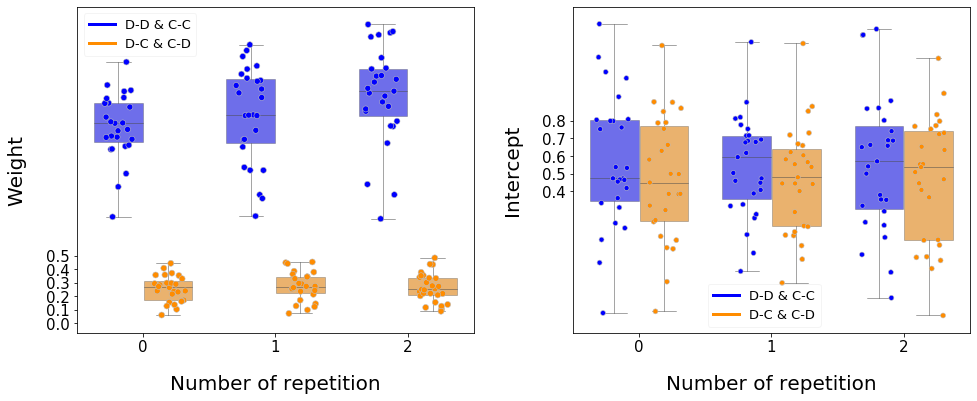

In [105]:
#These subplots are the original plots with seaborn. The next ones, are the plots improved using Plolty
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace = 0.25)
dat = log_regpre_deci_params
mycol = ['b', 'darkorange']
plt.subplot(1, 2, 1)  

ax = sns.boxplot(x="nrep", y="weight", hue = dat.pre_stim, linewidth = 0.5, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="weight", hue = dat.pre_stim, dodge=True, jitter = .25, data=dat, linewidth =.55, size=6, marker="o", edgecolor="silver", alpha=1, palette = mycol)
plt.ylabel('Weight', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 0.51, step=0.1), fontsize = 15)
plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['D-D & C-C', 'D-C & C-D']; plt.legend(lines, labels, loc= 'upper left', fontsize=13, framealpha= 0.2)

plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
ax = sns.boxplot(x="nrep", y="intercept", hue = dat.pre_stim, linewidth = 0.5, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="intercept", hue = dat.pre_stim, dodge=True, jitter = .25, data=dat, linewidth =.55, size=5, marker="o", edgecolor="silver", alpha=1, palette = mycol)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['D-D & C-C', 'D-C & C-D']; plt.legend(lines, labels, bbox_to_anchor=(0.64,0.17), fontsize=13, framealpha= 0.2)
plt.ylabel('Intercept', fontsize = 20, labelpad=20); plt.yticks(np.arange(0.4, 0.81, step=0.1), fontsize = 15); plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)

<font size="4"> _Weight en función de si la condición se repite o no y el número de repetición._

In [106]:
# Stimulus following one from the same category (i.e. Diagonal & Diagonal) are weighted more than others
# preceded by stimuli from different categories?

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd'))
#0A4893


dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'
))

fig.update_layout(
    boxmode='group', 
    #boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .75, 1.50, 2.25], ticktext=['0', '0.75', '1.50', '2.25', '1', '1.25'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.255])


fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="3"> ANOVAs y post-hoc t-test para weight

In [107]:
#Checking statistical differences in Weight between the number of repetitions & the previous stimulus
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

aov_preor_weight = AnovaRM(log_regpre_deci_params, 'weight', 'npar', within = ['nrep', 'pre_stim']).fit()
#print(aov_preor_weight) 
pg.rm_anova(dv = 'weight', within = ['pre_stim','nrep'], subject = 'npar', data=log_regpre_deci_params, detailed = True, correction = True)

# Esto significa que si se presenta un estímulo y otro seguido de la misma categoría, el siguiente tiene más weight
# el efecto se incrementa con el número de repeticiones

Source         SS  ddof1  ddof2         MS           F  \
0         pre_stim  69.174197      1     26  69.174197  485.143651   
1             nrep   0.376200      2     52   0.188100   12.053744   
2  pre_stim * nrep   0.339819      2     52   0.169910   15.846510   

          p-unc     p-GG-corr       np2       eps  
0  2.423160e-18  2.423160e-18  0.949134  1.000000  
1  5.000054e-05  8.884795e-05  0.316756  0.919410  
2  4.228309e-06  4.995833e-06  0.378682  0.982321

In [108]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['pre_stim','nrep'], subject='npar', padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 
#aquí he quitado lo de one-sided porque era más exploratorio, creo que no teníamos una hipótesis muy clara de lo que pasaría

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  22.025977  26.0  two-sided   
1      nrep  0.0  1.0    True        True  -1.868871  26.0  two-sided   
2      nrep  0.0  2.0    True        True  -4.965484  26.0  two-sided   
3      nrep  1.0  2.0    True        True  -3.200485  26.0  two-sided   

          p-unc    p-corr p-adjust       BF10     cohen  
0  2.423160e-18       NaN      NaN  1.782e+15  5.839890  
1  7.294654e-02  0.218840     bonf      0.927 -0.303906  
2  3.680902e-05  0.000110     bonf    653.904 -0.707701  
3  3.598420e-03  0.010795     bonf     11.155 -0.338709

In [109]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric          T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  20.343957  26.0  two-sided   

          p-unc       BF10     cohen  
0  1.713530e-17  2.739e+14  5.315454

Post-hoc t-test para mirar las interacciones

In [110]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 0]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.913148  26.0  two-sided  0.066802   
1     nrep  0  2    True        True -5.513060  26.0  two-sided  0.000009   
2     nrep  1  2    True        True -3.770687  26.0  two-sided  0.000848   

     p-corr p-adjust     BF10     cohen  
0  0.200406     bonf    0.992 -0.272846  
1  0.000026     bonf  2427.35 -0.728407  
2  0.002543     bonf   39.392 -0.397404

In [111]:
dat = log_regpre_deci_params.loc[log_regpre_deci_params.pre_stim == 1]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.016010  26.0  two-sided  0.318987   
1     nrep  0  2    True        True -0.458764  26.0  two-sided  0.650216   
2     nrep  1  2    True        True  0.719744  26.0  two-sided  0.478103   

    p-corr p-adjust   BF10     cohen  
0  0.95696     bonf  0.325 -0.174119  
1  1.00000     bonf  0.224 -0.081490  
2  1.00000     bonf  0.258  0.088313

No hay diferencias? No se exactamente que es lo que intentas ver aquí, number of repetition x previois stimulus ya lo has testeado mas arriba, nop? Y salia que había efectos de weight. Imagino que habría que mneter si son same or different category, por ejemplo. Aqui tiene que haber efectos como se ve claramente en la figura DD & CC vs DC & CD

**Respuesta:** aquí lo que se mira es cómo era el estímulo anterior dentro de una secuencia. 

<font size="4"> _Bias en función de si la condición se repite o no y el número de repetición._

In [112]:
# The same as before, with intercept instead of weight.
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd')) #2A88D4
#1C72E2

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.pre_stim == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'
))




fig.update_layout(
    boxmode='group', 
    #boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])


fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="3"> ANOVA para el intercepto

In [113]:
#Checking statistical differences in Intercept between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', data=log_regpre_deci_params, detailed = True, correction = True)

# en el intercepto no hay diferencias

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0             nrep  0.005737      2     52  0.002868  0.138075  0.871352   
1         pre_stim  0.320716      1     26  0.320716  8.647676  0.006794   
2  nrep * pre_stim  0.003012      2     52  0.001506  0.377764  0.687258   

   p-GG-corr       np2       eps  
0   0.871257  0.005283  0.999504  
1   0.006794  0.249589  1.000000  
2   0.674933  0.014321  0.942045

In [114]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

Contrast pre_stim  A  B Paired  Parametric         T   dof  \
0         pre_stim        -  0  1   True        True  2.940693  26.0   
1             nrep        -  0  1   True        True  0.514902  26.0   
2             nrep        -  0  2   True        True  0.175833  26.0   
3             nrep        -  1  2   True        True -0.339829  26.0   
4  pre_stim * nrep        0  0  1   True        True  0.769869  26.0   
5  pre_stim * nrep        0  0  2   True        True  0.320824  26.0   
6  pre_stim * nrep        0  1  2   True        True -0.436304  26.0   
7  pre_stim * nrep        1  0  1   True        True  0.130193  26.0   
8  pre_stim * nrep        1  0  2   True        True -0.009083  26.0   
9  pre_stim * nrep        1  1  2   True        True -0.163541  26.0   

        Tail     p-unc  p-corr p-adjust   BF10     cohen  
0  two-sided  0.006794     NaN      NaN   6.47  0.266524  
1  two-sided  0.610971     1.0     bonf   0.23  0.044665  
2  two-sided  0.861788     1.0     bonf  0.207  0.013510  
3  two-sided  0.736715     1.0     bonf  0.215 -0.029141  
4  two-sided  0.448316     1.0     bonf  0.267  0.074851  
5  two-sided  0.750908     1.0     bonf  0.214  0.025833  
6  two-sided  0.666218     1.0     bonf  0.222 -0.043614  
7  two-sided  0.897416     1.0     bonf  0.205  0.011444  
8  two-sided  0.992822     1.0     bonf  0.204 -0.000760  
9  two-sided  0.871357     1.0     bonf  0.206 -0.012234

In [115]:
###
dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat) 

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0  pre_stim  0.0  1.0    True        True  2.378504  26.0  two-sided   

      p-unc   BF10     cohen  
0  0.025016  2.175  0.238099

In [116]:
formula = "deci ~ dv"

log_regpre_deci_params_ext = dflong_sd.groupby(['npar', 'nrep', 'pre_stim', 'cond']).apply(log_reg_fit, formula)
log_regpre_deci_params_ext.reset_index(inplace = True)
log_regpre_deci_params_ext.head()

npar  nrep  pre_stim cond  level_4  intercept    weight       PSE
0   1.0     0       0.0    C        0  -0.165069  0.503436  0.327885
1   1.0     0       0.0    D        0   0.670301  1.590301 -0.421493
2   1.0     0       1.0    C        0   1.398912  1.369632 -1.021378
3   1.0     0       1.0    D        0   0.530559  0.578969 -0.916385
4   1.0     1       0.0    C        0  -0.532524  0.075488  7.054442

In [117]:
np.amin(log_regpre_deci_params_ext.PSE)

-57.82389240926689

In [118]:
# The same as before, with intercept instead of weight.
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 0) & (log_regpre_deci_params_ext.cond == 'C'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C (C)', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4')) #2A88D4

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 0) & (log_regpre_deci_params_ext.cond == 'D'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C (D)', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#0064b5')) #2A88D4
#1C72E2

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 1 & (log_regpre_deci_params_ext.cond == 'C')),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D (C)', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920B'
))

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 1 & (log_regpre_deci_params_ext.cond == 'D')),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D (D)', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#db7c00'
))

fig.update_layout(
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="Weight",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        x=0.3,
        y=1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))

fig.show()

In [119]:
# The same as before, with intercept instead of weight.
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 0) & (log_regpre_deci_params_ext.cond == 'C'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C (C)', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4')) #2A88D4

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 0) & (log_regpre_deci_params_ext.cond == 'D'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C (D)', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#0064b5')) #2A88D4
#1C72E2

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 1 & (log_regpre_deci_params_ext.cond == 'C')),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D (C)', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920B'
))

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 1 & (log_regpre_deci_params_ext.cond == 'D')),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D (D)', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#db7c00'
))

fig.update_layout(
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        x=0.3,
        y=1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))

fig.show()

In [120]:
# The same as before, with intercept instead of weight.
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 0) & (log_regpre_deci_params_ext.cond == 'C'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C (C)', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#2A88D4')) #2A88D4

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 0) & (log_regpre_deci_params_ext.cond == 'D'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='D-D & C-C (D)', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#0064b5')) #2A88D4
#1C72E2

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 1 & (log_regpre_deci_params_ext.cond == 'C')),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D (C)', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#FA920B'
))

dat = log_regpre_deci_params_ext.loc[(log_regpre_deci_params_ext.pre_stim == 1 & (log_regpre_deci_params_ext.cond == 'D')),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#FA920A',
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='D-C & C-D (D)', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#db7c00'
))

fig.update_layout(
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="PSE",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
fig['layout']['yaxis1'].update(range=[-15, 15], dtick=5, autorange=False)
fig.show()

<font size="3"> _Logisitc regression para plotear weight e intercept en función de la orientación anterior_

In [121]:
# The next model checks if stimuli are weigthed/change their intercept depending on the orientation of previous
# stimuli inside a sequence. For example, a stimuli following another with similar orientation can be weighted 
# more or less than when the stimuli is following another with different orientation. 

formula = "deci ~ dv"

log_regpre_orient_params = dflong_sd.groupby(['npar', 'nrep', 'pre_orient']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

npar  nrep  pre_orient  level_3  intercept    weight       PSE
0   1.0     0         0.0        0   0.618098  1.147158 -0.538809
1   1.0     0         1.0        0   0.657617  1.120523 -0.586884
2   1.0     1         0.0        0   0.671053  1.200408 -0.559021
3   1.0     1         1.0        0   0.683753  1.553706 -0.440079
4   1.0     2         0.0        0   0.685319  1.295018 -0.529196

<font size="4"> _Weight y bias en función de si la orientación se repite o no y el número de repetición._

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

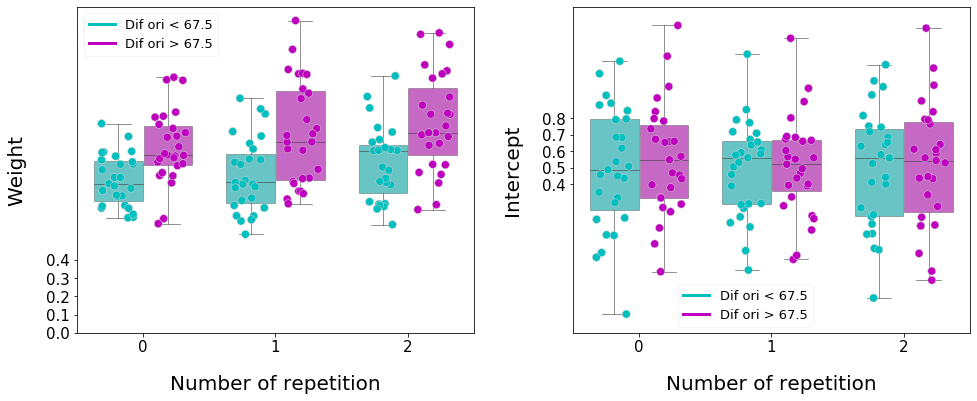

In [122]:
plt.subplots(ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace = 0.25)
dat = log_regpre_orient_params
mycol = ['c', 'm']
plt.subplot(1, 2, 1)  

ax = sns.boxplot(x="nrep", y="weight", hue = dat.pre_orient, linewidth = 0.55, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="weight", hue = dat.pre_orient, dodge=True, jitter=.25, data=dat, linewidth =.5, size=8, marker="o", edgecolor="lightgrey", alpha=1, palette = mycol)
plt.ylabel('Weight', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 0.41, step=0.1), fontsize = 15)
plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Dif ori < 67.5', 'Dif ori > 67.5']; plt.legend(lines, labels, loc= 'upper left', fontsize=13, framealpha= 0.2)
                                                                            
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
ax = sns.boxplot(x="nrep", y="intercept", hue = dat.pre_orient, linewidth = 0.55, dodge=True, data=dat, whis=np.inf, width = 0.75, boxprops=dict(alpha=.65), palette = mycol) # 
ax = sns.stripplot(x="nrep", y="intercept", hue = dat.pre_orient, dodge=True, jitter=.25, data=dat, linewidth =.5, size=8, marker="o", edgecolor='lightgrey', alpha=1, palette = mycol)
ax.get_legend().remove()
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['Dif ori < 67.5', 'Dif ori > 67.5']; plt.legend(lines, labels, bbox_to_anchor=(0.62,0.17), fontsize=13, framealpha= 0.2)
plt.ylabel('Intercept', fontsize = 20, labelpad=20); plt.yticks(np.arange(0.4, 0.81, step=0.1), fontsize = 15); plt.xlabel('Number of repetition', fontdict={'size':20}, labelpad=20); plt.xticks(fontsize = 15)
#plt.savefig('Orinetation_pre.png')

<font size="4"> _Weight en función de si la orientación fisica es similar o distinta a la anterior y el número de repetición._

In [123]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented in degrees
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['weight'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354' #violeta
))

fig.update_layout(
    boxmode='group', 
    #boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])


fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="3"> ANOVAs y post-hoc t-test para weight

In [124]:
#Checking statistical differences in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_orient'], subject = 'npar', data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F     p-unc  \
0               nrep  0.360735      2     52  0.180367  11.975055  0.000053   
1         pre_orient  1.763175      1     26  1.763175  39.567225  0.000001   
2  nrep * pre_orient  0.014847      2     52  0.007423   0.945378  0.395108   

   p-GG-corr       np2       eps  
0   0.000108  0.315340  0.898287  
1   0.000001  0.603460  1.000000  
2   0.391011  0.035085  0.945517

In [125]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 
# de nuevo no puedo hacer la interacción

Contrast    A    B  Paired  Parametric         T   dof       Tail  \
0        nrep  0.0  1.0    True        True -1.880210  26.0  two-sided   
1        nrep  0.0  2.0    True        True -4.995395  26.0  two-sided   
2        nrep  1.0  2.0    True        True -3.187111  26.0  two-sided   
3  pre_orient  0.0  1.0    True        True -6.290248  26.0  two-sided   

      p-unc    p-corr p-adjust       BF10     cohen  
0  0.071328  0.213984     bonf      0.943 -0.272945  
1  0.000034  0.000102     bonf    702.442 -0.628598  
2  0.003720  0.011159     bonf     10.841 -0.294807  
3  0.000001       NaN      NaN  1.539e+04 -1.028754

Iteracciones con post hoc t tests

In [126]:
#para hacer la interacción he probado con lo siguiente
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 0]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square',interaction=False, data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.117176  26.0  two-sided  0.274137   
1     nrep  0  2    True        True -3.171661  26.0  two-sided  0.003865   
2     nrep  1  2    True        True -3.009314  26.0  two-sided  0.005754   

     p-corr p-adjust   BF10  eta-square  
0  0.822410     bonf  0.358    0.007381  
1  0.011594     bonf  10.49    0.070012  
2  0.017261     bonf  7.455    0.026069

In [127]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 1]
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'eta-square',interaction=False, data=dat) 

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True -1.913125  26.0  two-sided  0.066805   
1     nrep  0  2    True        True -4.783795  26.0  two-sided  0.000059   
2     nrep  1  2    True        True -2.255660  26.0  two-sided  0.032733   

     p-corr p-adjust     BF10  eta-square  
0  0.200415     bonf    0.992    0.020996  
1  0.000178     bonf  423.506    0.075862  
2  0.098198     bonf    1.748    0.012898

In [128]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', effsize = 'cohen',interaction=False, data=dat) 

Contrast    A    B  Paired  Parametric        T   dof       Tail  \
0  pre_orient  0.0  1.0    True        True -5.91504  26.0  two-sided   

      p-unc      BF10     cohen  
0  0.000003  6333.877 -0.931478

<font size="4"> _Bias en función de si la orientación fisica es similar o distinta a la anterior y el número de repetición._

In [129]:
# The same as before, with intercept instead of weight.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very similar in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=11,
        opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354' #violeta
))

fig.update_layout(
    boxmode='group', 
    #boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",        font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])


fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

In [130]:
# The same as before, with intercept instead of weight.

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])
data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very similar in degrees
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5', # Stimuli followed by another similar in orientation
    marker_color='#3FBFAA'))
#0A4893

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['PSE'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5', # Stimuli followed by another very different in orientation
    marker_color='#9F68E3' #violeta
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    yaxis_title="PSE",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)

fig.update_layout(
    legend=dict(
        x=0.59,
        y=1.03,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))

fig.update_traces(showlegend=True)

fig.show()

<font size="3"> ANOVAs y post-hoc t-test para bias

In [131]:
#Checking statistical differences in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', data=log_regpre_orient_params, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0               nrep  0.015686      2     52  0.007843  0.389374  0.679439   
1         pre_orient  0.041954      1     26  0.041954  1.544729  0.225008   
2  nrep * pre_orient  0.017591      2     52  0.008795  2.352762  0.105154   

   p-GG-corr       np2       eps  
0   0.679262  0.014755  0.999134  
1   0.225008  0.056081  1.000000  
2   0.112615  0.082982  0.880076

Post-hoc t-test para mirar las interacciones

In [132]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 0]

#aquí lo único significativo era la interacción, no podemos saber si la interacción entre la orientación previa es significativa con la 1a y la 2a, con la 2a y la 3a, o la 1 con la 3a
# de nuevo no puedo hacer la interacción
#así que he probado este invento, pero creo que no es una buena alternativa
pg.pairwise_ttests(dv='intercept', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', effsize = 'cohen', data=log_regpre_orient_params) 

Contrast nrep  A  B Paired  Parametric         T   dof       Tail  \
0               nrep    -  0  1   True        True  0.820656  26.0  two-sided   
1               nrep    -  0  2   True        True  0.686747  26.0  two-sided   
2               nrep    -  1  2   True        True -0.151345  26.0  two-sided   
3         pre_orient    -  0  1   True        True -1.242871  26.0  two-sided   
4  nrep * pre_orient    0  0  1   True        True -2.135544  26.0  two-sided   
5  nrep * pre_orient    1  0  1   True        True -0.617007  26.0  two-sided   
6  nrep * pre_orient    2  0  1   True        True -0.571103  26.0  two-sided   

      p-unc    p-corr p-adjust   BF10     cohen  
0  0.419303  1.000000     bonf  0.277  0.070956  
1  0.498322  1.000000     bonf  0.253  0.052329  
2  0.880871  1.000000     bonf  0.206 -0.012874  
3  0.225008       NaN      NaN  0.407 -0.097933  
4  0.042304  0.126911     bonf  1.422 -0.172204  
5  0.542596  1.000000     bonf  0.243 -0.059626  
6  0.572834  1.000000     bonf  0.237 -0.047574

In [133]:
dat = log_regpre_orient_params.loc[log_regpre_orient_params.pre_orient == 1]

pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

Contrast  A  B  Paired  Parametric         T   dof       Tail     p-unc  \
0     nrep  0  1    True        True  1.557496  26.0  two-sided  0.131443   
1     nrep  0  2    True        True  1.318156  26.0  two-sided  0.198947   
2     nrep  1  2    True        True -0.122989  26.0  two-sided  0.903062   

     p-corr p-adjust   BF10     cohen  
0  0.394329     bonf  0.595  0.139008  
1  0.596841     bonf  0.443  0.113495  
2  1.000000     bonf  0.205 -0.012030

In [134]:
formula = "deci ~ dv"

log_regpre_orient_params_ext = dflong_sd.groupby(['npar', 'nrep', 'pre_orient', 'cond']).apply(log_reg_fit, formula)
log_regpre_orient_params_ext.reset_index(inplace = True)
log_regpre_orient_params_ext.head()

npar  nrep  pre_orient cond  level_4  intercept    weight       PSE
0   1.0     0         0.0    C        0   0.356995  0.732783 -0.487176
1   1.0     0         0.0    D        0   0.759116  0.966473 -0.785450
2   1.0     0         1.0    C        0   0.792954  1.289448 -0.614956
3   1.0     0         1.0    D        0   0.380256  1.567850 -0.242533
4   1.0     1         0.0    C        0   0.387964  0.717611 -0.540633

In [135]:
fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = log_regpre_orient_params_ext.loc[(log_regpre_orient_params_ext.pre_orient == 0) & (log_regpre_orient_params_ext.cond == 'C'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very similar in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5 (C)', # Stimuli followed by another similar in orientation
    marker_color='#3FBFAA'))
#0A4893

dat = log_regpre_orient_params_ext.loc[(log_regpre_orient_params_ext.pre_orient == 0) & (log_regpre_orient_params_ext.cond == 'D'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very similar in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#3FBFAA',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Dif ori < 67.5 (D)', # Stimuli followed by another similar in orientation
    marker_color='#148c78'))

dat = log_regpre_orient_params_ext.loc[(log_regpre_orient_params_ext.pre_orient == 1) & (log_regpre_orient_params_ext.cond == 'C'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5 (C)', # Stimuli followed by another very different in orientation
    marker_color='#9F68E3' #violeta
))

dat = log_regpre_orient_params_ext.loc[(log_regpre_orient_params_ext.pre_orient == 1) & (log_regpre_orient_params_ext.cond == 'D'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another oriented very different in degrees
    y=dat['intercept'],
    x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', #violeta
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15, 
    name='Dif ori > 67.5 (D)', # Stimuli followed by another very different in orientation
    marker_color='#6e32b8' #violeta
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    boxmode='group', # group together boxes of the different traces for each value of x
    yaxis_title="Intercept",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)

fig.update_layout(
    legend=dict(
        x=0.59,
        y=1.03,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))

fig.update_traces(showlegend=True)

fig.show()

### Weight & Bias

<font size="3"> _Logisitc regression para plotear weight en función del bias y el número de repetición_

In [136]:
#generate dataframe to stimate the bias
# we want to stimate if participants with more weight, were more or less biased than participants with less weight
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['npar','nrep', 'pre_deci']).apply(log_reg_fit, formula) 
log_data.reset_index(inplace = True) 

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0) # this is to calculate the bias between previous decision cardinal and diagonal
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

npar  nrep  pre_deci  level_3  intercept    weight  pre_intercept  \
0   1.0     0         0        0   0.558344  3.154904       0.000000   
1   1.0     0         1        0   0.855172  3.635940       0.558344   
2   1.0     1         0        0  -0.556693  3.870418       0.855172   
3   1.0     1         1        0   1.782901  3.266181      -0.556693   
4   1.0     2         0        0  -0.902185  2.658734       1.782901   

       bias       PSE  
0  0.558344 -0.176977  
1  0.296828 -0.235200  
2 -1.411865  0.143833  
3  2.339594 -0.545867  
4 -2.685087  0.339329

In [137]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['npar','nrep']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['npar', 'nrep', 'intercept']] 
log_data2.head()

bias = log_data[['npar', 'bias', 'pre_deci', 'nrep']]
bias = bias.loc[(bias.pre_deci == 1),:] 
# i took pre_deci 1 as bias, because it is the result of the bias within the participant, 0 is not useful.
# it computes the bias between two different participants
bias = bias[['bias']]
bias.reset_index(drop=True, inplace=True)
bias.head()
#bias['nrep'] = bias['nrep'].astype(str)

bias = pd.concat([log_data2, bias], axis=1)
bias.head()
bias['nrep'] = bias['nrep'].astype(str)

<font size="4"> _Weight en función del bias por el número de repetición._

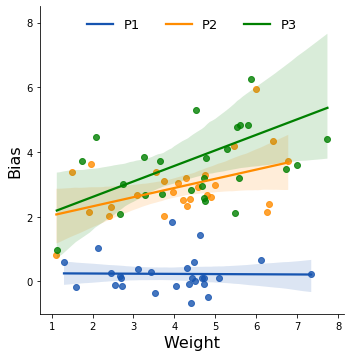

In [138]:
# in this plot, we can see how the best participants (those with higher weight) were more biased in 2nd a 3rd presentation
# to answer consistent with previous decision
mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)
sns.lmplot(x='weight', y='bias', data = bias, fit_reg = True, hue = 'nrep', legend = False)

plt.yticks(np.arange(0, 8.1, step=2), fontsize = 10) #; plt.xticks(np.arange(0, 8.1, step=2), fontsize = 10)
plt.ylim(-1, 8.5)
plt.legend(loc='upper center', frameon=False,labels=['P1', 'P2', 'P3'], fontsize=13, title_fontsize=14, ncol=3); plt.ylabel('Bias', fontsize = 16); plt.xlabel('Weight', fontdict={'size':16}); 
#plt.savefig('biasvsweightEND.png')

In [139]:
fig = px.scatter(bias, x="weight", y="bias", color="nrep", size='weight', hover_data=['nrep'],
                 trendline="ols")
fig.show()

In [140]:
fig = px.scatter(bias, x="weight", y="bias", color="nrep", size='weight', hover_data=['nrep'], 
                 color_discrete_sequence=['rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)', 'rgba(232, 126, 4, 1)', 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)'], 
                 marginal_y="box", marginal_x="box", trendline="ols")
fig.show()

In [141]:
formula = "deci ~ rDV"
bias_pse = df.groupby(['npar','nrep']).apply(log_reg_fit, formula) 
bias_pse.reset_index(inplace = True) 
bias_pse['nrep'] = bias_pse['nrep'].astype(str)
bias_pse.head()

npar nrep  level_2  intercept    weight       PSE
0   1.0    0        0   0.742215  3.427240 -0.216564
1   1.0    1        0   0.814154  4.301049 -0.189292
2   1.0    2        0   0.803716  4.395120 -0.182865
3   2.0    0        0   0.953971  4.666110 -0.204447
4   2.0    1        0   0.646920  6.411675 -0.100897

In [142]:
fig = px.scatter(bias_pse, x="weight", y="PSE", color="nrep", hover_data=['nrep'],
                 trendline="ols")
fig.show()

<font size="3"> Analisis estadístico

In [143]:
#He tenido problemas para saber qué estadístico era el mejor 
#para mrar si había diferencias significativas en el plot anterior/ He probado diferentes estadísticos...

mdf = smf.mixedlm("bias ~ weight * C(nrep)", bias, groups = bias["npar"]).fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   bias     
No. Observations:    81        Method:               REML     
No. Groups:          27        Scale:                1.0069   
Min. group size:     3         Log-Likelihood:       -128.9291
Max. group size:     3         Converged:            Yes      
Mean group size:     3.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.462    0.718  0.644 0.520 -0.944  1.868
C(nrep)[T.1]         1.497    0.831  1.801 0.072 -0.132  3.126
C(nrep)[T.2]         1.243    0.847  1.468 0.142 -0.417  2.903
weight              -0.059    0.175 -0.336 0.737 -0.401  0.284
weight:C(nrep)[T.1]  0.293    0.197  1.489 0.136 -0.093  0.678
weight:C(nrep)[T.2]  0.527    0.193  2.736 0.006  0.149  0.904
Group Var            0.484    0.286                           
==============================================================

"""

In [144]:
mod = ols(formula='weight ~ bias * nrep', data=bias)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2.994
Date:                Mon, 26 Oct 2020   Prob (F-statistic):             0.0162
Time:                        21:11:05   Log-Likelihood:                -141.09
No. Observations:                  81   AIC:                             294.2
Df Residuals:                      75   BIC:                             308.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.8888      0.301     12.

<font size="3"> _Logisitc regression para plotear bias en función de si la respuesta anterior era correcta_

In [145]:
# we make a similar analyses than before, but know we stimated biased between previous answer correct/incorrect
# we wanted to stimate if participants were more biased when the previous answer was correct or incorrect
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['pre_correct','npar', 'pre_deci']).apply(log_reg_fit, formula)
log_data.reset_index(inplace = True)

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0)
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

pre_correct  npar  pre_deci  level_3  intercept    weight  pre_intercept  \
0            0   1.0         0        0  -0.607538  4.141464       0.000000   
1            0   1.0         1        0   2.037738  4.356887      -0.607538   
2            0   2.0         0        0  -0.841838  4.277137       2.037738   
3            0   2.0         1        0   2.319548  5.582314      -0.841838   
4            0   3.0         0        0  -1.010410  6.727344       2.319548   

       bias       PSE  
0 -0.607538  0.146696  
1  2.645277 -0.467705  
2 -2.879576  0.196823  
3  3.161386 -0.415517  
4 -3.329958  0.150194

In [146]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['pre_correct','npar']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['pre_correct', 'npar', 'intercept']]
log_data2.head()

bias2 = log_data[['pre_correct', 'bias', 'pre_deci', 'npar']]
bias2 = bias2.loc[(bias2.pre_deci == 1),:]
bias2 = bias2[['bias']]
bias2.reset_index(drop=True, inplace=True)
bias2.head()

bias2 = pd.concat([log_data2, bias2], axis=1)
biaspre_correct = bias2
biaspre_correct.head()

pre_correct  npar  level_2  intercept    weight       PSE      bias
0            0   1.0        0   0.866351  1.425216 -0.607873  2.645277
1            0   2.0        0   0.831527  0.866940 -0.959151  3.161386
2            0   3.0        0   0.810810  1.210021 -0.670079  2.071311
3            0   4.0        0   0.401331  1.339587 -0.299593  2.333913
4            0   5.0        0   0.035170  0.008780 -4.005869  1.937578

<font size="4"> _Bias en función de si la respuesta anterior era correcta o no_

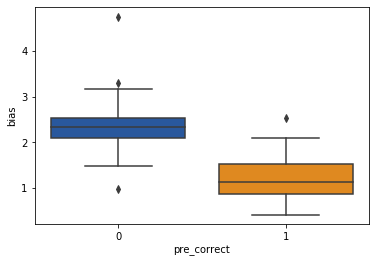

In [147]:
# Next, I will plot if there is more bias after an error, or after correct answers

# habría que hacer un plot mejor, la única cosa es que no me deja hacer el log_reg_fit poniendo nrep. Porque no admite más variables
plt.plot(figsize = (7,10))

sns.boxplot(x='pre_correct', y='bias', data =biaspre_correct)

In [148]:
#The same boxplot with Plotly

fig = go.Figure()
#fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])

dat = biaspre_correct.loc[(biaspre_correct.pre_correct == 0),:]
fig.add_trace(go.Box(
    y=dat['bias'],
    boxpoints='all',
    whiskerwidth=0.5,
    width = 0,
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#FFDCA2', # sand
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.1,
    name='Incorrect', # Stimuli followed by another similar in orientation
    marker_color='#FFDCA2')) # sand
#0A4893

dat = biaspre_correct.loc[(biaspre_correct.pre_correct == 1),:]
fig.add_trace(go.Box(
    y=dat['bias'],
    boxpoints='all', pointpos=0, jitter=0.5,
    whiskerwidth=0.5,
    width = 0,
    marker=dict(
        color='#4385BB', #dark blue #4385BB  #355C7D
        size=5,
        opacity=0.75,
        line=dict(color='#9A5903', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.1, 
    name='Correct', # Stimuli followed by another very different in orientation
    marker_color='#4385BB' #dark blue
))

fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Intercept'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0], ticktext=[' ', '2'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
fig.update_yaxes(tickvals= [0.1, 0.3, 0.5, 0.7], ticktext=['0.1', '0.3', '0.5', '0.7'])


fig.update_layout(
    legend=dict(
        x=0.62,
        y=0.9,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=18,
            color="#54636D"
        )))

fig.update_layout(
    yaxis_title="Bias",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)

fig.show()

<font size="3"> t-test para el bias en función de la respuesta anterior (correcta o incorrecra)

In [149]:
# pairwaise t test
pg.pairwise_ttests(dv='bias', within=['pre_correct'], subject='npar', padjust='none', effsize = 'cohen', data=biaspre_correct) 
# parece que no es significativo. Estos son los análisis que me pediste (los últimos). 
# Comparar el bias cuando la respuesta previa era correcta o incorrecta

Contrast  A  B  Paired  Parametric        T   dof       Tail  \
0  pre_correct  0  1    True        True  9.09732  26.0  two-sided   

          p-unc       BF10     cohen  
0  1.463322e-09  7.865e+06  2.062075

In [150]:
# we make a similar analyses than before, but know we stimated biased between previous answer correct/incorrect
# we wanted to stimate if participants were more biased when the previous answer was correct or incorrect

# i tried to incorporate nrep, but until now it is not working
# here it is the best try, but it provides results that seems contradictory to me compared with the previous plot
data = df
formula = "deci ~ rDV"
log_data = data.groupby(['pre_correct','nrep', 'pre_deci']).apply(log_reg_fit, formula)
log_data.reset_index(inplace = True)

log_data.insert(6, 'pre_intercept', 0)
log_data['pre_intercept'] = log_data['intercept']
log_data['pre_intercept'] = log_data['pre_intercept'].shift(1, fill_value = 0)

log_data.insert(7, 'bias', 0)
log_data['bias'] = log_data['intercept'] - log_data['pre_intercept'] 

log_data.head()

pre_correct  nrep  pre_deci  level_3  intercept    weight  pre_intercept  \
0            0     0         0        0   0.366008  2.683750       0.000000   
1            0     0         1        0   0.713262  2.994381       0.366008   
2            0     1         0        0  -1.397326  3.803064       0.713262   
3            0     1         1        0   2.071747  3.461192      -1.397326   
4            0     2         0        0  -1.726403  3.961719       2.071747   

       bias       PSE  
0  0.366008 -0.136379  
1  0.347255 -0.238200  
2 -2.110589  0.367421  
3  3.469073 -0.598565  
4 -3.798150  0.435771

In [151]:
formula = "deci ~ rDV"
log_data2 = data.groupby(['pre_correct','nrep']).apply(log_reg_fit, formula)
log_data2.reset_index(inplace = True)
log_data2[['pre_correct', 'nrep', 'intercept']]
log_data2.head()

bias2 = log_data[['pre_correct', 'bias', 'pre_deci', 'nrep']]
bias2 = bias2.loc[(bias2.pre_deci == 1),:]
bias2 = bias2[['bias']]
bias2.reset_index(drop=True, inplace=True)
bias2.head()

bias2 = pd.concat([log_data2, bias2], axis=1)
bias2.head()

pre_correct  nrep  level_2  intercept    weight       PSE      bias
0            0     0        0   0.594754  2.864056 -0.207661  0.347255
1            0     1        0   0.421409 -1.090330  0.386497  3.469073
2            0     2        0   0.435940 -1.574143  0.276938  4.132694
3            1     0        0   0.596994  3.324747 -0.179561  0.300381
4            1     1        0   0.393142  6.357803 -0.061836  4.132375

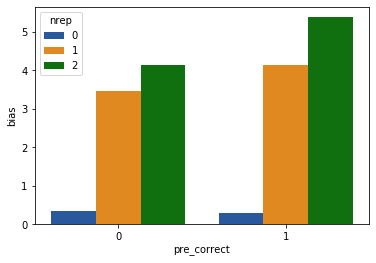

In [152]:
#I don't think this is correct, because (I think)it is contradictory with the last plot. And I forced the code to give a result.
plt.plot(figsize = (7,10))

sns.barplot(x='pre_correct', y='bias', hue='nrep', data =bias2)

aqui parece que hay mas bias cuando en el trial anterior la gente respondia correctamente. Sin embargo en la figura de arriba (naranja y azul bloxplot) parecia al reves. Por qué?

yo tampoco lo entiendo. para mí no tiene mucho sentido la verdad

### Data anlysis and plots by stimuli

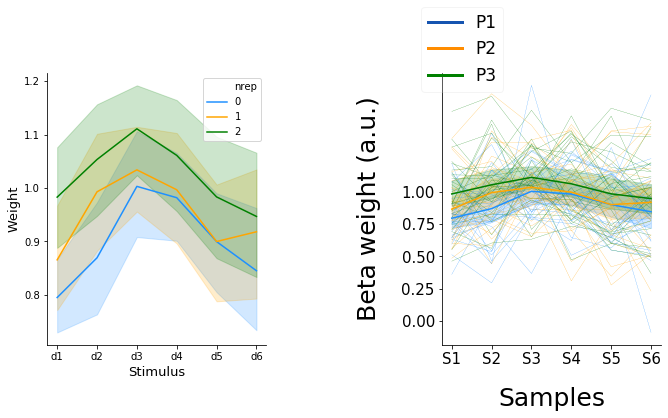

In [153]:
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.8) #wspace sirve para marcar la separación entre los dos plots 
#con un valor negativo te cargas el primer plot

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)



plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
n_par_labels = np.unique(df.npar) #subj

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], err_style=None, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Weight', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)
legend.remove()

ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.2, step=0.25), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)

sns.despine(top=True)
plt.savefig('stim_wewight&weight4part.png')

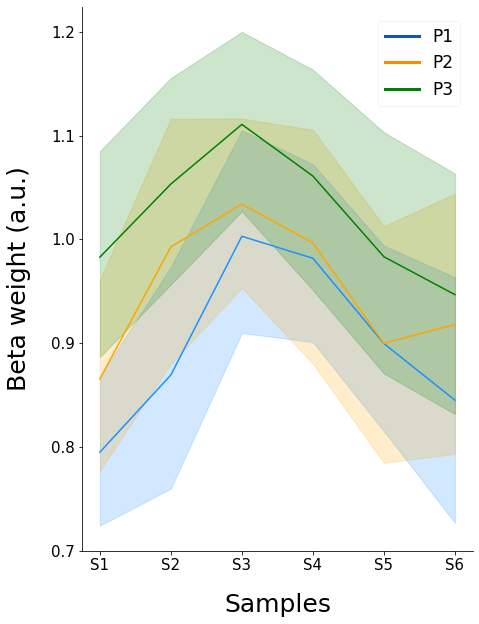

In [154]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]

sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], ci=95, data=log_regstim_params)

plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0.7, 1.201, step=0.1), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.99,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_weight.png',bbox_inches='tight')

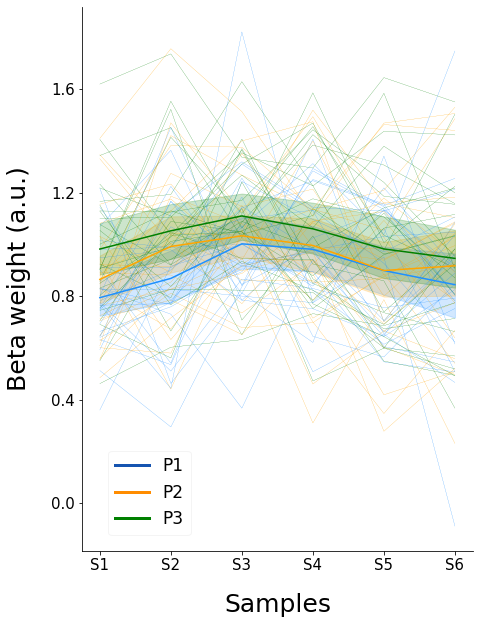

In [155]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Weight', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.3,0.2), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_weight4part.png',bbox_inches='tight')

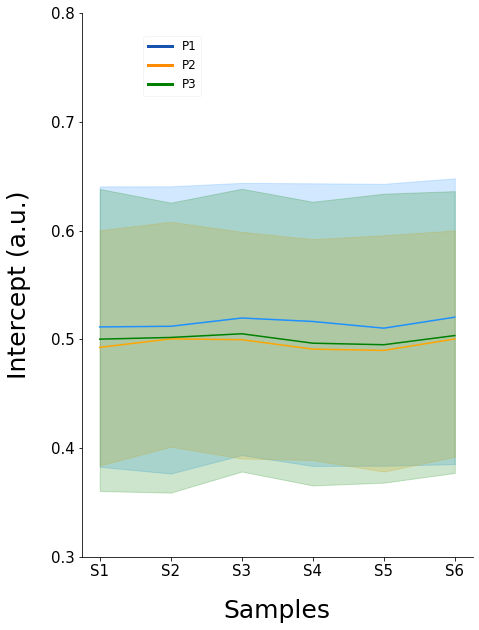

In [156]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]

sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0.3, 0.81, step=0.1), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.32,0.97), fontsize=12, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_intercept.png',bbox_inches='tight')

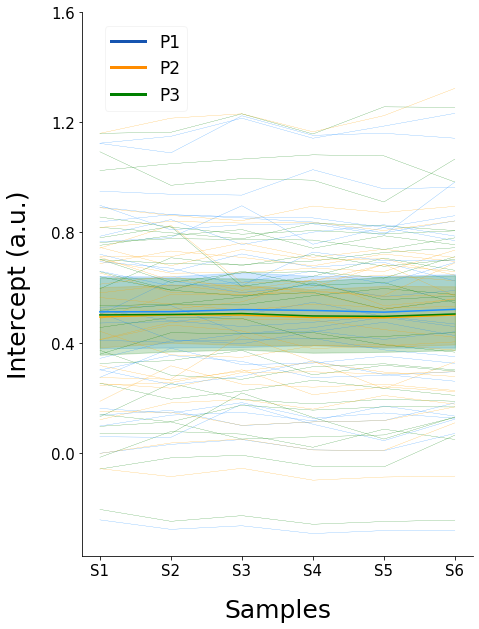

In [157]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="intercept", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="intercept", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_intercept4part.png',bbox_inches='tight')

In [158]:
print(len(n_par_labels))

27


In [159]:
# ANOVA to check if there are differences in the how stimuli are WEIGHTED depending on their position

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=log_regstim_params, detailed = True, correction = True)

C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS          F     p-unc  \
0         nrep  1.256141      2     52  0.628070  14.391667  0.000011   
1         stim  1.731849      5    130  0.346370   2.843023  0.018037   
2  nrep * stim  0.240790     10    260  0.024079   1.339174  0.209626   

   p-GG-corr       np2       eps  
0   0.000028  0.356303  0.885468  
1   0.024074  0.098569  0.865857  
2   0.259059  0.048984  0.416234

In [160]:
# post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=log_regstim_params) 

Contrast   A   B  Paired  Parametric         T   dof       Tail     p-unc  \
0      nrep   0   1    True        True -2.043345  26.0  two-sided  0.051275   
1      nrep   0   2    True        True -4.982210  26.0  two-sided  0.000035   
2      nrep   1   2    True        True -3.864763  26.0  two-sided  0.000665   
3      stim  d1  d2    True        True -1.668108  26.0  two-sided  0.107295   
4      stim  d1  d3    True        True -3.250585  26.0  two-sided  0.003177   
5      stim  d1  d4    True        True -2.483559  26.0  two-sided  0.019779   
6      stim  d1  d5    True        True -0.883449  26.0  two-sided  0.385090   
7      stim  d1  d6    True        True -0.427632  26.0  two-sided  0.672440   
8      stim  d2  d3    True        True -1.303249  26.0  two-sided  0.203913   
9      stim  d2  d4    True        True -0.819734  26.0  two-sided  0.419819   
10     stim  d2  d5    True        True  0.749108  26.0  two-sided  0.460517   
11     stim  d2  d6    True        True  1.161740  26.0  two-sided  0.255895   
12     stim  d3  d4    True        True  0.611645  26.0  two-sided  0.546084   
13     stim  d3  d5    True        True  2.095988  26.0  two-sided  0.045965   
14     stim  d3  d6    True        True  2.180369  26.0  two-sided  0.038472   
15     stim  d4  d5    True        True  1.724127  26.0  two-sided  0.096557   
16     stim  d4  d6    True        True  2.343517  26.0  two-sided  0.027024   
17     stim  d5  d6    True        True  0.519064  26.0  two-sided  0.608106   

      p-corr p-adjust     BF10     cohen  
0   0.153826     bonf    1.221 -0.310247  
1   0.000106     bonf  680.616 -0.728677  
2   0.001994     bonf   48.839 -0.348825  
3   1.000000     bonf    0.691 -0.385499  
4   0.047659     bonf   12.421 -0.794250  
5   0.296683     bonf    2.639 -0.578092  
6   1.000000     bonf    0.291 -0.196984  
7   1.000000     bonf    0.222 -0.084498  
8   1.000000     bonf    0.436 -0.330045  
9   1.000000     bonf    0.277 -0.165486  
10  1.000000     bonf    0.263  0.172419  
11  1.000000     bonf    0.374  0.243436  
12  1.000000     bonf    0.242  0.158505  
13  0.689478     bonf    1.331  0.517400  
14  0.577073     bonf    1.534  0.556954  
15  1.000000     bonf    0.748  0.341891  
16  0.405362     bonf    2.042  0.398417  
17  1.000000     bonf    0.231  0.086083

In [161]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=log_regstim_params, detailed = True, correction = True)

C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         nrep  0.033084      2     52  0.016542  0.277441  0.758835   
1         stim  0.006415      5    130  0.001283  0.313217  0.904305   
2  nrep * stim  0.001687     10    260  0.000169  0.779854  0.648234   

   p-GG-corr       np2       eps  
0   0.757943  0.010558  0.995879  
1   0.878710  0.011903  0.849584  
2   0.439099  0.029121  0.160434

In [162]:
#logistic regression to estimate weight and intercept parameters with previous decision by stimuli
formula = "deci ~ dv"

log_regstim_params_preD = dflong.groupby(['npar','nrep', 'stim', 'pre_deci']).apply(log_reg_fit, formula)
log_regstim_params_preD.reset_index(inplace = True)

dat = log_regstim_params_preD

dat.insert(7, 'pre_weight', 0)
dat['pre_weight'] = dat['weight']
dat['pre_weight'] = dat['pre_weight'].shift(1, fill_value = 0)

dat.insert(8, 'w_dif', 0)
dat['w_dif'] = dat['weight'] - dat['pre_weight']

dat.insert(9, 'pre_int', 0)
dat['pre_int'] = dat['intercept']
dat['pre_int'] = dat['pre_int'].shift(1, fill_value = 0)

dat.insert(10, 'i_dif', 0)
dat['i_dif'] = dat['intercept'] - dat['pre_int']

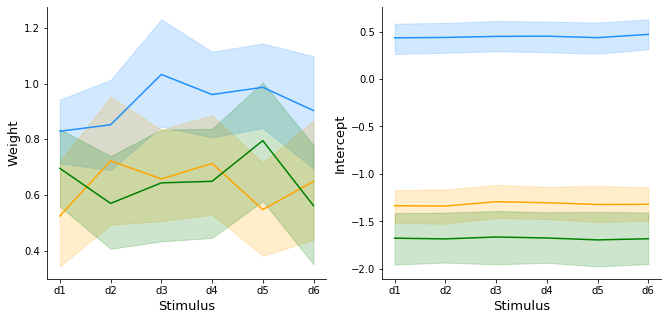

In [163]:
# it plots weight and intercept depending on the previous decision, when previous was cardinal by stimuli
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.2) #wspace antes 0.5

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 0),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 0),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
legend =plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56, 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
legend.remove()
sns.despine(top=True)

In [164]:
# weight
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
#aov_log_preg_preD_car = AnovaRM(dat, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print('How stimuli are weighted depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was cardinal')
pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

How stimuli are weighted depending on their order in the sequence and the number of presentation when the previous decision was cardinal


C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS          F     p-unc  \
0         nrep  8.669540      2     52  4.334770  17.682041  0.000001   
1         stim  0.733991      5    130  0.146798   0.655188  0.658065   
2  nrep * stim  2.054521     10    260  0.205452   1.062471  0.391785   

   p-GG-corr      np2       eps  
0   0.000002  0.40479  0.957084  
1   0.632421  0.02458  0.843453  
2   0.385377  0.03926  0.529369

In [165]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
pg.pairwise_ttests(dv='weight', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

Contrast  A  B  Paired  Parametric         T    dof       Tail  \
0     nrep  0  1    True        True  6.453873  161.0  two-sided   
1     nrep  0  2    True        True  5.705187  161.0  two-sided   
2     nrep  1  2    True        True -0.298120  161.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  1.223505e-09  3.670515e-09     bonf  7.284e+06  0.606359  
1  5.438137e-08  1.631441e-07     bonf  1.898e+05  0.566965  
2  7.659960e-01  1.000000e+00     bonf      0.092 -0.032212

In [166]:
# intercept
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
#aov_log_preg_preDI_car = AnovaRM(dat, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print('Intercept changes depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was       cardinal')

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Intercept changes depending on their order in the sequence and the number of presentation when the previous decision was       cardinal


C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source          SS  ddof1  ddof2          MS           F  \
0         nrep  419.067148      2     52  209.533574  170.503082   
1         stim    0.049402      5    130    0.009880    1.246847   
2  nrep * stim    0.032784     10    260    0.003278    0.949485   

          p-unc     p-GG-corr       np2       eps  
0  1.451121e-23  3.418051e-20  0.867687  0.841214  
1  2.910496e-01  2.961753e-01  0.045761  0.782163  
2  4.883293e-01  3.427160e-01  0.035232  0.104648

In [167]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 0];
pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

Contrast  A  B  Paired  Parametric          T    dof       Tail  \
0     nrep  0  1    True        True  36.984072  161.0  two-sided   
1     nrep  0  2    True        True  35.917491  161.0  two-sided   
2     nrep  1  2    True        True   8.809132  161.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  1.350404e-80  4.051211e-80     bonf  7.555e+76  3.882186  
1  9.051512e-79  2.715453e-78     bonf  1.164e+75  3.524723  
2  1.919933e-15  5.759799e-15     bonf   3.14e+12  0.578919

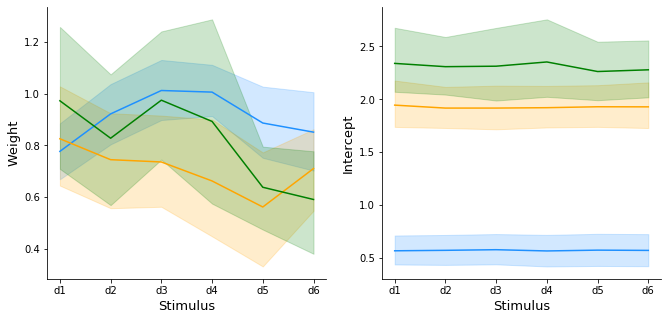

In [168]:
# it plots weight and intercept depending on the previous decision, when previous was diagonal by stimuli
plt.subplots(ncols=2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.2) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 2, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="weight", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 1),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Weight', fontsize= 13)
legend =plt.legend(frameon=False, title = 'Rep')
legend.remove()
plt.subplot(1, 2, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="stim", y="intercept", hue="nrep", palette= ["dodgerblue", "orange", "green"], data=log_regstim_params_preD.loc[(log_regstim_params_preD.pre_deci == 1),:])
plt.xlabel('Stimulus', fontsize= 13)
plt.ylabel('Intercept', fontsize= 13)
legend=plt.legend(loc='lower right', frameon=False,
          bbox_to_anchor=(0.56, 0.5), title='Repetition', fontsize=13, title_fontsize=15,
          bbox_transform=plt.gcf().transFigure)
legend.remove()
sns.despine(top=True)

In [169]:
# weight

dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
#aov_log_preg_preD_diag = AnovaRM(dat, 'weight', 'npar', within = ['nrep', 'stim']).fit()
print('How stimuli are weighted depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was diagonal')

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

How stimuli are weighted depending on their order in the sequence and the number of presentation when the previous decision was diagonal


C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source        SS  ddof1  ddof2        MS         F     p-unc  \
0         nrep  3.329167      2     52  1.664584  3.013442  0.057773   
1         stim  2.915308      5    130  0.583062  2.675937  0.024528   
2  nrep * stim  3.011435     10    260  0.301144  1.353699  0.202275   

   p-GG-corr       np2       eps  
0   0.063165  0.103864  0.911346  
1   0.047059  0.093316  0.659893  
2   0.257373  0.049489  0.374788

In [170]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

Contrast   A   B  Paired  Parametric         T   dof       Tail     p-unc  \
0      nrep   0   1    True        True  2.906598  26.0  two-sided  0.007374   
1      nrep   0   2    True        True  1.105214  26.0  two-sided  0.279190   
2      nrep   1   2    True        True -1.186186  26.0  two-sided  0.246276   
3      stim  d1  d2    True        True  0.316689  26.0  two-sided  0.754008   
4      stim  d1  d3    True        True -0.890890  26.0  two-sided  0.381159   
5      stim  d1  d4    True        True  0.070400  26.0  two-sided  0.944414   
6      stim  d1  d5    True        True  1.839724  26.0  two-sided  0.077254   
7      stim  d1  d6    True        True  1.790983  26.0  two-sided  0.084946   
8      stim  d2  d3    True        True -0.955251  26.0  two-sided  0.348249   
9      stim  d2  d4    True        True -0.274611  26.0  two-sided  0.785785   
10     stim  d2  d5    True        True  2.204003  26.0  two-sided  0.036579   
11     stim  d2  d6    True        True  1.666571  26.0  two-sided  0.107603   
12     stim  d3  d4    True        True  0.927389  26.0  two-sided  0.362254   
13     stim  d3  d5    True        True  2.634895  26.0  two-sided  0.013996   
14     stim  d3  d6    True        True  3.796384  26.0  two-sided  0.000793   
15     stim  d4  d5    True        True  1.686207  26.0  two-sided  0.103721   
16     stim  d4  d6    True        True  1.917861  26.0  two-sided  0.066175   
17     stim  d5  d6    True        True -0.335028  26.0  two-sided  0.740292   

      p-corr p-adjust    BF10     cohen  
0   0.022123     bonf   6.034  0.783579  
1   0.837569     bonf   0.354  0.286124  
2   0.738828     bonf   0.384 -0.282499  
3   1.000000     bonf   0.213  0.076907  
4   1.000000     bonf   0.292 -0.146725  
5   1.000000     bonf   0.204  0.012384  
6   1.000000     bonf   0.887  0.465631  
7   1.000000     bonf   0.824  0.417388  
8   1.000000     bonf   0.308 -0.252467  
9   1.000000     bonf   0.211 -0.066001  
10  0.548690     bonf   1.598  0.428917  
11  1.000000     bonf    0.69  0.375636  
12  1.000000     bonf   0.301  0.166238  
13  0.209942     bonf   3.516  0.702900  
14  0.011899     bonf  41.768  0.661458  
15  1.000000     bonf   0.709  0.467913  
16  0.992629     bonf   0.999  0.418616  
17  1.000000     bonf   0.215 -0.072619

In [171]:
# intercept

dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];

#aov_log_preg_preDI_diag = AnovaRM(dat, 'intercept', 'npar', within = ['nrep', 'stim']).fit()
print('Intercept changes depending on their order in the sequence' 
      ' and the number of presentation when the previous decision was       diagonal')

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', data=dat, detailed = True, correction = True)

Intercept changes depending on their order in the sequence and the number of presentation when the previous decision was       diagonal


C:\Users\Angel\Anaconda3\lib\site-packages\pingouin\distribution.py:464: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



Source          SS  ddof1  ddof2          MS           F  \
0         nrep  270.216929      2     52  135.108465  101.142382   
1         stim    0.051149      5    130    0.010230    0.845831   
2  nrep * stim    0.127145     10    260    0.012715    0.976806   

          p-unc     p-GG-corr       np2       eps  
0  1.196074e-18  2.101775e-13  0.795505  0.679647  
1  5.196643e-01  4.565745e-01  0.031507  0.502780  
2  4.639925e-01  3.333331e-01  0.036209  0.087938

In [172]:
#post-hoc parwaise t-test
dat = log_regstim_params_preD.loc[log_regstim_params_preD.pre_deci == 1];
pg.pairwise_ttests(dv='intercept', within=['nrep'], subject='npar', padjust='bonf', effsize = 'cohen', interaction=False, data=dat) 

Contrast  A  B  Paired  Parametric          T    dof       Tail  \
0     nrep  0  1    True        True -25.976907  161.0  two-sided   
1     nrep  0  2    True        True -26.174351  161.0  two-sided   
2     nrep  1  2    True        True -10.778900  161.0  two-sided   

          p-unc        p-corr p-adjust       BF10     cohen  
0  1.836273e-59  5.508819e-59     bonf  8.289e+55 -2.829698  
1  6.842874e-60  2.052862e-59     bonf  2.205e+56 -2.697012  
2  9.763477e-21  2.929043e-20     bonf  4.742e+17 -0.546487

In [173]:
dflong.head()

npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     1         0         C            U   
1   1.0       0       0     1    C     1         1         I            E   
2   1.0       0       0     2    C     1         1         I            U   
3   1.0       0       1     0    C     0         1         I            U   
4   1.0       0       1     1    C     0         0         C            U   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         C        E            0        0           0        C   
1          0         C        U            0        0           0        C   
2          1         C        U            0        0           1        C   
3          1         C        U            0        1           1        C   
4          0         C        E            1        1           1        C   

  disconfirmatory      1/RT     RT       RTz   pre_RTz    p1_RTz stim  \
0              No  0.352609  2.836  2.262715  0.000000  2.262715   d1   
1              No  1.126126  0.888 -0.192855  2.262715  2.262715   d1   
2              No  0.809061  1.236  0.245820 -0.192855  2.262715   d1   
3              No  1.199041  0.834 -0.260925  0.245820 -0.260925   d1   
4              No  0.959693  1.042  0.001271 -0.260925 -0.260925   d1   

         dv  orient confiRT confiRTp1 confiRTpre bins  
0 -0.443358   2.923  RTslow    RTslow     RTfast -0.6  
1 -0.443358   2.923  RTfast    RTslow     RTslow -0.6  
2 -0.443358   2.923  RTslow    RTslow     RTfast -0.6  
3 -0.929736   3.114  RTfast    RTfast     RTslow -0.6  
4 -0.929736   3.114  RTslow    RTfast     RTfast -0.6

#### Bins intercept and weight plots

In [174]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
new_dflong = dflong
#new_dflong = new_dflong.loc[new_dflong.npar != 18,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 2,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 20,:]
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #those participants neither has data for small bins

#new_dflong = new_dflong.loc[new_dflong.npar != 1,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 14,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 16,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 21,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 22,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 25,:]

#n_par = str(len(np.unique(new_dflong.npar)))
n_par = np.unique(new_dflong.npar)     #pre_deci
n_bins= np.array([-0.60, 0, 0.60]) # -0.75, -0.45, 0, 0.45, 0.75 #-0.4, -0.3, -0.2, 0, 0.2, 0.3, 0.4

log_reg_cong_bins = pd.DataFrame([]) # concatenate participants


formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

npar  nrep cond cong_deci bins  level_5  intercept    weight       PSE
0   1.0     0    C         C -0.6        0   0.261753  0.504241 -0.519103
1   1.0     0    C         I -0.6        0   0.630989  1.030944 -0.612050
2   1.0     1    C         C -0.6        0  -0.763166  1.154747  0.660894
3   1.0     1    C         I -0.6        0   1.763245  0.918619 -1.919452
4   1.0     2    C         C -0.6        0  -1.451881  0.402832  3.604187
5   1.0     2    C         I -0.6        0   1.947116  0.957039 -2.034521
6   1.0     0    C         C  0.0        0   0.294177  1.279492 -0.229917
7   1.0     0    C         I  0.0        0   0.774686  0.519960 -1.489895
8   1.0     0    D         C  0.0        0   0.233547  2.143485 -0.108957
9   1.0     0    D         I  0.0        0   0.830233 -0.531264  1.562752

In [175]:
log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)
log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)
log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']
log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

#ahora me tengo que cargar la condición congruente, intercept, intercept-1, weight, weight-1

npar  nrep cond cong_deci bins  level_5  intercept  intercept-1      bias  \
0   1.0     0    C         C -0.6        0   0.261753     0.000000  0.261753   
1   1.0     0    C         I -0.6        0   0.630989     0.261753  0.369236   
2   1.0     1    C         C -0.6        0  -0.763166     0.630989 -1.394154   
3   1.0     1    C         I -0.6        0   1.763245    -0.763166  2.526410   
4   1.0     2    C         C -0.6        0  -1.451881     1.763245 -3.215125   

     weight     slope  weight-1       PSE  
0  0.504241  0.504241  0.000000 -0.519103  
1  1.030944  0.526703  0.504241 -0.612050  
2  1.154747  0.123804  1.030944  0.660894  
3  0.918619 -0.236129  1.154747 -1.919452  
4  0.402832 -0.515787  0.918619  3.604187

In [176]:
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

npar  nrep cond bins      bias     slope
1   1.0     0    C -0.6  0.369236  0.526703
3   1.0     1    C -0.6  2.526410 -0.236129
5   1.0     2    C -0.6  3.398996  0.554207
7   1.0     0    C  0.0  0.480509 -0.759532
9   1.0     0    D  0.0  0.596686 -2.674749

In [177]:
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

npar  nrep cond        bins      bias     slope
1   1.0     0    C  not_ambigu  0.369236  0.526703
3   1.0     1    C  not_ambigu  2.526410 -0.236129
5   1.0     2    C  not_ambigu  3.398996  0.554207
7   1.0     0    C      ambigu  0.480509 -0.759532
9   1.0     0    D      ambigu  0.596686 -2.674749

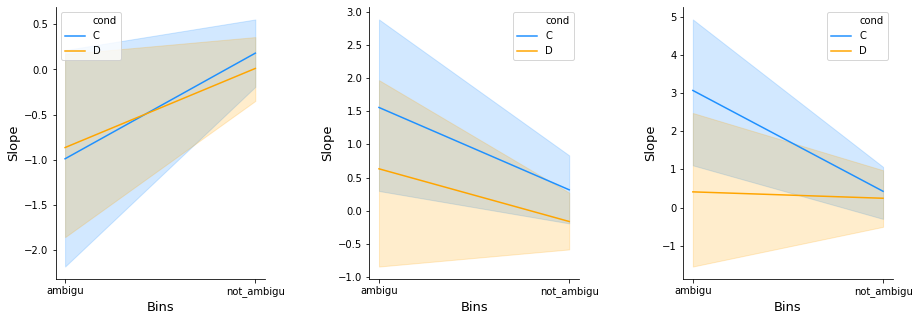

In [178]:
# I would plot the ANOVA for weight to see better what is happenong there
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

In [179]:
#I also ploted previous data in a boxplot instead of in a lineplot.
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], opacity = 0.8,
    x=dat['bins'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=1) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'], opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=1) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['bins'], showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=2) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'],
    boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=2) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['bins'], showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffbf00 '), row=1, col=3) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=3) #2A88D4

fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="Balto, sans-serif",
            size=13,
            color="#424242"
        )))
fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

In [180]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 2,:] #those participants don't have data for small bins
new_dflong = new_dflong.loc[new_dflong.npar != 3,:]
new_dflong = new_dflong.loc[new_dflong.npar != 14,:]
new_dflong = new_dflong.loc[new_dflong.npar != 18,:] #those participants neither has data for small bins
new_dflong = new_dflong.loc[new_dflong.npar != 21,:] #those participants don't have data for small bins
new_dflong = new_dflong.loc[new_dflong.npar != 22,:]
new_dflong = new_dflong.loc[new_dflong.npar != 23,:]
new_dflong = new_dflong.loc[new_dflong.npar != 24,:]
new_dflong = new_dflong.loc[new_dflong.npar != 25,:]

#n_par = str(len(np.unique(new_dflong.npar)))
n_par = np.unique(new_dflong.npar)     #pre_deci
n_bins= np.array([-0.60, 0, 0.60]) # -0.75, -0.45, 0, 0.45, 0.75 #-0.4, -0.3, -0.2, 0, 0.2, 0.3, 0.4

log_reg_confi_p1 = pd.DataFrame([]) # concatenate participants


formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'confiRTp1', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_confi_p1 = pd.concat([log_reg_confi_p1, log_reg], axis = 0)
    
log_reg_confi_p1.reset_index(inplace = True)
log_reg_confi_p1.head(10)

#######

log_reg_confi_p1.insert(7,'intercept-1', 0)
log_reg_confi_p1['intercept-1'] = log_reg_confi_p1['intercept']
log_reg_confi_p1['intercept-1'] = log_reg_confi_p1['intercept-1'].shift(1, fill_value = 0)
log_reg_confi_p1.insert(9,'weight-1', 0)
log_reg_confi_p1['weight-1']    = log_reg_confi_p1['weight']
log_reg_confi_p1['weight-1']    = log_reg_confi_p1['weight-1'].shift(1, fill_value = 0)
log_reg_confi_p1.insert(8, 'bias', 0)
log_reg_confi_p1['bias'] = log_reg_confi_p1['intercept'] - log_reg_confi_p1['intercept-1']
log_reg_confi_p1.insert(10, 'slope', 0)
log_reg_confi_p1['slope'] = log_reg_confi_p1['weight'] - log_reg_confi_p1['weight-1']
log_reg_confi_p1.head()

#######

log_reg_confi_p1 = log_reg_confi_p1.loc[(log_reg_confi_p1.cong_deci == 'I'),:]
log_reg_confi_p1 = log_reg_confi_p1.loc[(log_reg_confi_p1.cond == 'C'),:]

log_reg_confi_p1 = log_reg_confi_p1.drop(columns=['intercept-1', 'intercept', 'cong_deci', 'weight', 'weight-1', 'PSE', 'level_6'])
log_reg_confi_p1.head()

#######

log_reg_confi_p1["bins"] = log_reg_confi_p1["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_confi_p1.head()

npar  nrep cond confiRTp1        bins      bias     slope
1   1.0     0    C    RTfast  not_ambigu -0.154332 -0.063612
3   1.0     0    C    RTslow  not_ambigu  1.572388  1.901448
5   1.0     1    C    RTfast  not_ambigu  2.347102 -0.644870
7   1.0     1    C    RTslow  not_ambigu  2.818271  0.345536
9   1.0     2    C    RTfast  not_ambigu  3.462025  0.644109

In [181]:
#I also ploted previous data in a boxplot instead of in a lineplot.
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
dat = log_reg_confi_p1.loc[(log_reg_confi_p1.confiRTp1 == 'RTfast') & (log_reg_confi_p1.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], opacity = 0.8,
    x=dat['bins'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Confidence RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=1) #2A88D4

dat = log_reg_confi_p1.loc[(log_reg_confi_p1.confiRTp1 == 'RTslow') & (log_reg_confi_p1.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'], opacity = 0.65,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Unsure RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=1) #2A88D4

dat = log_reg_confi_p1.loc[(log_reg_confi_p1.confiRTp1 == 'RTfast') & (log_reg_confi_p1.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['bins'], showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Confidence RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=2) #2A88D4

dat = log_reg_confi_p1.loc[(log_reg_confi_p1.confiRTp1 == 'RTslow') & (log_reg_confi_p1.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'],
    boxpoints='all', showlegend=False, opacity = 0.65,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Unsure RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=2) #2A88D4

dat = log_reg_confi_p1.loc[(log_reg_confi_p1.confiRTp1 == 'RTfast') & (log_reg_confi_p1.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['bins'], showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Confidence RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=3) #2A88D4

dat = log_reg_confi_p1.loc[(log_reg_confi_p1.confiRTp1 == 'RTslow') & (log_reg_confi_p1.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.65,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Unsure RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=3) #2A88D4
#720b7d #029d2b
fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    title='Confidence with P1',
    yaxis_title="Beta weight Incong. - Beta weight Cong. Cardinal (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="Balto, sans-serif",
            size=13,
            color="#424242"
        )))
fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

In [182]:
pg.rm_anova(dv='slope', within=['bins', 'confiRTp1'], subject='npar', correction=True, 
            detailed=True, data=log_reg_confi_p1.loc[log_reg_confi_p1.nrep==0])

Source         SS  ddof1  ddof2         MS         F     p-unc  \
0              bins  27.557711      1     17  27.557711  3.901012  0.064725   
1         confiRTp1   0.277749      1     17   0.277749  0.017483  0.896359   
2  bins * confiRTp1   3.821488      1     17   3.821488  0.388746  0.541235   

   p-GG-corr       np2  eps  
0   0.064725  0.186642  1.0  
1   0.896359  0.001027  1.0  
2   0.541235  0.022356  1.0

In [183]:
pg.rm_anova(dv='slope', within=['bins', 'confiRTp1'], subject='npar', correction=True, 
            detailed=True, data=log_reg_confi_p1.loc[log_reg_confi_p1.nrep==1])

Source         SS  ddof1  ddof2         MS         F     p-unc  \
0              bins  10.144397      1     17  10.144397  0.431641  0.519981   
1         confiRTp1  30.746048      1     17  30.746048  0.959412  0.341070   
2  bins * confiRTp1  11.459446      1     17  11.459446  0.301543  0.590058   

   p-GG-corr       np2  eps  
0   0.519981  0.024762  1.0  
1   0.341070  0.053421  1.0  
2   0.590058  0.017429  1.0

In [184]:
pg.rm_anova(dv='slope', within=['bins', 'confiRTp1'], subject='npar', correction=True, 
            detailed=True, data=log_reg_confi_p1.loc[log_reg_confi_p1.nrep==2])

Source         SS  ddof1  ddof2         MS         F     p-unc  \
0              bins  36.017903      1     17  36.017903  1.182890  0.291949   
1         confiRTp1   4.324300      1     17   4.324300  0.147950  0.705271   
2  bins * confiRTp1   2.185326      1     17   2.185326  0.067234  0.798521   

   p-GG-corr       np2  eps  
0   0.291949  0.065055  1.0  
1   0.705271  0.008628  1.0  
2   0.798521  0.003939  1.0

In [185]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 2,:]
new_dflong = new_dflong.loc[new_dflong.npar != 5,:] #those participants don't have data for small bins
new_dflong = new_dflong.loc[new_dflong.npar != 14,:]
new_dflong = new_dflong.loc[new_dflong.npar != 16,:]
new_dflong = new_dflong.loc[new_dflong.npar != 18,:] #those participants neither has data for small bins
new_dflong = new_dflong.loc[new_dflong.npar != 21,:] #those participants don't have data for small bins
new_dflong = new_dflong.loc[new_dflong.npar != 22,:]
new_dflong = new_dflong.loc[new_dflong.npar != 23,:]
new_dflong = new_dflong.loc[new_dflong.npar != 24,:]
new_dflong = new_dflong.loc[new_dflong.npar != 25,:]

#n_par = str(len(np.unique(new_dflong.npar)))
n_par = np.unique(new_dflong.npar)     #pre_deci
n_bins= np.array([-0.60, 0, 0.60]) # -0.75, -0.45, 0, 0.45, 0.75 #-0.4, -0.3, -0.2, 0, 0.2, 0.3, 0.4

log_reg_confi_pre = pd.DataFrame([]) # concatenate participants


formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'confiRTpre', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_confi_pre = pd.concat([log_reg_confi_pre, log_reg], axis = 0)
    
log_reg_confi_pre.reset_index(inplace = True)
log_reg_confi_pre.head(10)

#######

log_reg_confi_pre.insert(7,'intercept-1', 0)
log_reg_confi_pre['intercept-1'] = log_reg_confi_pre['intercept']
log_reg_confi_pre['intercept-1'] = log_reg_confi_pre['intercept-1'].shift(1, fill_value = 0)
log_reg_confi_pre.insert(9,'weight-1', 0)
log_reg_confi_pre['weight-1']    = log_reg_confi_pre['weight']
log_reg_confi_pre['weight-1']    = log_reg_confi_pre['weight-1'].shift(1, fill_value = 0)
log_reg_confi_pre.insert(8, 'bias', 0)
log_reg_confi_pre['bias'] = log_reg_confi_pre['intercept'] - log_reg_confi_pre['intercept-1']
log_reg_confi_pre.insert(10, 'slope', 0)
log_reg_confi_pre['slope'] = log_reg_confi_pre['weight'] - log_reg_confi_pre['weight-1']
log_reg_confi_pre.head()

#######

log_reg_confi_pre = log_reg_confi_pre.loc[(log_reg_confi_pre.cong_deci == 'I'),:]
log_reg_confi_pre = log_reg_confi_pre.loc[(log_reg_confi_pre.cond == 'C'),:]

log_reg_confi_pre = log_reg_confi_pre.drop(columns=['intercept-1', 'intercept', 'cong_deci', 'weight', 'weight-1', 'PSE', 'level_6'])
log_reg_confi_pre.head()

#######

log_reg_confi_pre["bins"] = log_reg_confi_pre["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_confi_pre.head()

npar  nrep cond confiRTpre        bins      bias     slope
1   1.0     0    C     RTfast  not_ambigu  0.539589  0.402048
3   1.0     0    C     RTslow  not_ambigu  0.069345  0.962646
5   1.0     1    C     RTfast  not_ambigu  2.347102 -0.644870
7   1.0     1    C     RTslow  not_ambigu  2.818271  0.345536
9   1.0     2    C     RTfast  not_ambigu  4.411218  1.537510

In [186]:
#I also ploted previous data in a boxplot instead of in a lineplot.
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
dat = log_reg_confi_pre.loc[(log_reg_confi_pre.confiRTpre == 'RTfast') & (log_reg_confi_pre.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], opacity = 0.8,
    x=dat['bins'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Confidence RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=1) #2A88D4

dat = log_reg_confi_pre.loc[(log_reg_confi_pre.confiRTpre == 'RTslow') & (log_reg_confi_pre.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'], opacity = 0.65,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Unsure RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=1) #2A88D4

dat = log_reg_confi_pre.loc[(log_reg_confi_pre.confiRTpre == 'RTfast') & (log_reg_confi_pre.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['bins'], showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Confidence RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=2) #2A88D4

dat = log_reg_confi_pre.loc[(log_reg_confi_pre.confiRTpre == 'RTslow') & (log_reg_confi_pre.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'],
    boxpoints='all', showlegend=False, opacity = 0.65,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Unsure RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=2) #2A88D4

dat = log_reg_confi_pre.loc[(log_reg_confi_pre.confiRTpre == 'RTfast') & (log_reg_confi_pre.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['bins'], showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Confidence RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #029d2b '), row=1, col=3) #2A88D4

dat = log_reg_confi_pre.loc[(log_reg_confi_pre.confiRTpre == 'RTslow') & (log_reg_confi_pre.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.65,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Unsure RT', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #720b7d '), row=1, col=3) #2A88D4

fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-20,-10, 0, 10, 20, 30], ticktext=['-20','-10', '0', '10' ,'20', '3' '0'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    title='Confidence with previous response',
    yaxis_title="Beta weight Incong. - Beta weight Cong. Cardinal(a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="Balto, sans-serif",
            size=13,
            color="#424242"
        )))
fig['layout']['yaxis1'].update(range=[-20.05, 35.1]); fig['layout']['yaxis2'].update(range=[-20.05, 35.1])
fig['layout']['yaxis3'].update(range=[-20.05, 35.1])

fig.show()

In [187]:
pg.rm_anova(dv='slope', within=['bins', 'confiRTpre'], subject='npar', correction=True, 
            detailed=True, data=log_reg_confi_pre.loc[log_reg_confi_pre.nrep==2])

Source         SS  ddof1  ddof2         MS         F     p-unc  \
0               bins   3.924917      1     16   3.924917  0.084232  0.775370   
1         confiRTpre  20.876787      1     16  20.876787  0.415383  0.528383   
2  bins * confiRTpre   0.433223      1     16   0.433223  0.009430  0.923847   

   p-GG-corr       np2  eps  
0   0.775370  0.005237  1.0  
1   0.528383  0.025305  1.0  
2   0.923847  0.000589  1.0

### What is different between those who follows disconfirmatory strategy and those that not?

In [188]:
df['disconfirmatory'] = '-'
df.loc[(df.npar == 20) | (df.npar == 3) | (df.npar == 9) | (df.npar == 19) | (df.npar == 7) | (df.npar == 16) | (df.npar == 1) | (df.npar == 27) | (df.npar == 6) , 'disconfirmatory'] = 'No'
df.loc[(df.npar == 18) | (df.npar == 2) | (df.npar == 14) | (df.npar == 21) | (df.npar == 23) | (df.npar == 4) | (df.npar == 26) | (df.npar == 22) | (df.npar == 28) , 'disconfirmatory'] = 'Yes'

In [189]:
df.loc[(df.npar == 20) | (df.npar == 3) | (df.npar == 9) | (df.npar == 19) | (df.npar == 7) | (df.npar == 16) | (df.npar == 1) | (df.npar == 27) | (df.npar == 6) , 'disconfirmatory'] = 'No'
df.loc[(df.npar == 18) | (df.npar == 2) | (df.npar == 14) | (df.npar == 21) | (df.npar == 23) | (df.npar == 4) | (df.npar == 26) | (df.npar == 22) | (df.npar == 28) , 'disconfirmatory'] = 'Yes'

In [190]:
df.head()

npar subj  nblock  ntrial  nrep  cond    DV resp  deci  r_map       rDV  \
0   1.0  p02       0       0     0     0 -0.38    m     1      0 -0.391061   
1   1.0  p02       0       0     1     0 -0.38    m     1      0 -0.391061   
2   1.0  p02       0       0     2     0 -0.38    z     1     45 -0.391061   
3   1.0  p02       0       1     0     0 -0.48    m     0     45 -0.468642   
4   1.0  p02       0       1     1     0 -0.48    z     0      0 -0.468642   

   pre_deci  first_deci Expectancy  consistent  pre_correct  first_correct  \
0         0           0          E           1            0              0   
1         1           0          U           0            0              0   
2         1           1          U           1            0              0   
3         1           1          U           1            0              0   
4         0           1          E           0            1              0   

   both_correct  both_incorrect  first_error  second_error  correct  repeat  \
0             0               1            0             0        0       0   
1             0               1            0             0        0       0   
2             0               1            0             0        0       1   
3             0               1            0             0        1       1   
4             0               0            1             0        1       0   

   pre_repeat  repeat_all     RT        d1        d2        d3        d4  \
0           0           0  2.836 -0.443358 -0.174941 -0.977600 -0.653679   
1           1           0  0.888 -0.443358 -0.174941 -0.977600 -0.653679   
2           1           1  1.236 -0.443358 -0.174941 -0.977600 -0.653679   
3           0           0  0.834 -0.929736  0.255933 -0.458119 -0.886446   
4           1           0  1.042 -0.929736  0.255933 -0.458119 -0.886446   

         d5        d6     o1     o2     o3     o4     o5     o6  pre_cond  \
0  0.748394 -0.845183  2.923  0.324  1.562  0.136  2.455  1.510         0   
1  0.748394 -0.845183  2.923  0.324  1.562  0.136  2.455  1.510         0   
2  0.748394 -0.845183  2.923  0.324  1.562  0.136  2.455  1.510         0   
3 -0.203989 -0.589498  3.114  2.064  1.358  3.097  2.829  1.732         0   
4 -0.203989 -0.589498  3.114  2.064  1.358  3.097  2.829  1.732         0   

        RTz   pre_RTz  2pre_RTz    p1_RTz     1/RTz disconfirmatory  
0  2.262715  0.000000  0.000000  2.262715 -1.148476              No  
1 -0.192855  2.262715  0.000000  2.262715 -0.141080              No  
2  0.245820 -0.192855  2.262715  2.262715 -0.554012              No  
3 -0.260925  0.245820 -0.192855 -0.260925 -0.046119              No  
4  0.001271 -0.260925  0.245820 -0.260925 -0.357836              No

In [191]:
df = df.drop(columns =['disconfirmatory'])

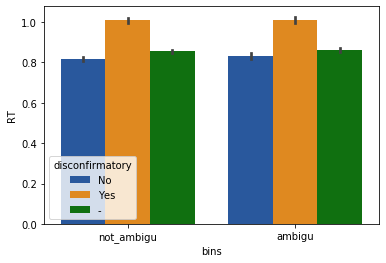

In [192]:
dflong2 = dflong
dflong2["bins"] = dflong2["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])

ax = sns.barplot(x="bins", y="RT", hue="disconfirmatory", data=dflong2)

##### Los sujetos cuando usan la disconfirmatory strategy son mas lentos en los trials correspondientes??

In [193]:
log_reg_cong_bins.head()

npar  nrep cond        bins      bias     slope
1   1.0     0    C  not_ambigu  0.369236  0.526703
3   1.0     1    C  not_ambigu  2.526410 -0.236129
5   1.0     2    C  not_ambigu  3.398996  0.554207
7   1.0     0    C      ambigu  0.480509 -0.759532
9   1.0     0    D      ambigu  0.596686 -2.674749

In [194]:
# DF means disconfirmatory factor. DF = (slope diagonal + slope cardinal)/2
DFP1 = log_reg_cong_bins.loc[(log_reg_cong_bins.nrep == 0),:]
DFP1.head()

######

DFP1 = DFP1.sort_values(by=['npar', 'bins', 'cond'])
#DFP1.sort_values(by=['bins'])
DFP1.head()

npar  nrep cond        bins      bias     slope
7    1.0     0    C      ambigu  0.480509 -0.759532
9    1.0     0    D      ambigu  0.596686 -2.674749
1    1.0     0    C  not_ambigu  0.369236  0.526703
19   1.0     0    D  not_ambigu -0.750160  0.755806
31   2.0     0    C      ambigu -0.358232 -3.020183

In [195]:
DFP1.insert(6,'slope_cardinal', 0)
DFP1['slope_cardinal']    = DFP1['slope']
DFP1['slope_cardinal']    = DFP1['slope_cardinal'].shift(1, fill_value = 0)

DFP1.insert(6,'slope_diagonal', 0)
DFP1['slope_diagonal']    = DFP1['slope']

DFP1 = DFP1.drop(columns = ['slope', 'bias', 'nrep'])
DFP1.head()

npar cond        bins  slope_diagonal  slope_cardinal
7    1.0    C      ambigu       -0.759532        0.000000
9    1.0    D      ambigu       -2.674749       -0.759532
1    1.0    C  not_ambigu        0.526703       -2.674749
19   1.0    D  not_ambigu        0.755806        0.526703
31   2.0    C      ambigu       -3.020183        0.755806

In [196]:
#DFP1.insert(5,'DF', 0)
DFP1['DF'] = (DFP1['slope_diagonal'] + DFP1['slope_cardinal'])/2
DFP1.head()

######

DFP1 = DFP1.loc[DFP1.cond == 'D',:]
DFP1 = DFP1.drop(columns = ['cond'])
DFP1.head()

######

DFP1 = DFP1.loc[DFP1.bins == 'ambigu',:]
DFP1 = DFP1.drop(columns = ['bins'])
DFP1.head()


npar  slope_diagonal  slope_cardinal        DF
9     1.0       -2.674749       -0.759532 -1.717140
33    2.0        2.794150       -3.020183 -0.113016
57    3.0        0.327267        1.494164  0.910715
81    4.0        0.919127       -1.291469 -0.186171
105   5.0       -1.540117        1.768183  0.114033

###### For repetition 2

In [197]:
# DF means disconfirmatory factor. DF = (slope diagonal + slope cardinal)/2
DFP2 = log_reg_cong_bins.loc[(log_reg_cong_bins.nrep == 1),:]
DFP2.head()

######

DFP2 = DFP2.sort_values(by=['npar', 'bins', 'cond'])
DFP2.head()

######

DFP2.insert(6,'slope_cardinal', 0)
DFP2['slope_cardinal']    = DFP2['slope']
DFP2['slope_cardinal']    = DFP2['slope_cardinal'].shift(1, fill_value = 0)

DFP2.insert(6,'slope_diagonal', 0)
DFP2['slope_diagonal']    = DFP2['slope']

DFP2 = DFP2.drop(columns = ['slope', 'bias', 'nrep'])
DFP2.head()

DFP2['DF'] = (DFP2['slope_diagonal'] + DFP2['slope_cardinal'])/2
DFP2.head()

######

DFP2 = DFP2.loc[DFP2.cond == 'D',:]
DFP2 = DFP2.drop(columns = ['cond'])
DFP2.head()

######

DFP2 = DFP2.loc[DFP2.bins == 'ambigu',:]
DFP2 = DFP2.drop(columns = ['bins'])
DFP2.head()


npar  slope_diagonal  slope_cardinal        DF
13    1.0       -1.618206        0.916403 -0.350901
37    2.0       -2.976291        3.610859  0.317284
61    3.0        6.277923       -6.978495 -0.350286
85    4.0        2.924190        1.984198  2.454194
109   5.0       -2.909321        8.859830  2.975254

###### For repetition 3

In [198]:
# DF means disconfirmatory factor. DF = (slope diagonal + slope cardinal)/2
DFP3 = log_reg_cong_bins.loc[(log_reg_cong_bins.nrep == 2),:]
DFP3.head()

######

DFP3 = DFP3.sort_values(by=['npar', 'bins', 'cond'])
DFP3.head()

######

DFP3.insert(6,'slope_cardinal', 0)
DFP3['slope_cardinal']    = DFP3['slope']
DFP3['slope_cardinal']    = DFP3['slope_cardinal'].shift(1, fill_value = 0)

DFP3.insert(6,'slope_diagonal', 0)
DFP3['slope_diagonal']    = DFP3['slope']

DFP3 = DFP3.drop(columns = ['slope', 'bias', 'nrep'])
DFP3.head()

DFP3['DF'] = (DFP3['slope_diagonal'] + DFP3['slope_cardinal'])/2
DFP3.head()

######

DFP3 = DFP3.loc[DFP3.cond == 'D',:]
DFP3 = DFP3.drop(columns = ['cond'])
DFP3.head()

######

DFP3 = DFP3.loc[DFP3.bins == 'ambigu',:]
DFP3 = DFP3.drop(columns = ['bins'])
DFP3.head()


npar  slope_diagonal  slope_cardinal        DF
17    1.0        2.911950       -0.619638  1.146156
41    2.0       -2.007275       11.810531  4.901628
65    3.0        4.429673       -5.923330 -0.746829
89    4.0       -1.035253        8.502023  3.733385
113   5.0      -10.554968        4.175833 -3.189568

In [199]:
print(DFP1.median())
print(DFP2.median())
print(DFP3.median())

npar              16.500000
slope_diagonal    -0.271183
slope_cardinal    -0.981031
DF                -0.496864
dtype: float64
npar              16.500000
slope_diagonal     1.370860
slope_cardinal     1.482512
DF                 1.015685
dtype: float64
npar              16.500000
slope_diagonal     0.424589
slope_cardinal     3.167524
DF                 1.788309
dtype: float64


In [200]:
DFP1['discon_bias'] = 'no'
DFP1.loc[(DFP1.DF > -0.497), 'discon_bias'] = 'yes'

DFP2['discon_bias'] = 'no'
DFP2.loc[(DFP2.DF > 1.016), 'discon_bias'] = 'yes'

DFP3['discon_bias'] = 'no'
DFP3.loc[(DFP3.DF > 1.788), 'discon_bias'] = 'yes'
DFP3.head()

npar  slope_diagonal  slope_cardinal        DF discon_bias
17    1.0        2.911950       -0.619638  1.146156          no
41    2.0       -2.007275       11.810531  4.901628         yes
65    3.0        4.429673       -5.923330 -0.746829          no
89    4.0       -1.035253        8.502023  3.733385         yes
113   5.0      -10.554968        4.175833 -3.189568          no

In [201]:
print(DFP1.loc[(DFP1.discon_bias == 'yes')])
#print(DFP2.loc[(DFP2.discon_bias == 'yes')])
#print(DFP3.loc[(DFP3.discon_bias == 'yes')])

     npar  slope_diagonal  slope_cardinal        DF discon_bias
33    2.0        2.794150       -3.020183 -0.113016         yes
57    3.0        0.327267        1.494164  0.910715         yes
81    4.0        0.919127       -1.291469 -0.186171         yes
105   5.0       -1.540117        1.768183  0.114033         yes
129   6.0       -3.259655        2.618689 -0.320483         yes
249  13.0        1.915970       -1.273796  0.321087         yes
297  16.0        1.107998       -0.196925  0.455537         yes
345  18.0        1.205214        0.798338  1.001776         yes
369  19.0       -0.156872       -0.604869 -0.380871         yes
393  20.0        3.322247       -2.788827  0.266710         yes
441  22.0       -5.592327       10.039483  2.223578         yes
537  27.0        1.965251       -2.015410 -0.025080         yes
609  30.0       -0.385493        1.065725  0.340116         yes


In [202]:
dflong2 = dflong
dflong2['discon_bias1'] = 'no'
dflong2.loc[(dflong2.npar == 2) | (dflong2.npar == 3) | (dflong2.npar == 4) | (dflong2.npar == 5) | (dflong2.npar == 6) | (dflong2.npar == 13) | (dflong2.npar == 16) | (dflong2.npar == 18) | (dflong2.npar == 19) | (dflong2.npar == 20) | (dflong2.npar == 22) | (dflong2.npar == 27) | (dflong2.npar == 30), 'discon_bias1'] = 'yes'

dflong2['discon_bias2'] = 'no'
dflong2.loc[(dflong2.npar == 4) | (dflong2.npar == 5) | (dflong2.npar == 6) | (dflong2.npar == 11) | (dflong2.npar == 13) | (dflong2.npar == 16) | (dflong2.npar == 21) | (dflong2.npar == 22) | (dflong2.npar == 23) | (dflong2.npar == 25) | (dflong2.npar == 26) | (dflong2.npar == 27) | (dflong2.npar == 29), 'discon_bias2'] = 'yes'

dflong2['discon_bias3'] = 'no'
dflong2.loc[(dflong2.npar == 2) | (dflong2.npar == 4) | (dflong2.npar == 13) | (dflong2.npar == 16) | (dflong2.npar == 17) | (dflong2.npar == 18) | (dflong2.npar == 20) | (dflong2.npar == 21) | (dflong2.npar == 22) | (dflong2.npar == 26) | (dflong2.npar == 28) | (dflong2.npar == 29) | (dflong2.npar == 30), 'discon_bias3'] = 'yes'


dflong2.head()


npar  nblock  ntrial  nrep cond  deci  pre_deci cong_deci pre_expected  \
0   1.0       0       0     0    C     1         0         C            U   
1   1.0       0       0     1    C     1         1         I            E   
2   1.0       0       0     2    C     1         1         I            U   
3   1.0       0       1     0    C     0         1         I            U   
4   1.0       0       1     1    C     0         0         C            U   

   cong_long cong_stim expected  pre_correct  correct  first_deci pre_cond  \
0          0         C        E            0        0           0        C   
1          0         C        U            0        0           0        C   
2          1         C        U            0        0           1        C   
3          1         C        U            0        1           1        C   
4          0         C        E            1        1           1        C   

  disconfirmatory      1/RT     RT       RTz   pre_RTz    p1_RTz stim  \
0              No  0.352609  2.836  2.262715  0.000000  2.262715   d1   
1              No  1.126126  0.888 -0.192855  2.262715  2.262715   d1   
2              No  0.809061  1.236  0.245820 -0.192855  2.262715   d1   
3              No  1.199041  0.834 -0.260925  0.245820 -0.260925   d1   
4              No  0.959693  1.042  0.001271 -0.260925 -0.260925   d1   

         dv  orient confiRT confiRTp1 confiRTpre        bins discon_bias1  \
0 -0.443358   2.923  RTslow    RTslow     RTfast  not_ambigu           no   
1 -0.443358   2.923  RTfast    RTslow     RTslow  not_ambigu           no   
2 -0.443358   2.923  RTslow    RTslow     RTfast  not_ambigu           no   
3 -0.929736   3.114  RTfast    RTfast     RTslow  not_ambigu           no   
4 -0.929736   3.114  RTslow    RTfast     RTfast  not_ambigu           no   

  discon_bias2 discon_bias3  
0           no           no  
1           no           no  
2           no           no  
3           no           no  
4           no           no

Text(0.5, 1.0, 'P2')

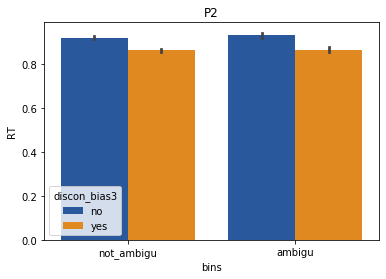

In [203]:
dflong2 = dflong
dflong2["bins"] = dflong2["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])

ax = sns.barplot(x="bins", y="RT", hue="discon_bias3", data=dflong2)
plt.title('P2')

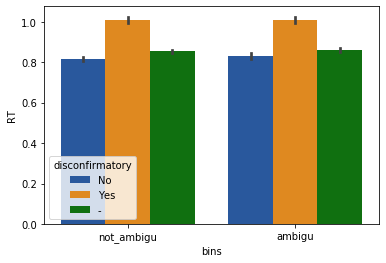

In [204]:
dflong2 = dflong
dflong2["bins"] = dflong2["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])

ax = sns.barplot(x="bins", y="RT", hue="disconfirmatory", data=dflong2)

In [205]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
new_dflong = dflong
#new_dflong = new_dflong.loc[new_dflong.npar != 18,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 2,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 20,:]
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #those participants neither has data for small bins

#new_dflong = new_dflong.loc[new_dflong.npar != 1,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 14,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 16,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 21,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 22,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 25,:]

#n_par = str(len(np.unique(new_dflong.npar)))
n_par = np.unique(new_dflong.npar)     #pre_deci
n_bins= np.array([-0.60, 0, 0.60]) # -0.75, -0.45, 0, 0.45, 0.75 #-0.4, -0.3, -0.2, 0, 0.2, 0.3, 0.4

log_reg_cong_bins = pd.DataFrame([]) # concatenate participants


formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

Empty DataFrame
Columns: [index]
Index: []

In [ ]:
#same plot with seaborn (barplot and scatter)

fig.write_image("images/fig1.png")

In [ ]:
#check which conditions' slopes are diferent than 0
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
dat.head()

In [ ]:
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

In [ ]:
# I would plot the ANOVA for weight to see better what is happenong there
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="bias", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Bias', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="bias", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Bias', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="bias", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Bias', fontsize= 13)

sns.despine(top=True)

In [ ]:
#I also ploted previous data in a boxplot instead of in a lineplot.
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'], opacity = 1,
    x=dat['bins'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=1) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'], x=dat['bins'], opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffe082 '), row=1, col=1) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'],
    x=dat['bins'], showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=2) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'], x=dat['bins'],
    boxpoints='all', showlegend=False, opacity = 0.8,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffe082 '), row=1, col=2) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'],
    x=dat['bins'], showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #00acc1 '), row=1, col=3) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'], x=dat['bins'], showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color=' #ffe082 '), row=1, col=3) #2A88D4

fig.update_layout(
    #boxmode='group', 
    boxgroupgap=0 # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1], ticktext=['Unabiguous', 'Ambiguous'], tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-10,-7.5,-5, -2.5, 0, 2.5, 5, 7.5, 10], ticktext=['-10','-7.5', '-5', '-2.5', '0', '2.5' ,'5', '7.5', '10'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept Incongruent - Inter. Congruent (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   #  "#54636D" 
    )
)
#fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="Balto, sans-serif",
            size=13,
            color="#424242"
        )))
fig['layout']['yaxis1'].update(range=[-10.05, 10.05]); fig['layout']['yaxis2'].update(range=[-10.05, 10.05])
fig['layout']['yaxis3'].update(range=[-10.05, 10.05])

fig.show()

In [ ]:
pg.rm_anova(dv='bias', within=['bins', 'cond'], subject='npar', correction=True, 
            detailed=True, data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2])

In [ ]:
#I also ploted previous data in a boxplot instead of in a lineplot.

fig = go.Figure()

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.bins == 'ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=8,
        opacity=0.65,
        line=dict(color='#f2f2f2', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#FCD2A8')) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.bins == 'not_ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=8,
        opacity=0.65,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal Not Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#EC6778')) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.bins == 'ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=8,
        opacity=0.65,
        line=dict(color='#f2f2f2', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#007D75')) #2A88D4

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.bins == 'not_ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['bias'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=8,
        opacity=0.65,
        line=dict(color='#f2f2f2', width=.4)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal Not Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#529A86')) #2A88D4

fig.update_layout(
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
#fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="Bias",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
#fig['layout']['yaxis1'].update(range=[-30, 30], dtick=5, autorange=False)
fig.show()

### Congruency with previous STIMULI

In [ ]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
new_dflong = dflong
#new_dflong = new_dflong.loc[new_dflong.npar != 18,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 2,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 20,:]
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #those participants neither has data for small bins

#new_dflong = new_dflong.loc[new_dflong.npar != 1,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 14,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 16,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 21,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 22,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 25,:]

#n_par = str(len(np.unique(new_dflong.npar)))
n_par = np.unique(new_dflong.npar)     #pre_deci
n_bins= np.array([-0.60, 0, 0.60]) # -0.75, -0.45, 0, 0.45, 0.75 #-0.4, -0.3, -0.2, 0, 0.2, 0.3, 0.4

log_reg_cong_bins_stim = pd.DataFrame([]) # concatenate participants


formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_stim', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins_stim = pd.concat([log_reg_cong_bins_stim, log_reg], axis = 0)
    
log_reg_cong_bins_stim.reset_index(inplace = True)
log_reg_cong_bins_stim.head(10)

In [ ]:
log_reg_cong_bins_stim.insert(7,'intercept-1', 0)
log_reg_cong_bins_stim['intercept-1'] = log_reg_cong_bins_stim['intercept']
log_reg_cong_bins_stim['intercept-1'] = log_reg_cong_bins_stim['intercept-1'].shift(1, fill_value = 0)
log_reg_cong_bins_stim.insert(9,'weight-1', 0)
log_reg_cong_bins_stim['weight-1']    = log_reg_cong_bins_stim['weight']
log_reg_cong_bins_stim['weight-1']    = log_reg_cong_bins_stim['weight-1'].shift(1, fill_value = 0)
log_reg_cong_bins_stim.insert(8, 'bias', 0)
log_reg_cong_bins_stim['bias'] = log_reg_cong_bins_stim['intercept'] - log_reg_cong_bins_stim['intercept-1']
log_reg_cong_bins_stim.insert(10, 'slope', 0)
log_reg_cong_bins_stim['slope'] = log_reg_cong_bins_stim['weight'] - log_reg_cong_bins_stim['weight-1']
log_reg_cong_bins_stim.head()

In [ ]:
log_reg_cong_bins_stim = log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.cong_stim == 'I'),:]
log_reg_cong_bins_stim = log_reg_cong_bins_stim.drop(columns=['intercept-1', 'intercept', 'cong_stim', 'weight', 'weight-1', 'PSE'])
log_reg_cong_bins_stim.head()

In [ ]:
log_reg_cong_bins_stim["bins"] = log_reg_cong_bins_stim["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins_stim.head()

In [ ]:
# I would plot the ANOVA for weight to see better what is happenong there
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

In [ ]:
#I also ploted previous data in a boxplot instead of in a lineplot.

fig = go.Figure()

dat = log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.cond == 'C') & (log_reg_cong_bins_stim.bins == 'ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#FCD2A8')) #2A88D4

dat = log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.cond == 'C') & (log_reg_cong_bins_stim.bins == 'not_ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal Not Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#EC6778')) #2A88D4

dat = log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.cond == 'D') & (log_reg_cong_bins_stim.bins == 'ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#007D75')) #2A88D4

dat = log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.cond == 'D') & (log_reg_cong_bins_stim.bins == 'not_ambigu'),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['slope'],
    x=dat['nrep'],
    boxpoints='all',
    jitter=0.5, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(
        color='#2A88D4',
        size=5,
        opacity=0.75,
        line=dict(color='#0A4893', width=.3)
    ),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Diagonal Not Ambigu', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#529A86')) #2A88D4

fig.update_layout(
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_yaxes(zeroline=True, zerolinewidth=0, zerolinecolor='White')
fig.update_xaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#E6E4E4', ticktext=['Weight'], tickfont=dict(family='verdana', color='#7f7f7f', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, tickfont=dict(family='verdana', color='#54636D', size=20))
#fig.update_yaxes(tickvals= [0.45, 0.55, 0.65, 0.75], ticktext=['0.45', '0.55', '0.65', '0.75'])

fig.update_layout(
    yaxis_title="Slope",
    font=dict(
        family="verdana",
        size=20,
        color="#54636D" #E6E4E4
    )
)
fig.update_traces(showlegend=True)

fig.update_layout(
    legend=dict(
        #x=0.3,
        #y=1,
        traceorder="normal",
        font=dict(
            family="verdana",
            size=13,
            color="#54636D"
        )))
#fig['layout']['yaxis1'].update(range=[-30, 30], dtick=5, autorange=False)
fig.show()

In [ ]:
pg.rm_anova(dv='slope', within=['bins', 'cond'], subject='npar', correction=True, 
            detailed=True, data=log_reg_cong_bins_stim.loc[log_reg_cong_bins_stim.nrep==1])

In [ ]:
dat = log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep==1) & (log_reg_cong_bins_stim.bins=='ambigu')]
pg.ttest(dat['slope'], 25).round(2)

In [ ]:
# I would plot the ANOVA for weight to see better what is happenong there
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="bias", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Bias', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="bias", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Bias', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="bias", hue="cond", palette= ["dodgerblue","orange"], data=log_reg_cong_bins_stim.loc[(log_reg_cong_bins_stim.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Bias', fontsize= 13)

sns.despine(top=True)

In [ ]:
pg.rm_anova(dv='bias', within=['bins', 'cond'], subject='npar', correction=True, 
            detailed=True, data=log_reg_cong_bins_stim.loc[log_reg_cong_bins_stim.nrep==2])

In [ ]:
# Again, we generate a model that represent the last plot. In this case, the next model just represent the previous left plot.
new_dflong = dflong
#new_dflong = new_dflong.loc[new_dflong.npar != 18,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 2,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 20,:]
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #those participants neither has data for small bins

#new_dflong = new_dflong.loc[new_dflong.npar != 1,:] #those participants don't have data for small bins
#new_dflong = new_dflong.loc[new_dflong.npar != 14,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 16,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 21,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 22,:]
#new_dflong = new_dflong.loc[new_dflong.npar != 25,:]

#n_par = str(len(np.unique(new_dflong.npar)))
n_par = np.unique(new_dflong.npar)     #n participants
n_bins= np.array([-0.60, 0, 0.60]) # -0.75, -0.45, 0, 0.45, 0.75 #-0.4, -0.3, -0.2, 0, 0.2, 0.3, 0.4

log_reg_pre_deci_bins = pd.DataFrame([]) # concatenate participants


formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'pre_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_pre_deci_bins = pd.concat([log_reg_pre_deci_bins, log_reg], axis = 0)
    
log_reg_pre_deci_bins.reset_index(inplace = True)
log_reg_pre_deci_bins.head(10)

In [ ]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
dat=log_reg_pre_deci_bins.loc[(log_reg_pre_deci_bins.nrep ==0),:]
sns.lineplot(x="bins", y="weight", hue="pre_deci", palette= ["dodgerblue","orange"], data=dat)
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('weight', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
dat=log_reg_pre_deci_bins.loc[(log_reg_pre_deci_bins.nrep ==1),:]
sns.lineplot(x="bins", y="weight", hue="pre_deci", palette= ["dodgerblue","orange"], data=dat)
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('weight', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
dat=log_reg_pre_deci_bins.loc[(log_reg_pre_deci_bins.nrep ==2),:]
sns.lineplot(x="bins", y="weight", hue="pre_deci", palette= ["dodgerblue","orange"], data=dat)
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('weight', fontsize= 13)

sns.despine(top=True)

In [ ]:
dat=log_reg_pre_deci_bins.loc[log_reg_pre_deci_bins.nrep==0]
pg.rm_anova(dv='weight', within=['bins', 'pre_deci'], subject='npar', data=dat, detailed=True, correction=True)

In [ ]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5
#con un valor negativo te cargas el primer plot

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
dat=log_reg_pre_deci_bins.loc[(log_reg_pre_deci_bins.nrep ==0),:]
sns.lineplot(x="bins", y="intercept", hue="pre_deci", palette= ["dodgerblue","orange"], data=dat)
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('intercept', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
dat=log_reg_pre_deci_bins.loc[(log_reg_pre_deci_bins.nrep ==1),:]
sns.lineplot(x="bins", y="intercept", hue="pre_deci", palette= ["dodgerblue","orange"], data=dat)
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('intercept', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
dat=log_reg_pre_deci_bins.loc[(log_reg_pre_deci_bins.nrep ==2),:]
sns.lineplot(x="bins", y="intercept", hue="pre_deci", palette= ["dodgerblue","orange"], data=dat)
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('intercept', fontsize= 13)

sns.despine(top=True)

In [ ]:
dat=log_reg_pre_deci_bins.loc[log_reg_pre_deci_bins.nrep==1]
pg.rm_anova(dv='intercept', within=['bins', 'pre_deci'], subject='npar', data=dat, detailed=True, correction=True)